<a href="https://colab.research.google.com/github/altdeep/causalML/blob/master/book/chapter%205/chapter_5_Connecting_Causality_and_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here, we demonstrate using a variational autoencoder to fit the following causal DAG.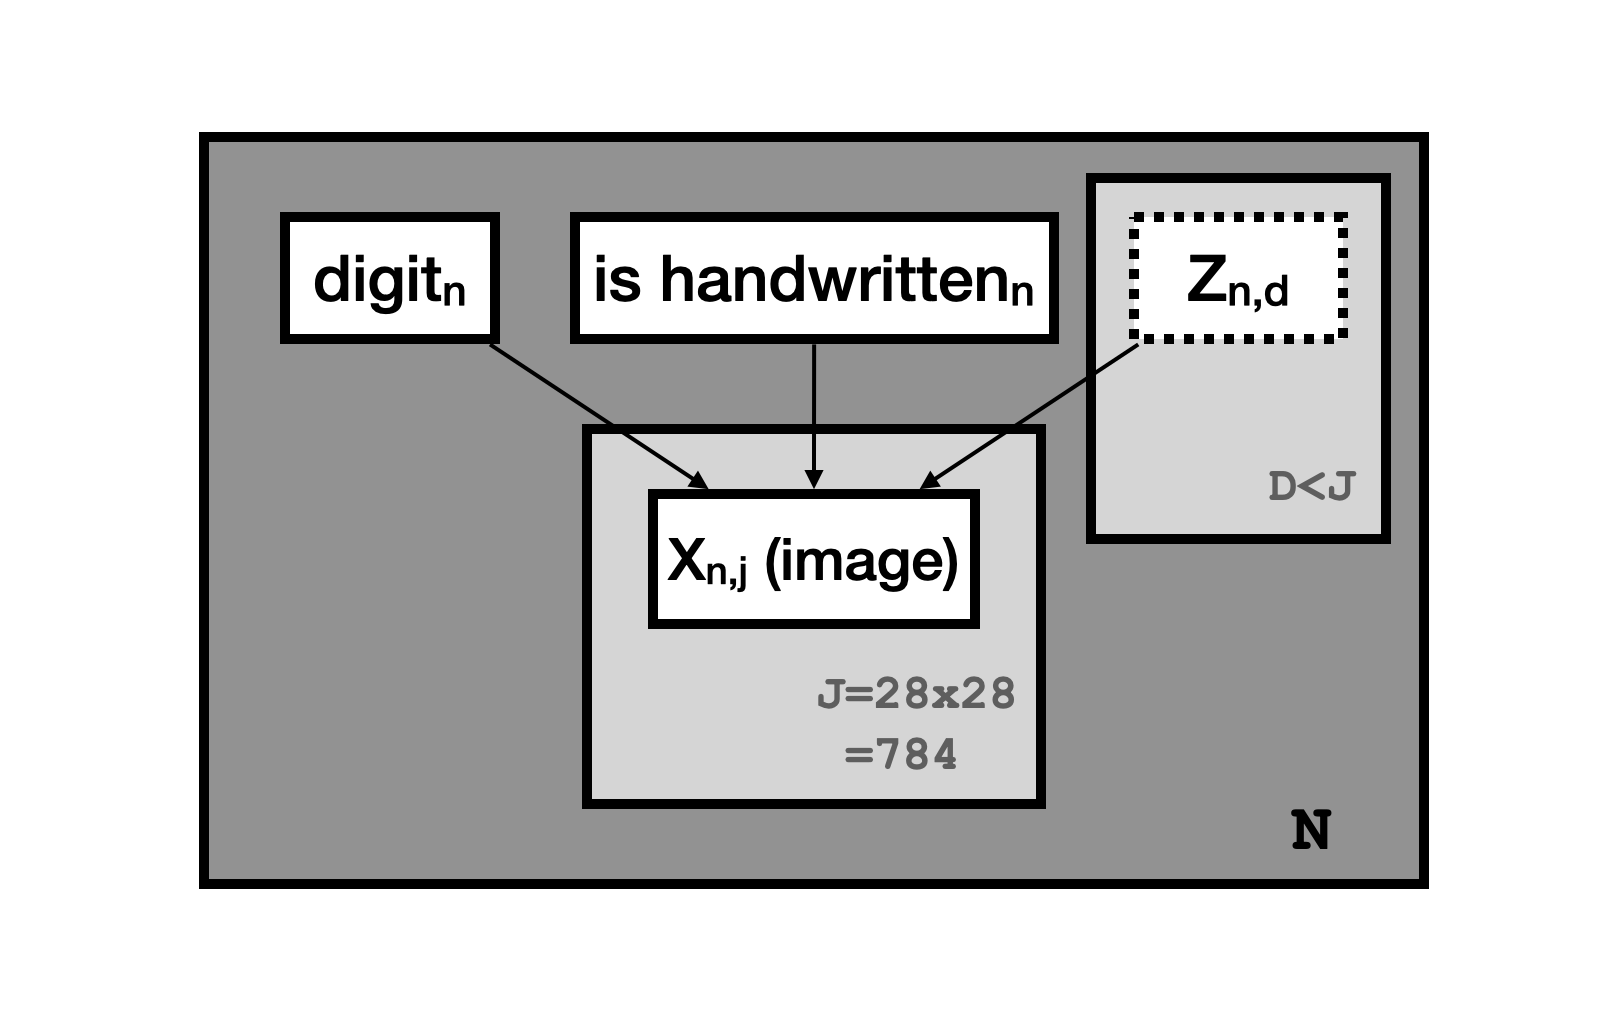

In [ ]:
!pip install pyro-ppl==1.8.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision import transforms

Mounted at /content/drive


In [ ]:
USE_CUDA = False
DEVICE_TYPE = torch.device("cuda" if USE_CUDA else "cpu")
BATCH_SIZE = 256
LEARNING_RATE = 1.0e-3
NUM_EPOCHS = 2500
TEST_FREQUENCY = 10
pyro.distributions.enable_validation(False)
REINIT_PARAMS = True

In [ ]:
class CombinedDataset(Dataset):
    def __init__(self, csv_file):
        self.dataset = pd.read_csv(csv_file)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        images = self.dataset.iloc[idx, 3:]
        images = np.array(images, dtype='float32')/255.
        images = images.reshape(28, 28)
        transform = transforms.ToTensor()
        images = transform(images)
        digits = self.dataset.iloc[idx, 2]
        digits = np.array([digits], dtype='int')
        is_handwritten = self.dataset.iloc[idx, 1]
        is_handwritten = np.array([is_handwritten], dtype='float32')
        return images, digits, is_handwritten

def setup_dataloaders(batch_size=64, use_cuda=USE_CUDA):
    combined_dataset = CombinedDataset(
        "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/combined_mnist_tmnist_data.csv"
    )
    n = len(combined_dataset)
    train_size = int(0.8 * n)
    test_size = n - train_size
    train_dataset, test_dataset = random_split(
        combined_dataset,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        **kwargs
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=True,
        **kwargs
    )
    return train_loader, test_loader


In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        img_dim = 28 * 28
        digit_dim = 10
        is_handwritten_dim = 1
        self.fc1 = nn.Linear(z_dim + digit_dim + is_handwritten_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, img_dim)
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z, digit, is_handwritten):
        input = torch.cat([z, digit, is_handwritten], dim=1)
        hidden = self.softplus(self.fc1(input))
        img_param = self.sigmoid(self.fc2(hidden))
        return img_param

class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        img_dim = 28 * 28
        digit_dim = 10
        is_handwritten_dim = 1
        self.fc1 = nn.Linear(img_dim + digit_dim + is_handwritten_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        self.softplus = nn.Softplus()
    
    def forward(self, img, digit, is_handwritten):
        input = torch.cat([img, digit, is_handwritten], dim=1)
        hidden = self.softplus(self.fc1(input))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [ ]:
class VAE(nn.Module):
    def __init__(
        self,
        z_dim=50,
        hidden_dim=400,
        use_cuda=USE_CUDA,
    ):
        super().__init__()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.setup_networks()
    
    def setup_networks(self):
        self.encoder = Encoder(self.z_dim, self.hidden_dim)
        self.decoder = Decoder(self.z_dim, self.hidden_dim)
        if self.use_cuda:
            self.cuda()
    
    def model(self, data_size=1):
        pyro.module("decoder", self.decoder)
        options = dict(dtype=torch.float32, device=DEVICE_TYPE)
        z_loc = torch.zeros(data_size, self.z_dim, **options)
        z_scale = torch.ones(data_size, self.z_dim, **options)
        z = pyro.sample("Z", dist.Normal(z_loc, z_scale).to_event(1))
        p_digit = torch.ones(data_size, 10, **options)/10
        digit = pyro.sample(
            "digit",
            dist.OneHotCategorical(p_digit)
        )
        p_is_handwritten = torch.ones(data_size, 1, **options)/2
        is_handwritten = pyro.sample(
            "is_handwritten",
            dist.Bernoulli(p_is_handwritten).to_event(1)
        )
        img_param = self.decoder(z, digit, is_handwritten)
        img = pyro.sample("img", dist.Bernoulli(img_param).to_event(1))
        return img, digit, is_handwritten
    
    def training_model(self, img, digit, is_handwritten, batch_size):
        model_conditioned_on_data = pyro.condition(
            self.model,
            data={
                "digit": digit,
                "is_handwritten": is_handwritten,
                "img": img
            }
        )
        with pyro.plate("data", batch_size):
            img, digit, is_handwritten = model_conditioned_on_data(batch_size)
        return img, digit, is_handwritten
    
    def training_guide(self, img, digit, is_handwritten, batch_size):
        pyro.module("encoder", self.encoder)
        options = dict(dtype=torch.float32, device=DEVICE_TYPE)
        with pyro.plate("data", batch_size):
            z_loc, z_scale = self.encoder(img, digit, is_handwritten)
            z = pyro.sample("Z", dist.Normal(z_loc, z_scale).to_event(1))

In [ ]:
def plot_image(img, title=None):
    fig = plt.figure()
    plt.imshow(img.cpu(), cmap='Greys_r', interpolation='nearest')
    if title is not None:
        plt.title(title)
    plt.show()

def reconstruct_img(vae, img, digit, is_handwritten, use_cuda=USE_CUDA):
    img = img.reshape(-1, 28 * 28)
    digit = F.one_hot(torch.tensor(digit), 10)
    is_handwritten = torch.tensor(is_handwritten_rng).unsqueeze(0)
    if use_cuda:
      img, digit, is_handwritten = img.cuda(), digit.cuda(), is_handwritten.cuda()
    z_loc, z_scale = vae.encoder(img, digit, is_handwritten)
    z = dist.Normal(z_loc, z_scale).sample()
    img_expectation = vae.decoder(z, digit, is_handwritten)
    return img_expectation.squeeze().view(28, 28).detach()

def compare_images(img1, img2):
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(img1.cpu(), cmap='Greys_r', interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(img2.cpu(), cmap='Greys_r', interpolation='nearest')
    plt.axis('off')
    plt.title('reconstruction')
    plt.show()


In [ ]:
def get_random_example(loader):    
    random_idx = np.random.randint(0, len(loader.dataset))
    img, digit, is_handwritten = loader.dataset[random_idx]
    return img.squeeze(), digit, is_handwritten

def reshape_data(img, digit, is_handwritten):
    digit = F.one_hot(digit, 10).squeeze()
    img = img.reshape(-1, 28*28)
    return img, digit, is_handwritten

def generate_coded_data(vae, use_cuda=USE_CUDA):
    z_loc = torch.zeros(1, vae.z_dim)
    z_scale = torch.ones(1, vae.z_dim)
    z = dist.Normal(z_loc, z_scale).to_event(1).sample()
    p_digit = torch.ones(1, 10)/10
    digit = dist.OneHotCategorical(p_digit).sample()
    p_is_handwritten = torch.ones(1, 1)/2
    is_handwritten = dist.Bernoulli(p_is_handwritten).sample()
    if use_cuda:
        z, digit, is_handwritten = z.cuda(), digit.cuda(), is_handwritten.cuda()
    img = vae.decoder(z, digit, is_handwritten)
    return img, digit, is_handwritten

def generate_data(vae, use_cuda=USE_CUDA):
    img, digit, is_handwritten = generate_coded_data(vae, use_cuda)
    img = img.squeeze().view(28, 28).detach()
    digit = torch.argmax(digit, 1)
    is_handwritten = torch.argmax(is_handwritten, 1)
    return img, digit, is_handwritten    


Epoch: 0 average training loss: 198.9202123916626
Epoch: 0 average test loss: 165.13188084106446
Comparing a random test image to its reconstruction:


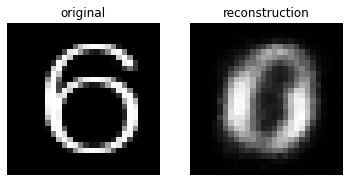

Generate a random image from the model:


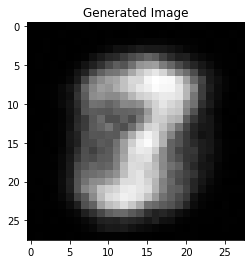

Intended digit:  3
Intended as handwritten:  False
Epoch: 1 average training loss: 151.86559905548097
Epoch: 2 average training loss: 137.2218260940552
Epoch: 3 average training loss: 128.95070014801024
Epoch: 4 average training loss: 123.89026043243408
Epoch: 5 average training loss: 120.14327785797119
Epoch: 6 average training loss: 117.31855605621338
Epoch: 7 average training loss: 115.31351584014892
Epoch: 8 average training loss: 113.69195038604737
Epoch: 9 average training loss: 112.47889799346923
Epoch: 10 average training loss: 111.36286418609619
Epoch: 10 average test loss: 111.65883732299805
Comparing a random test image to its reconstruction:


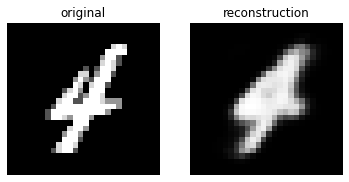

Generate a random image from the model:


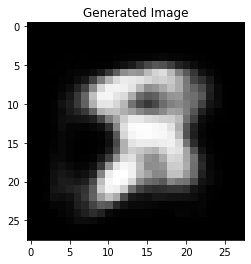

Intended digit:  8
Intended as handwritten:  False
Epoch: 11 average training loss: 110.44906828155517
Epoch: 12 average training loss: 109.6752042251587
Epoch: 13 average training loss: 108.98875251617432
Epoch: 14 average training loss: 108.45716366119385
Epoch: 15 average training loss: 107.89473307647705
Epoch: 16 average training loss: 107.38603999786378
Epoch: 17 average training loss: 106.96519778594971
Epoch: 18 average training loss: 106.62311065826417
Epoch: 19 average training loss: 106.21216271514892
Epoch: 20 average training loss: 105.90023936309815
Epoch: 20 average test loss: 106.64014437866211
Comparing a random test image to its reconstruction:


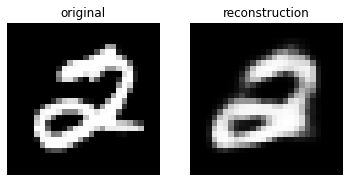

Generate a random image from the model:


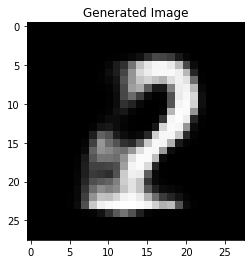

Intended digit:  2
Intended as handwritten:  False
Epoch: 21 average training loss: 105.61238598175049
Epoch: 22 average training loss: 105.27554794464112
Epoch: 23 average training loss: 105.0686172744751
Epoch: 24 average training loss: 104.79044749908448
Epoch: 25 average training loss: 104.5701308303833
Epoch: 26 average training loss: 104.37326398468018
Epoch: 27 average training loss: 104.14809893341065
Epoch: 28 average training loss: 103.92977657012939
Epoch: 29 average training loss: 103.79077140655518
Epoch: 30 average training loss: 103.58637796173096
Epoch: 30 average test loss: 104.56049095458984
Comparing a random test image to its reconstruction:


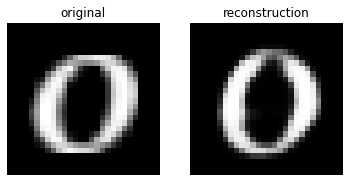

Generate a random image from the model:


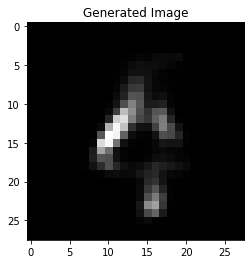

Intended digit:  4
Intended as handwritten:  False
Epoch: 31 average training loss: 103.38188377838135
Epoch: 32 average training loss: 103.2904647781372
Epoch: 33 average training loss: 103.07770666656494
Epoch: 34 average training loss: 102.95290314483643
Epoch: 35 average training loss: 102.77453913116454
Epoch: 36 average training loss: 102.70318546905517
Epoch: 37 average training loss: 102.54208881378173
Epoch: 38 average training loss: 102.43001796417236
Epoch: 39 average training loss: 102.32072451324463
Epoch: 40 average training loss: 102.18957116851807
Epoch: 40 average test loss: 103.46646184082032
Comparing a random test image to its reconstruction:


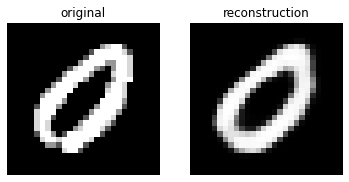

Generate a random image from the model:


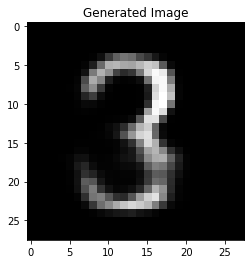

Intended digit:  3
Intended as handwritten:  False
Epoch: 41 average training loss: 102.074043989563
Epoch: 42 average training loss: 101.97762890167236
Epoch: 43 average training loss: 101.86841656036377
Epoch: 44 average training loss: 101.74355924224854
Epoch: 45 average training loss: 101.71247819366455
Epoch: 46 average training loss: 101.56429710235595
Epoch: 47 average training loss: 101.45348585968017
Epoch: 48 average training loss: 101.43877433624267
Epoch: 49 average training loss: 101.32295089874268
Epoch: 50 average training loss: 101.2272370437622
Epoch: 50 average test loss: 102.60112984619141
Comparing a random test image to its reconstruction:


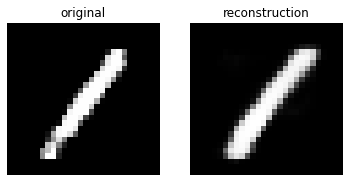

Generate a random image from the model:


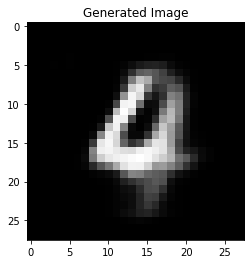

Intended digit:  4
Intended as handwritten:  False
Epoch: 51 average training loss: 101.178615284729
Epoch: 52 average training loss: 101.09609099273682
Epoch: 53 average training loss: 100.98735068511962
Epoch: 54 average training loss: 100.90620103302003
Epoch: 55 average training loss: 100.84974796905517
Epoch: 56 average training loss: 100.78730573272705
Epoch: 57 average training loss: 100.71532554473877
Epoch: 58 average training loss: 100.65887736968995
Epoch: 59 average training loss: 100.61986260528565
Epoch: 60 average training loss: 100.55238916778565
Epoch: 60 average test loss: 101.90274255371094
Comparing a random test image to its reconstruction:


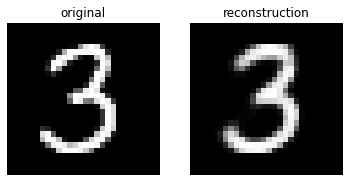

Generate a random image from the model:


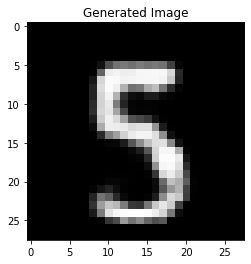

Intended digit:  5
Intended as handwritten:  False
Epoch: 61 average training loss: 100.52214103546143
Epoch: 62 average training loss: 100.41229991607666
Epoch: 63 average training loss: 100.35949066925049
Epoch: 64 average training loss: 100.30443889923096
Epoch: 65 average training loss: 100.26216841583252
Epoch: 66 average training loss: 100.20133947296142
Epoch: 67 average training loss: 100.15829242706299
Epoch: 68 average training loss: 100.10117636260986
Epoch: 69 average training loss: 100.04680414581298
Epoch: 70 average training loss: 100.00829412994385
Epoch: 70 average test loss: 101.49688807373047
Comparing a random test image to its reconstruction:


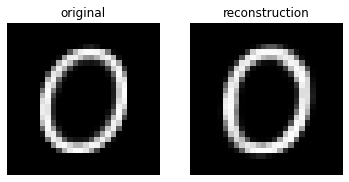

Generate a random image from the model:


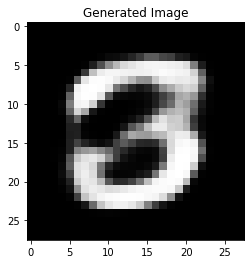

Intended digit:  3
Intended as handwritten:  False
Epoch: 71 average training loss: 99.93585569000244
Epoch: 72 average training loss: 99.93848341217041
Epoch: 73 average training loss: 99.87142233428955
Epoch: 74 average training loss: 99.82098251495361
Epoch: 75 average training loss: 99.81331157379151
Epoch: 76 average training loss: 99.72984130401612
Epoch: 77 average training loss: 99.68068603057861
Epoch: 78 average training loss: 99.62993870391846
Epoch: 79 average training loss: 99.64077765045165
Epoch: 80 average training loss: 99.54163924713134
Epoch: 80 average test loss: 101.14719819335937
Comparing a random test image to its reconstruction:


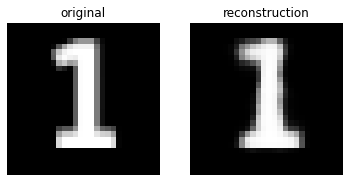

Generate a random image from the model:


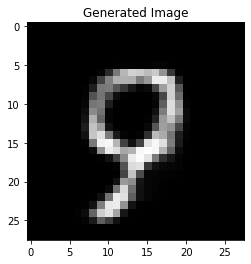

Intended digit:  9
Intended as handwritten:  False
Epoch: 81 average training loss: 99.5199597366333
Epoch: 82 average training loss: 99.46608398590088
Epoch: 83 average training loss: 99.49909948272705
Epoch: 84 average training loss: 99.43220464630127
Epoch: 85 average training loss: 99.36615373077393
Epoch: 86 average training loss: 99.32768704376221
Epoch: 87 average training loss: 99.32749854888915
Epoch: 88 average training loss: 99.2840923904419
Epoch: 89 average training loss: 99.22055513458253
Epoch: 90 average training loss: 99.17990159454345
Epoch: 90 average test loss: 101.10947160644531
Comparing a random test image to its reconstruction:


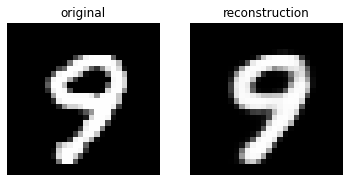

Generate a random image from the model:


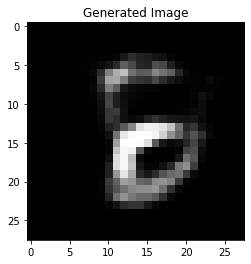

Intended digit:  6
Intended as handwritten:  False
Epoch: 91 average training loss: 99.16953698272705
Epoch: 92 average training loss: 99.10097074737548
Epoch: 93 average training loss: 99.12028435821533
Epoch: 94 average training loss: 99.08706342315674
Epoch: 95 average training loss: 99.01529280548095
Epoch: 96 average training loss: 98.9962475479126
Epoch: 97 average training loss: 98.96786197662354
Epoch: 98 average training loss: 98.88387472686767
Epoch: 99 average training loss: 98.90664528961182
Epoch: 100 average training loss: 98.86702321319581
Epoch: 100 average test loss: 100.64082999267578
Comparing a random test image to its reconstruction:


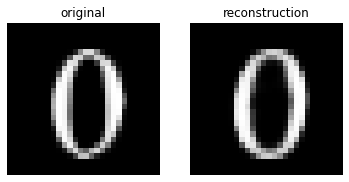

Generate a random image from the model:


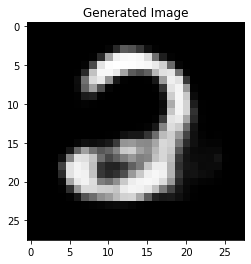

Intended digit:  2
Intended as handwritten:  False
Epoch: 101 average training loss: 98.86176369171143
Epoch: 102 average training loss: 98.81744916534424
Epoch: 103 average training loss: 98.79994713897705
Epoch: 104 average training loss: 98.72312175445556
Epoch: 105 average training loss: 98.71192223052978
Epoch: 106 average training loss: 98.68574773712159
Epoch: 107 average training loss: 98.6705293106079
Epoch: 108 average training loss: 98.65864363555909
Epoch: 109 average training loss: 98.59084503936768
Epoch: 110 average training loss: 98.54180471954346
Epoch: 110 average test loss: 100.34646810913085
Comparing a random test image to its reconstruction:


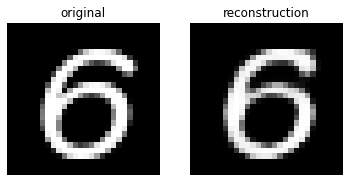

Generate a random image from the model:


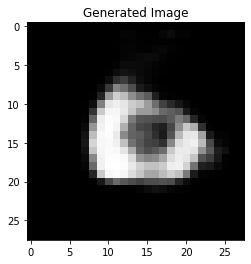

Intended digit:  6
Intended as handwritten:  False
Epoch: 111 average training loss: 98.5661159072876
Epoch: 112 average training loss: 98.52563826446533
Epoch: 113 average training loss: 98.53526963653565
Epoch: 114 average training loss: 98.46678255157471
Epoch: 115 average training loss: 98.44360041656495
Epoch: 116 average training loss: 98.41982686309814
Epoch: 117 average training loss: 98.43108639068603
Epoch: 118 average training loss: 98.37024311065674
Epoch: 119 average training loss: 98.33939256134033
Epoch: 120 average training loss: 98.32229381256103
Epoch: 120 average test loss: 100.09441889648437
Comparing a random test image to its reconstruction:


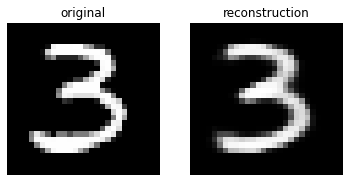

Generate a random image from the model:


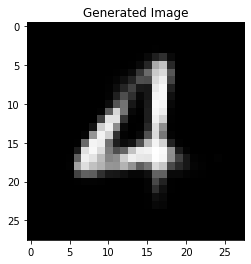

Intended digit:  4
Intended as handwritten:  False
Epoch: 121 average training loss: 98.30300955352783
Epoch: 122 average training loss: 98.26630271148682
Epoch: 123 average training loss: 98.25187912750245
Epoch: 124 average training loss: 98.21055331573487
Epoch: 125 average training loss: 98.17030038604736
Epoch: 126 average training loss: 98.17332266387939
Epoch: 127 average training loss: 98.17462644805909
Epoch: 128 average training loss: 98.14646214141845
Epoch: 129 average training loss: 98.10290006866455
Epoch: 130 average training loss: 98.10964925079345
Epoch: 130 average test loss: 100.01031107788086
Comparing a random test image to its reconstruction:


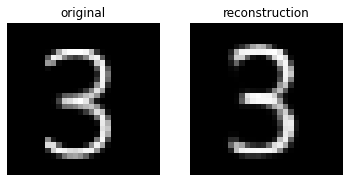

Generate a random image from the model:


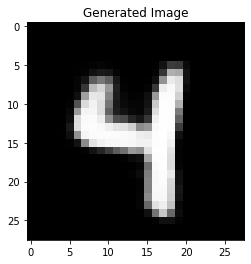

Intended digit:  4
Intended as handwritten:  False
Epoch: 131 average training loss: 98.04697353057861
Epoch: 132 average training loss: 98.014388722229
Epoch: 133 average training loss: 98.01025418243408
Epoch: 134 average training loss: 97.96892621612548
Epoch: 135 average training loss: 97.96819848175049
Epoch: 136 average training loss: 97.96514698028564
Epoch: 137 average training loss: 97.92422032623291
Epoch: 138 average training loss: 97.95370535430908
Epoch: 139 average training loss: 97.90175121612549
Epoch: 140 average training loss: 97.89740988311767
Epoch: 140 average test loss: 99.69910886230468
Comparing a random test image to its reconstruction:


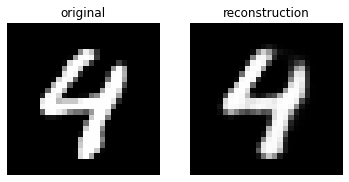

Generate a random image from the model:


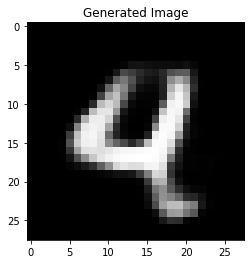

Intended digit:  4
Intended as handwritten:  False
Epoch: 141 average training loss: 97.87877965850831
Epoch: 142 average training loss: 97.84731874542236
Epoch: 143 average training loss: 97.81769466705322
Epoch: 144 average training loss: 97.77501167144776
Epoch: 145 average training loss: 97.78921359405517
Epoch: 146 average training loss: 97.76899420928954
Epoch: 147 average training loss: 97.73256286773682
Epoch: 148 average training loss: 97.70930728302002
Epoch: 149 average training loss: 97.6745238357544
Epoch: 150 average training loss: 97.65875388336181
Epoch: 150 average test loss: 99.82490349121093
Comparing a random test image to its reconstruction:


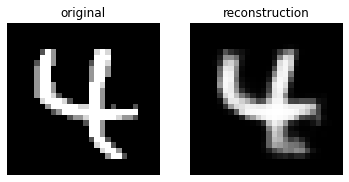

Generate a random image from the model:


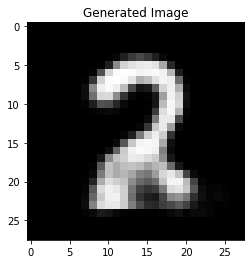

Intended digit:  2
Intended as handwritten:  False
Epoch: 151 average training loss: 97.6875634841919
Epoch: 152 average training loss: 97.63680769805909
Epoch: 153 average training loss: 97.59253759307862
Epoch: 154 average training loss: 97.61493428497315
Epoch: 155 average training loss: 97.57412512969971
Epoch: 156 average training loss: 97.54584662628174
Epoch: 157 average training loss: 97.57689540557861
Epoch: 158 average training loss: 97.52868760528564
Epoch: 159 average training loss: 97.48486893463135
Epoch: 160 average training loss: 97.47854429473877
Epoch: 160 average test loss: 99.53371458740234
Comparing a random test image to its reconstruction:


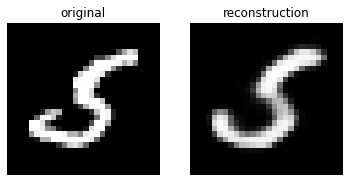

Generate a random image from the model:


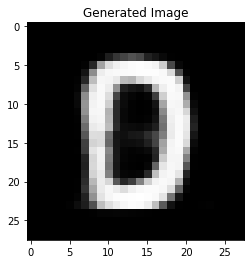

Intended digit:  0
Intended as handwritten:  False
Epoch: 161 average training loss: 97.49038288726807
Epoch: 162 average training loss: 97.46611748809815
Epoch: 163 average training loss: 97.41597760772706
Epoch: 164 average training loss: 97.40061646270752
Epoch: 165 average training loss: 97.42421482086182
Epoch: 166 average training loss: 97.3998476638794
Epoch: 167 average training loss: 97.37243402252197
Epoch: 168 average training loss: 97.3780679397583
Epoch: 169 average training loss: 97.34110561676026
Epoch: 170 average training loss: 97.32198122711182
Epoch: 170 average test loss: 99.42998303222656
Comparing a random test image to its reconstruction:


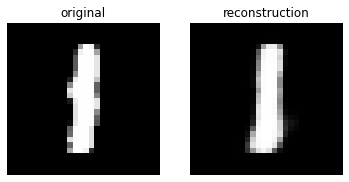

Generate a random image from the model:


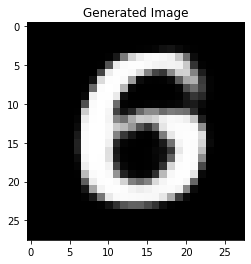

Intended digit:  6
Intended as handwritten:  False
Epoch: 171 average training loss: 97.30959822540284
Epoch: 172 average training loss: 97.29405982208252
Epoch: 173 average training loss: 97.25373800811768
Epoch: 174 average training loss: 97.26185735626221
Epoch: 175 average training loss: 97.27111632843018
Epoch: 176 average training loss: 97.22310953521729
Epoch: 177 average training loss: 97.21477699127198
Epoch: 178 average training loss: 97.20101452178955
Epoch: 179 average training loss: 97.20607970733643
Epoch: 180 average training loss: 97.18523886260986
Epoch: 180 average test loss: 99.30872575073242
Comparing a random test image to its reconstruction:


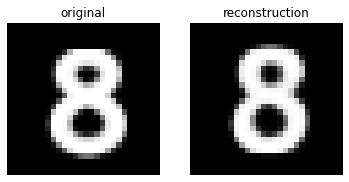

Generate a random image from the model:


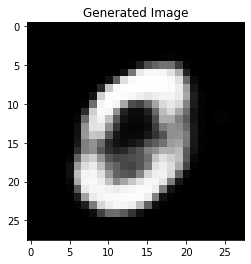

Intended digit:  0
Intended as handwritten:  False
Epoch: 181 average training loss: 97.16267179718018
Epoch: 182 average training loss: 97.14491365509033
Epoch: 183 average training loss: 97.12948549346923
Epoch: 184 average training loss: 97.1244145767212
Epoch: 185 average training loss: 97.0900662979126
Epoch: 186 average training loss: 97.08190272979736
Epoch: 187 average training loss: 97.0529573928833
Epoch: 188 average training loss: 97.08315594024658
Epoch: 189 average training loss: 97.09131244659424
Epoch: 190 average training loss: 97.00120105743409
Epoch: 190 average test loss: 99.03602663574219
Comparing a random test image to its reconstruction:


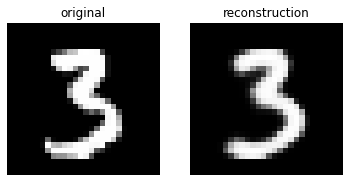

Generate a random image from the model:


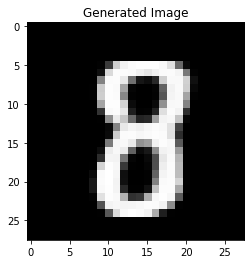

Intended digit:  8
Intended as handwritten:  False
Epoch: 191 average training loss: 97.0296406326294
Epoch: 192 average training loss: 96.99132398223877
Epoch: 193 average training loss: 96.99304357452392
Epoch: 194 average training loss: 96.96769562530518
Epoch: 195 average training loss: 96.95339107208252
Epoch: 196 average training loss: 96.91575080108643
Epoch: 197 average training loss: 96.90999481964111
Epoch: 198 average training loss: 96.8926788772583
Epoch: 199 average training loss: 96.93313162384034
Epoch: 200 average training loss: 96.87361491241455
Epoch: 200 average test loss: 99.10335556640625
Comparing a random test image to its reconstruction:


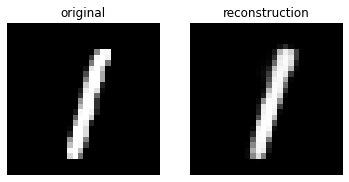

Generate a random image from the model:


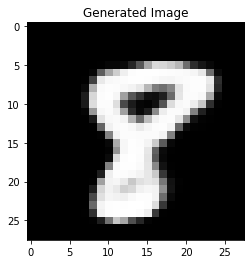

Intended digit:  8
Intended as handwritten:  False
Epoch: 201 average training loss: 96.8724162979126
Epoch: 202 average training loss: 96.86034240264893
Epoch: 203 average training loss: 96.842371925354
Epoch: 204 average training loss: 96.80034115753173
Epoch: 205 average training loss: 96.84974129180908
Epoch: 206 average training loss: 96.75049226837159
Epoch: 207 average training loss: 96.76488793487549
Epoch: 208 average training loss: 96.7636279373169
Epoch: 209 average training loss: 96.78148715972901
Epoch: 210 average training loss: 96.7394546218872
Epoch: 210 average test loss: 98.98785227050782
Comparing a random test image to its reconstruction:


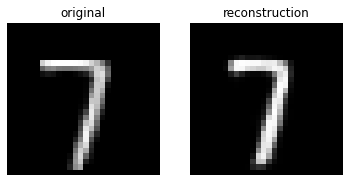

Generate a random image from the model:


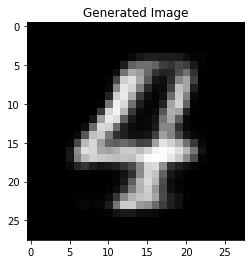

Intended digit:  4
Intended as handwritten:  False
Epoch: 211 average training loss: 96.78095491485595
Epoch: 212 average training loss: 96.70571016387939
Epoch: 213 average training loss: 96.72033889923095
Epoch: 214 average training loss: 96.72893783721923
Epoch: 215 average training loss: 96.70312210235596
Epoch: 216 average training loss: 96.6753564163208
Epoch: 217 average training loss: 96.68767071075439
Epoch: 218 average training loss: 96.66202364044189
Epoch: 219 average training loss: 96.63428350372314
Epoch: 220 average training loss: 96.66128418121338
Epoch: 220 average test loss: 98.79485786132813
Comparing a random test image to its reconstruction:


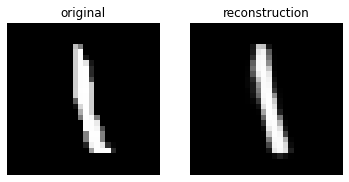

Generate a random image from the model:


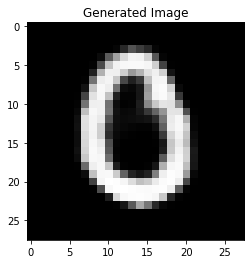

Intended digit:  0
Intended as handwritten:  False
Epoch: 221 average training loss: 96.60875248565674
Epoch: 222 average training loss: 96.6251665725708
Epoch: 223 average training loss: 96.59369095611572
Epoch: 224 average training loss: 96.56710116729737
Epoch: 225 average training loss: 96.5727067703247
Epoch: 226 average training loss: 96.57462447052002
Epoch: 227 average training loss: 96.51366568145752
Epoch: 228 average training loss: 96.57432198028565
Epoch: 229 average training loss: 96.5335509048462
Epoch: 230 average training loss: 96.54127580108643
Epoch: 230 average test loss: 98.85750754394532
Comparing a random test image to its reconstruction:


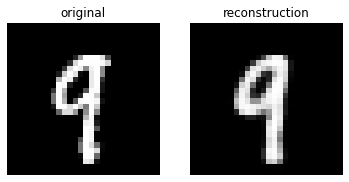

Generate a random image from the model:


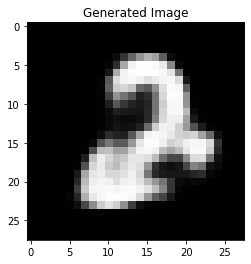

Intended digit:  2
Intended as handwritten:  False
Epoch: 231 average training loss: 96.52868654937744
Epoch: 232 average training loss: 96.51106127471924
Epoch: 233 average training loss: 96.50286522369385
Epoch: 234 average training loss: 96.46348829498291
Epoch: 235 average training loss: 96.46213600616456
Epoch: 236 average training loss: 96.44100346221924
Epoch: 237 average training loss: 96.45786939239503
Epoch: 238 average training loss: 96.4412927444458
Epoch: 239 average training loss: 96.4056015335083
Epoch: 240 average training loss: 96.43586259307861
Epoch: 240 average test loss: 98.64220227050781
Comparing a random test image to its reconstruction:


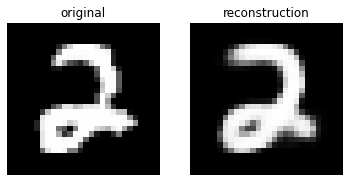

Generate a random image from the model:


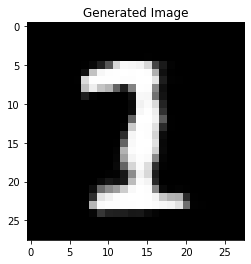

Intended digit:  1
Intended as handwritten:  False
Epoch: 241 average training loss: 96.43362942657471
Epoch: 242 average training loss: 96.41784532623291
Epoch: 243 average training loss: 96.3474514175415
Epoch: 244 average training loss: 96.36171551055908
Epoch: 245 average training loss: 96.36736515655518
Epoch: 246 average training loss: 96.34735939483643
Epoch: 247 average training loss: 96.36762232818603
Epoch: 248 average training loss: 96.34965428619385
Epoch: 249 average training loss: 96.3184875869751
Epoch: 250 average training loss: 96.28570238800049
Epoch: 250 average test loss: 98.645462890625
Comparing a random test image to its reconstruction:


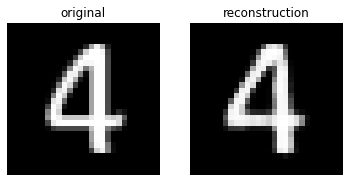

Generate a random image from the model:


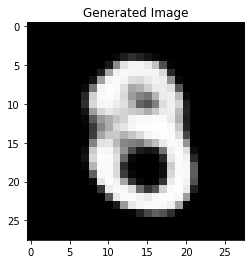

Intended digit:  8
Intended as handwritten:  False
Epoch: 251 average training loss: 96.28664169464112
Epoch: 252 average training loss: 96.28737078399658
Epoch: 253 average training loss: 96.30423698272705
Epoch: 254 average training loss: 96.258729347229
Epoch: 255 average training loss: 96.269022706604
Epoch: 256 average training loss: 96.28581504058837
Epoch: 257 average training loss: 96.2505158279419
Epoch: 258 average training loss: 96.2175858291626
Epoch: 259 average training loss: 96.21918950958252
Epoch: 260 average training loss: 96.22482619781493
Epoch: 260 average test loss: 98.73246512451172
Comparing a random test image to its reconstruction:


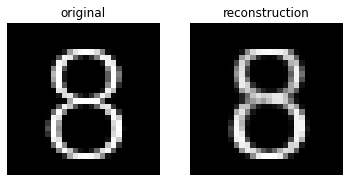

Generate a random image from the model:


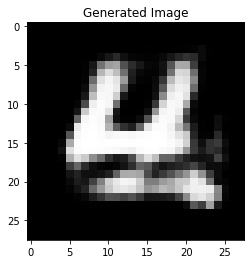

Intended digit:  4
Intended as handwritten:  False
Epoch: 261 average training loss: 96.19942215118408
Epoch: 262 average training loss: 96.19230635528564
Epoch: 263 average training loss: 96.1913537185669
Epoch: 264 average training loss: 96.15056477813721
Epoch: 265 average training loss: 96.14717867584228
Epoch: 266 average training loss: 96.13983980255126
Epoch: 267 average training loss: 96.12166857452392
Epoch: 268 average training loss: 96.13838698883056
Epoch: 269 average training loss: 96.1352496963501
Epoch: 270 average training loss: 96.08976111602783
Epoch: 270 average test loss: 98.54776716918946
Comparing a random test image to its reconstruction:


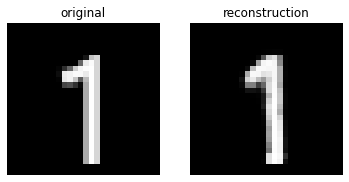

Generate a random image from the model:


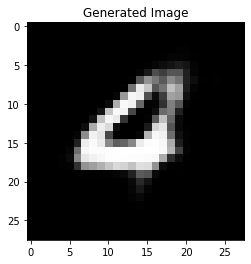

Intended digit:  4
Intended as handwritten:  False
Epoch: 271 average training loss: 96.1111839920044
Epoch: 272 average training loss: 96.1079577102661
Epoch: 273 average training loss: 96.09083603057861
Epoch: 274 average training loss: 96.11828357696533
Epoch: 275 average training loss: 96.07447621612549
Epoch: 276 average training loss: 96.06766698760987
Epoch: 277 average training loss: 96.04680509796142
Epoch: 278 average training loss: 96.03783930206299
Epoch: 279 average training loss: 96.06745436553955
Epoch: 280 average training loss: 96.06136010284423
Epoch: 280 average test loss: 98.49083228759766
Comparing a random test image to its reconstruction:


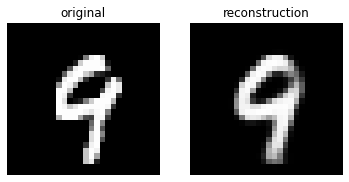

Generate a random image from the model:


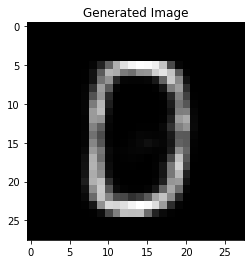

Intended digit:  0
Intended as handwritten:  False
Epoch: 281 average training loss: 96.03718662261963
Epoch: 282 average training loss: 96.00166630401611
Epoch: 283 average training loss: 96.0182479812622
Epoch: 284 average training loss: 95.98932149810791
Epoch: 285 average training loss: 95.99262034454345
Epoch: 286 average training loss: 95.98573485870361
Epoch: 287 average training loss: 95.97311532745361
Epoch: 288 average training loss: 95.96915044708253
Epoch: 289 average training loss: 95.928488911438
Epoch: 290 average training loss: 95.95935581207276
Epoch: 290 average test loss: 98.45259008789063
Comparing a random test image to its reconstruction:


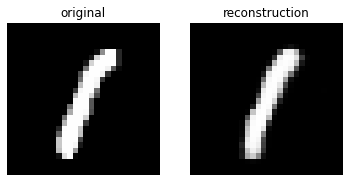

Generate a random image from the model:


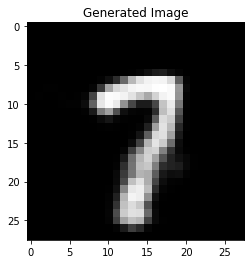

Intended digit:  7
Intended as handwritten:  False
Epoch: 291 average training loss: 95.91751374664307
Epoch: 292 average training loss: 95.95572373199462
Epoch: 293 average training loss: 95.93454239044189
Epoch: 294 average training loss: 95.9025629776001
Epoch: 295 average training loss: 95.89985476226806
Epoch: 296 average training loss: 95.92137830963135
Epoch: 297 average training loss: 95.90355021514893
Epoch: 298 average training loss: 95.91260992584229
Epoch: 299 average training loss: 95.85952397003174
Epoch: 300 average training loss: 95.85581233673096
Epoch: 300 average test loss: 98.48862067871094
Comparing a random test image to its reconstruction:


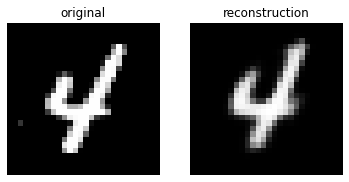

Generate a random image from the model:


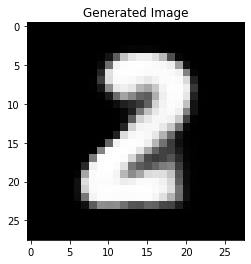

Intended digit:  2
Intended as handwritten:  False
Epoch: 301 average training loss: 95.83313032989501
Epoch: 302 average training loss: 95.89467340240479
Epoch: 303 average training loss: 95.88091881866455
Epoch: 304 average training loss: 95.84131408233642
Epoch: 305 average training loss: 95.81729328155518
Epoch: 306 average training loss: 95.81582362213135
Epoch: 307 average training loss: 95.80659459991455
Epoch: 308 average training loss: 95.78589066925049
Epoch: 309 average training loss: 95.79467904815674
Epoch: 310 average training loss: 95.78409145050048
Epoch: 310 average test loss: 98.44860716552735
Comparing a random test image to its reconstruction:


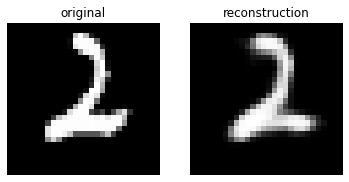

Generate a random image from the model:


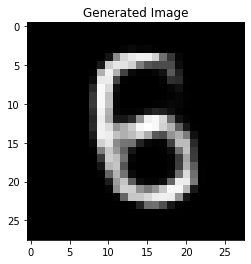

Intended digit:  6
Intended as handwritten:  False
Epoch: 311 average training loss: 95.80928394317627
Epoch: 312 average training loss: 95.7945321609497
Epoch: 313 average training loss: 95.75998078155517
Epoch: 314 average training loss: 95.76741580352783
Epoch: 315 average training loss: 95.73176789703369
Epoch: 316 average training loss: 95.7523811843872
Epoch: 317 average training loss: 95.7590450515747
Epoch: 318 average training loss: 95.72872530059814
Epoch: 319 average training loss: 95.74900080108642
Epoch: 320 average training loss: 95.71558831939697
Epoch: 320 average test loss: 98.35874956054687
Comparing a random test image to its reconstruction:


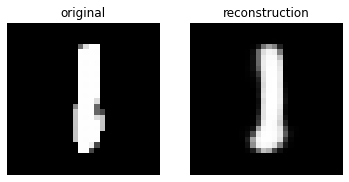

Generate a random image from the model:


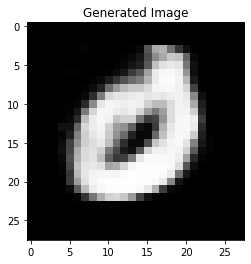

Intended digit:  0
Intended as handwritten:  False
Epoch: 321 average training loss: 95.69845279083252
Epoch: 322 average training loss: 95.7068118484497
Epoch: 323 average training loss: 95.71659546661377
Epoch: 324 average training loss: 95.66714846343994
Epoch: 325 average training loss: 95.68221842803955
Epoch: 326 average training loss: 95.68396591339112
Epoch: 327 average training loss: 95.67861356964112
Epoch: 328 average training loss: 95.65554436798095
Epoch: 329 average training loss: 95.65705988311768
Epoch: 330 average training loss: 95.65969176177978
Epoch: 330 average test loss: 98.2184760986328
Comparing a random test image to its reconstruction:


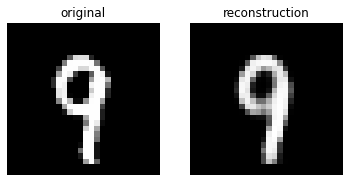

Generate a random image from the model:


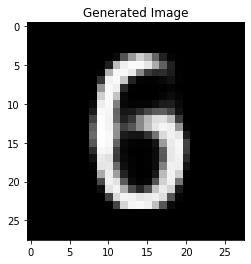

Intended digit:  6
Intended as handwritten:  False
Epoch: 331 average training loss: 95.63624967803955
Epoch: 332 average training loss: 95.63478330841065
Epoch: 333 average training loss: 95.65339737091064
Epoch: 334 average training loss: 95.63010425567627
Epoch: 335 average training loss: 95.65826043243408
Epoch: 336 average training loss: 95.60035431671143
Epoch: 337 average training loss: 95.62190904083252
Epoch: 338 average training loss: 95.5743561050415
Epoch: 339 average training loss: 95.57719414215087
Epoch: 340 average training loss: 95.6100697341919
Epoch: 340 average test loss: 98.20817164306641
Comparing a random test image to its reconstruction:


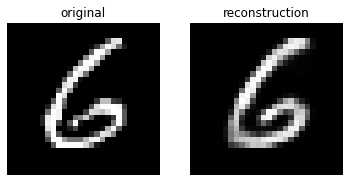

Generate a random image from the model:


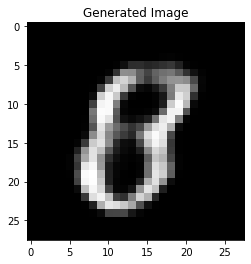

Intended digit:  8
Intended as handwritten:  False
Epoch: 341 average training loss: 95.5832598526001
Epoch: 342 average training loss: 95.5858132156372
Epoch: 343 average training loss: 95.56809096221924
Epoch: 344 average training loss: 95.55465058746339
Epoch: 345 average training loss: 95.54860788116456
Epoch: 346 average training loss: 95.53313547515869
Epoch: 347 average training loss: 95.51447646026611
Epoch: 348 average training loss: 95.52686067657471
Epoch: 349 average training loss: 95.49763553619385
Epoch: 350 average training loss: 95.51672003936767
Epoch: 350 average test loss: 98.15546853637696
Comparing a random test image to its reconstruction:


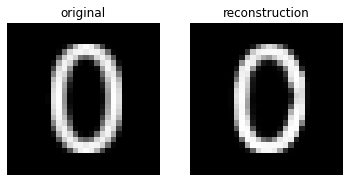

Generate a random image from the model:


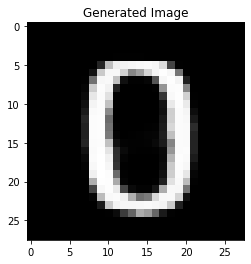

Intended digit:  0
Intended as handwritten:  False
Epoch: 351 average training loss: 95.5378109451294
Epoch: 352 average training loss: 95.48500263214112
Epoch: 353 average training loss: 95.48445863800049
Epoch: 354 average training loss: 95.50229967193603
Epoch: 355 average training loss: 95.51437139434815
Epoch: 356 average training loss: 95.51177592315673
Epoch: 357 average training loss: 95.47378147735596
Epoch: 358 average training loss: 95.46298062286377
Epoch: 359 average training loss: 95.46833308258057
Epoch: 360 average training loss: 95.45785750274658
Epoch: 360 average test loss: 98.08201904296875
Comparing a random test image to its reconstruction:


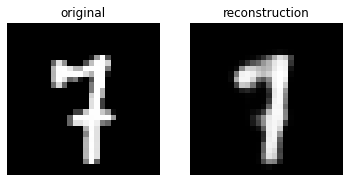

Generate a random image from the model:


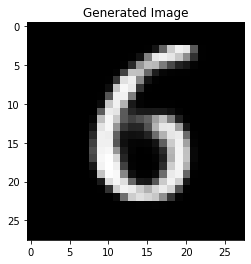

Intended digit:  6
Intended as handwritten:  False
Epoch: 361 average training loss: 95.47336701202393
Epoch: 362 average training loss: 95.46556024932862
Epoch: 363 average training loss: 95.45731672515869
Epoch: 364 average training loss: 95.42540875396729
Epoch: 365 average training loss: 95.41833901519776
Epoch: 366 average training loss: 95.43055321807861
Epoch: 367 average training loss: 95.40889590606689
Epoch: 368 average training loss: 95.4260480911255
Epoch: 369 average training loss: 95.40727159576416
Epoch: 370 average training loss: 95.35748769683838
Epoch: 370 average test loss: 98.07203862304688
Comparing a random test image to its reconstruction:


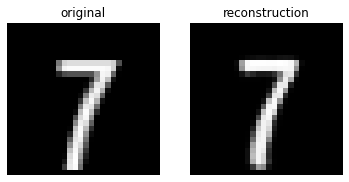

Generate a random image from the model:


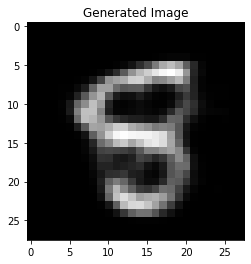

Intended digit:  8
Intended as handwritten:  False
Epoch: 371 average training loss: 95.38373470611572
Epoch: 372 average training loss: 95.37418625030517
Epoch: 373 average training loss: 95.37271459503174
Epoch: 374 average training loss: 95.34399284210205
Epoch: 375 average training loss: 95.34858955230713
Epoch: 376 average training loss: 95.35111055450439
Epoch: 377 average training loss: 95.39043712921142
Epoch: 378 average training loss: 95.35562741241455
Epoch: 379 average training loss: 95.37047638702393
Epoch: 380 average training loss: 95.3400735244751
Epoch: 380 average test loss: 98.15987113037109
Comparing a random test image to its reconstruction:


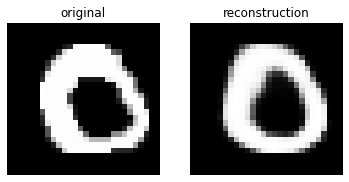

Generate a random image from the model:


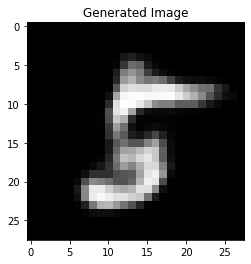

Intended digit:  5
Intended as handwritten:  False
Epoch: 381 average training loss: 95.31786516265869
Epoch: 382 average training loss: 95.31778972320556
Epoch: 383 average training loss: 95.30297908477783
Epoch: 384 average training loss: 95.29507710723877
Epoch: 385 average training loss: 95.30394385528564
Epoch: 386 average training loss: 95.30928023223876
Epoch: 387 average training loss: 95.31140994415283
Epoch: 388 average training loss: 95.29147253570557
Epoch: 389 average training loss: 95.29699170684815
Epoch: 390 average training loss: 95.29370532989502
Epoch: 390 average test loss: 97.99438221435547
Comparing a random test image to its reconstruction:


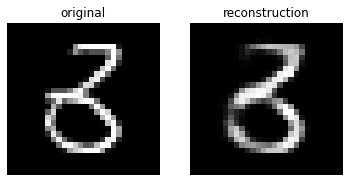

Generate a random image from the model:


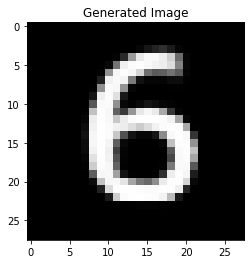

Intended digit:  6
Intended as handwritten:  False
Epoch: 391 average training loss: 95.24354143218994
Epoch: 392 average training loss: 95.26963435821533
Epoch: 393 average training loss: 95.24592372589112
Epoch: 394 average training loss: 95.25467638092042
Epoch: 395 average training loss: 95.24626236114501
Epoch: 396 average training loss: 95.22059378204345
Epoch: 397 average training loss: 95.23287261505126
Epoch: 398 average training loss: 95.26838969879151
Epoch: 399 average training loss: 95.24561038360596
Epoch: 400 average training loss: 95.238227973938
Epoch: 400 average test loss: 98.0652944946289
Comparing a random test image to its reconstruction:


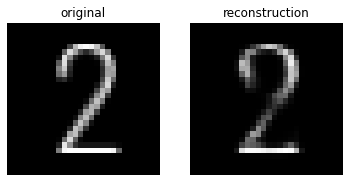

Generate a random image from the model:


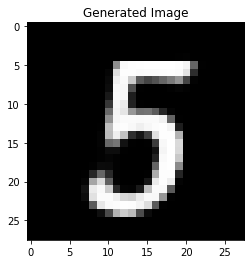

Intended digit:  5
Intended as handwritten:  False
Epoch: 401 average training loss: 95.21684165802002
Epoch: 402 average training loss: 95.21441331329346
Epoch: 403 average training loss: 95.18750849151611
Epoch: 404 average training loss: 95.21403361968994
Epoch: 405 average training loss: 95.20841488800049
Epoch: 406 average training loss: 95.1758267288208
Epoch: 407 average training loss: 95.16654468536377
Epoch: 408 average training loss: 95.16638811798096
Epoch: 409 average training loss: 95.18452835845947
Epoch: 410 average training loss: 95.1731165359497
Epoch: 410 average test loss: 97.9505275390625
Comparing a random test image to its reconstruction:


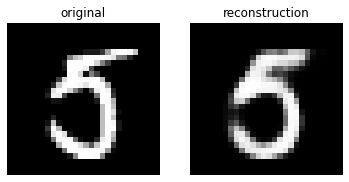

Generate a random image from the model:


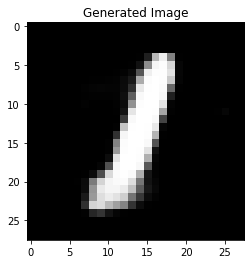

Intended digit:  1
Intended as handwritten:  False
Epoch: 411 average training loss: 95.16906873321533
Epoch: 412 average training loss: 95.18726453399658
Epoch: 413 average training loss: 95.1407566482544
Epoch: 414 average training loss: 95.14108098907471
Epoch: 415 average training loss: 95.15906038970947
Epoch: 416 average training loss: 95.15958175811768
Epoch: 417 average training loss: 95.14069523468018
Epoch: 418 average training loss: 95.14707877349854
Epoch: 419 average training loss: 95.13507710723877
Epoch: 420 average training loss: 95.13435093536377
Epoch: 420 average test loss: 97.93553171386719
Comparing a random test image to its reconstruction:


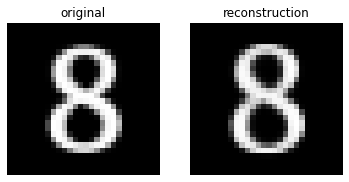

Generate a random image from the model:


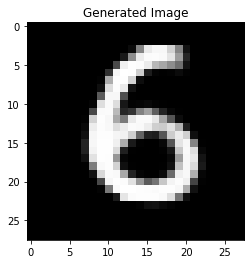

Intended digit:  6
Intended as handwritten:  False
Epoch: 421 average training loss: 95.1336731338501
Epoch: 422 average training loss: 95.11400336456299
Epoch: 423 average training loss: 95.1357222793579
Epoch: 424 average training loss: 95.1013327102661
Epoch: 425 average training loss: 95.08830086212159
Epoch: 426 average training loss: 95.10528357696533
Epoch: 427 average training loss: 95.08719888458252
Epoch: 428 average training loss: 95.05801809844971
Epoch: 429 average training loss: 95.09461794586181
Epoch: 430 average training loss: 95.05717733306885
Epoch: 430 average test loss: 97.98038301391601
Comparing a random test image to its reconstruction:


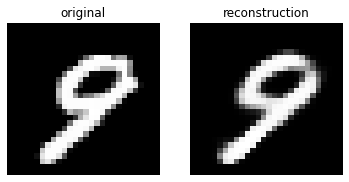

Generate a random image from the model:


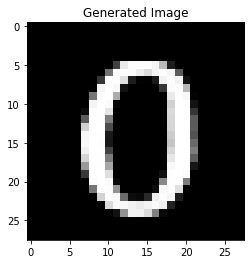

Intended digit:  0
Intended as handwritten:  False
Epoch: 431 average training loss: 95.0645216140747
Epoch: 432 average training loss: 95.0846570388794
Epoch: 433 average training loss: 95.06765639190674
Epoch: 434 average training loss: 95.04798990020753
Epoch: 435 average training loss: 95.05663227081298
Epoch: 436 average training loss: 95.05828465118408
Epoch: 437 average training loss: 95.07720266876221
Epoch: 438 average training loss: 95.02684026031494
Epoch: 439 average training loss: 95.01375163116455
Epoch: 440 average training loss: 95.02254557647706
Epoch: 440 average test loss: 97.93714848632813
Comparing a random test image to its reconstruction:


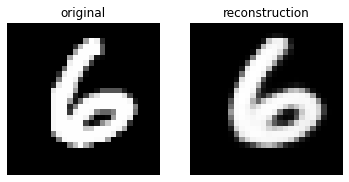

Generate a random image from the model:


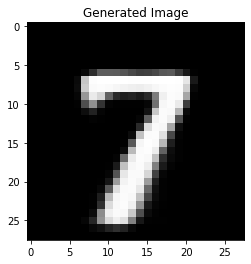

Intended digit:  7
Intended as handwritten:  False
Epoch: 441 average training loss: 95.01532740020752
Epoch: 442 average training loss: 95.00404460601807
Epoch: 443 average training loss: 95.00401851348877
Epoch: 444 average training loss: 94.98624849395752
Epoch: 445 average training loss: 95.03417788848877
Epoch: 446 average training loss: 95.00356096954346
Epoch: 447 average training loss: 95.00542510528564
Epoch: 448 average training loss: 94.98012405548096
Epoch: 449 average training loss: 95.0025511001587
Epoch: 450 average training loss: 95.00839632110596
Epoch: 450 average test loss: 97.9255373840332
Comparing a random test image to its reconstruction:


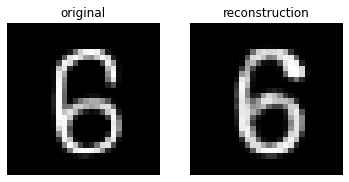

Generate a random image from the model:


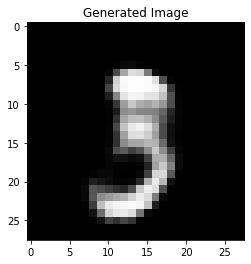

Intended digit:  3
Intended as handwritten:  False
Epoch: 451 average training loss: 94.96163761749267
Epoch: 452 average training loss: 94.98895846710205
Epoch: 453 average training loss: 94.97316403961182
Epoch: 454 average training loss: 94.92517810821533
Epoch: 455 average training loss: 94.98782923126221
Epoch: 456 average training loss: 94.95075083770752
Epoch: 457 average training loss: 94.93928045196533
Epoch: 458 average training loss: 94.95572839508057
Epoch: 459 average training loss: 94.9856504348755
Epoch: 460 average training loss: 94.9084972732544
Epoch: 460 average test loss: 98.02208829345703
Comparing a random test image to its reconstruction:


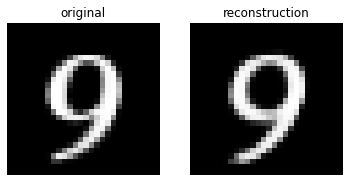

Generate a random image from the model:


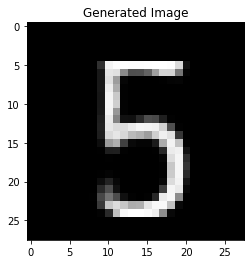

Intended digit:  5
Intended as handwritten:  False
Epoch: 461 average training loss: 94.92872105255127
Epoch: 462 average training loss: 94.96847792510987
Epoch: 463 average training loss: 94.93499711456299
Epoch: 464 average training loss: 94.91606616973877
Epoch: 465 average training loss: 94.9043515335083
Epoch: 466 average training loss: 94.91823980255127
Epoch: 467 average training loss: 94.91527448272706
Epoch: 468 average training loss: 94.90377646636964
Epoch: 469 average training loss: 94.94131889801025
Epoch: 470 average training loss: 94.90663049468994
Epoch: 470 average test loss: 98.05157373046875
Comparing a random test image to its reconstruction:


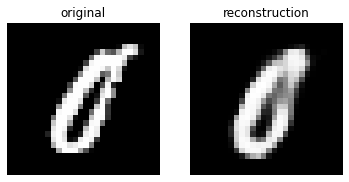

Generate a random image from the model:


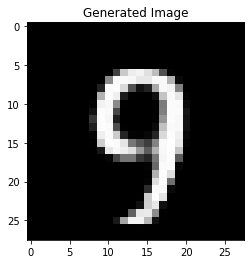

Intended digit:  9
Intended as handwritten:  False
Epoch: 471 average training loss: 94.87721176300049
Epoch: 472 average training loss: 94.88640912628173
Epoch: 473 average training loss: 94.91971998443603
Epoch: 474 average training loss: 94.88656363677978
Epoch: 475 average training loss: 94.87077057647706
Epoch: 476 average training loss: 94.89306829376221
Epoch: 477 average training loss: 94.8533659500122
Epoch: 478 average training loss: 94.87823060455322
Epoch: 479 average training loss: 94.8240859451294
Epoch: 480 average training loss: 94.82729865264892
Epoch: 480 average test loss: 97.96837911376953
Comparing a random test image to its reconstruction:


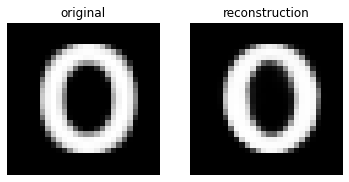

Generate a random image from the model:


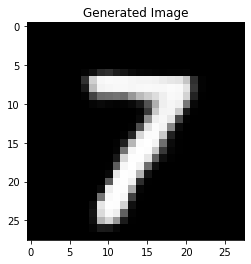

Intended digit:  7
Intended as handwritten:  False
Epoch: 481 average training loss: 94.85140460968017
Epoch: 482 average training loss: 94.85406230010986
Epoch: 483 average training loss: 94.84314208526611
Epoch: 484 average training loss: 94.82303081207276
Epoch: 485 average training loss: 94.82831084747315
Epoch: 486 average training loss: 94.83916256866455
Epoch: 487 average training loss: 94.83899850006104
Epoch: 488 average training loss: 94.81545965118409
Epoch: 489 average training loss: 94.80474240264893
Epoch: 490 average training loss: 94.84580779571533
Epoch: 490 average test loss: 97.9936767578125
Comparing a random test image to its reconstruction:


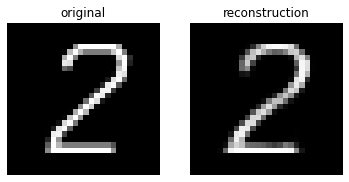

Generate a random image from the model:


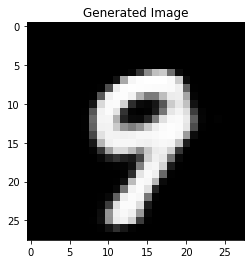

Intended digit:  9
Intended as handwritten:  False
Epoch: 491 average training loss: 94.79215349884034
Epoch: 492 average training loss: 94.8042858718872
Epoch: 493 average training loss: 94.77957974395751
Epoch: 494 average training loss: 94.82781707305908
Epoch: 495 average training loss: 94.76980363311768
Epoch: 496 average training loss: 94.80011553497314
Epoch: 497 average training loss: 94.78672649078369
Epoch: 498 average training loss: 94.79533330230713
Epoch: 499 average training loss: 94.75060718536378
Epoch: 500 average training loss: 94.77265729522705
Epoch: 500 average test loss: 97.7961448486328
Comparing a random test image to its reconstruction:


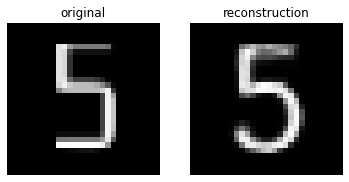

Generate a random image from the model:


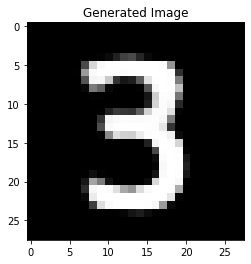

Intended digit:  3
Intended as handwritten:  False
Epoch: 501 average training loss: 94.75278386383057
Epoch: 502 average training loss: 94.75737749786377
Epoch: 503 average training loss: 94.75991374053955
Epoch: 504 average training loss: 94.75539088897705
Epoch: 505 average training loss: 94.72534704742432
Epoch: 506 average training loss: 94.71094345245362
Epoch: 507 average training loss: 94.73747569122314
Epoch: 508 average training loss: 94.71157462921143
Epoch: 509 average training loss: 94.7567090286255
Epoch: 510 average training loss: 94.71492784576417
Epoch: 510 average test loss: 97.78478026123047
Comparing a random test image to its reconstruction:


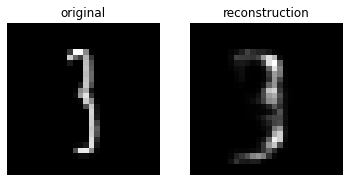

Generate a random image from the model:


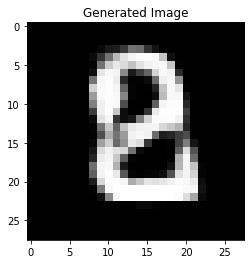

Intended digit:  2
Intended as handwritten:  False
Epoch: 511 average training loss: 94.71816324615479
Epoch: 512 average training loss: 94.73514770050049
Epoch: 513 average training loss: 94.72049077911377
Epoch: 514 average training loss: 94.72866847686768
Epoch: 515 average training loss: 94.71021845245362
Epoch: 516 average training loss: 94.666412940979
Epoch: 517 average training loss: 94.68362295074463
Epoch: 518 average training loss: 94.68579392242431
Epoch: 519 average training loss: 94.69662372589111
Epoch: 520 average training loss: 94.70551909332275
Epoch: 520 average test loss: 97.7714444580078
Comparing a random test image to its reconstruction:


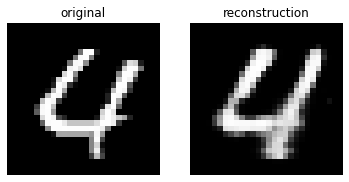

Generate a random image from the model:


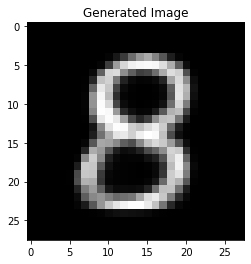

Intended digit:  8
Intended as handwritten:  False
Epoch: 521 average training loss: 94.69071217803955
Epoch: 522 average training loss: 94.68269159698487
Epoch: 523 average training loss: 94.68071767120361
Epoch: 524 average training loss: 94.66034872589111
Epoch: 525 average training loss: 94.66330761260987
Epoch: 526 average training loss: 94.65538818511963
Epoch: 527 average training loss: 94.66229834747314
Epoch: 528 average training loss: 94.65772973175049
Epoch: 529 average training loss: 94.66619705352784
Epoch: 530 average training loss: 94.65935191802978
Epoch: 530 average test loss: 97.81122731933594
Comparing a random test image to its reconstruction:


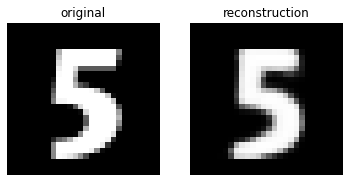

Generate a random image from the model:


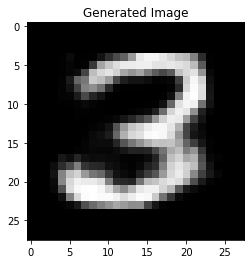

Intended digit:  3
Intended as handwritten:  False
Epoch: 531 average training loss: 94.62932381744385
Epoch: 532 average training loss: 94.63745803375244
Epoch: 533 average training loss: 94.62412825469971
Epoch: 534 average training loss: 94.62470735015869
Epoch: 535 average training loss: 94.64860833892823
Epoch: 536 average training loss: 94.62866479034423
Epoch: 537 average training loss: 94.63412222442626
Epoch: 538 average training loss: 94.62271155548096
Epoch: 539 average training loss: 94.6120771194458
Epoch: 540 average training loss: 94.60554398956299
Epoch: 540 average test loss: 97.81634720458985
Comparing a random test image to its reconstruction:


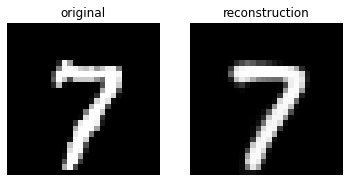

Generate a random image from the model:


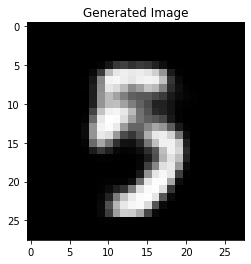

Intended digit:  5
Intended as handwritten:  False
Epoch: 541 average training loss: 94.61472354278564
Epoch: 542 average training loss: 94.63863062286377
Epoch: 543 average training loss: 94.59366817169189
Epoch: 544 average training loss: 94.57305647735596
Epoch: 545 average training loss: 94.60501767120361
Epoch: 546 average training loss: 94.60244632110596
Epoch: 547 average training loss: 94.55401646881103
Epoch: 548 average training loss: 94.5706421218872
Epoch: 549 average training loss: 94.56098855743409
Epoch: 550 average training loss: 94.55443069000245
Epoch: 550 average test loss: 97.76309592285156
Comparing a random test image to its reconstruction:


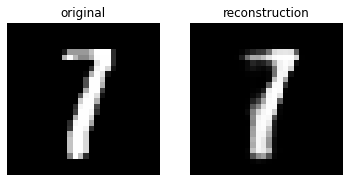

Generate a random image from the model:


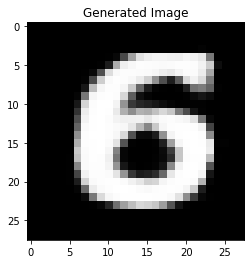

Intended digit:  6
Intended as handwritten:  False
Epoch: 551 average training loss: 94.58596900787353
Epoch: 552 average training loss: 94.58257795562744
Epoch: 553 average training loss: 94.58098510894776
Epoch: 554 average training loss: 94.5479838394165
Epoch: 555 average training loss: 94.56234096832276
Epoch: 556 average training loss: 94.53827241973877
Epoch: 557 average training loss: 94.56499509429932
Epoch: 558 average training loss: 94.5532721206665
Epoch: 559 average training loss: 94.57407136993409
Epoch: 560 average training loss: 94.54312401885986
Epoch: 560 average test loss: 97.78436123046875
Comparing a random test image to its reconstruction:


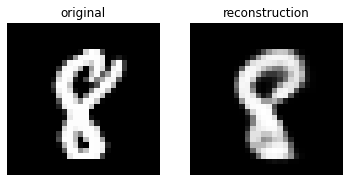

Generate a random image from the model:


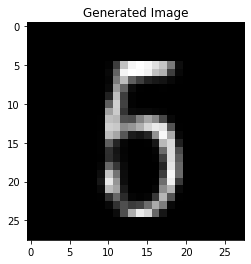

Intended digit:  5
Intended as handwritten:  False
Epoch: 561 average training loss: 94.5477310623169
Epoch: 562 average training loss: 94.5336777053833
Epoch: 563 average training loss: 94.55361848907471
Epoch: 564 average training loss: 94.5245312942505
Epoch: 565 average training loss: 94.49177577667237
Epoch: 566 average training loss: 94.53257339019775
Epoch: 567 average training loss: 94.509202192688
Epoch: 568 average training loss: 94.50871871490479
Epoch: 569 average training loss: 94.51759084014893
Epoch: 570 average training loss: 94.50382621002197
Epoch: 570 average test loss: 97.89570686645507
Comparing a random test image to its reconstruction:


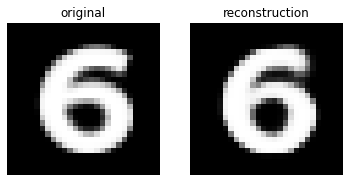

Generate a random image from the model:


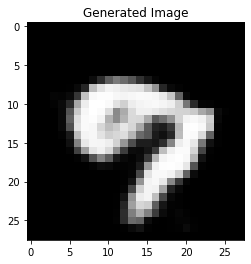

Intended digit:  9
Intended as handwritten:  False
Epoch: 571 average training loss: 94.50714711456298
Epoch: 572 average training loss: 94.48852962188721
Epoch: 573 average training loss: 94.51620364532471
Epoch: 574 average training loss: 94.47946993560791
Epoch: 575 average training loss: 94.47440833892823
Epoch: 576 average training loss: 94.48754956817626
Epoch: 577 average training loss: 94.45515257110596
Epoch: 578 average training loss: 94.47794752960205
Epoch: 579 average training loss: 94.4662478591919
Epoch: 580 average training loss: 94.48473985137939
Epoch: 580 average test loss: 97.78620919189453
Comparing a random test image to its reconstruction:


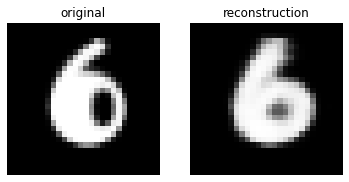

Generate a random image from the model:


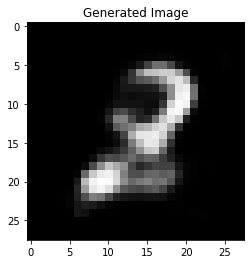

Intended digit:  2
Intended as handwritten:  False
Epoch: 581 average training loss: 94.44567865753174
Epoch: 582 average training loss: 94.48326443023682
Epoch: 583 average training loss: 94.45850634918213
Epoch: 584 average training loss: 94.46903683624268
Epoch: 585 average training loss: 94.46073683624267
Epoch: 586 average training loss: 94.47280169830323
Epoch: 587 average training loss: 94.4426530960083
Epoch: 588 average training loss: 94.4627543045044
Epoch: 589 average training loss: 94.47093287506104
Epoch: 590 average training loss: 94.43693167877197
Epoch: 590 average test loss: 97.75699946289062
Comparing a random test image to its reconstruction:


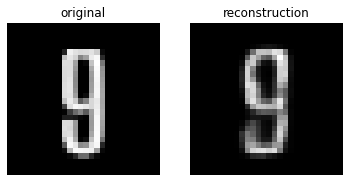

Generate a random image from the model:


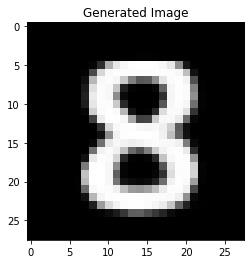

Intended digit:  8
Intended as handwritten:  False
Epoch: 591 average training loss: 94.44514726715087
Epoch: 592 average training loss: 94.47303118438721
Epoch: 593 average training loss: 94.38574118804932
Epoch: 594 average training loss: 94.42013389434814
Epoch: 595 average training loss: 94.42433344268798
Epoch: 596 average training loss: 94.43966049346923
Epoch: 597 average training loss: 94.38875205841065
Epoch: 598 average training loss: 94.42503584747314
Epoch: 599 average training loss: 94.42517406768799
Epoch: 600 average training loss: 94.42462155303956
Epoch: 600 average test loss: 97.76325090332031
Comparing a random test image to its reconstruction:


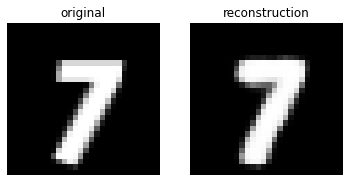

Generate a random image from the model:


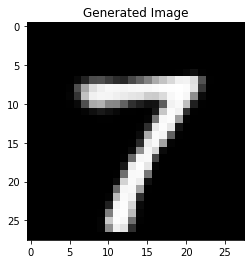

Intended digit:  7
Intended as handwritten:  False
Epoch: 601 average training loss: 94.3828822341919
Epoch: 602 average training loss: 94.38559798126221
Epoch: 603 average training loss: 94.37619568634034
Epoch: 604 average training loss: 94.41792952423096
Epoch: 605 average training loss: 94.40582515411377
Epoch: 606 average training loss: 94.41797324371338
Epoch: 607 average training loss: 94.37061236724854
Epoch: 608 average training loss: 94.38715669708252
Epoch: 609 average training loss: 94.37719542388916
Epoch: 610 average training loss: 94.37393378448486
Epoch: 610 average test loss: 97.91610400390626
Comparing a random test image to its reconstruction:


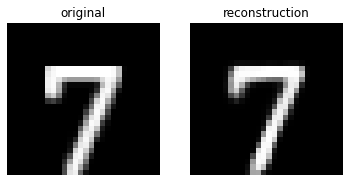

Generate a random image from the model:


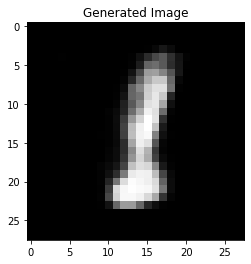

Intended digit:  1
Intended as handwritten:  False
Epoch: 611 average training loss: 94.37518112335205
Epoch: 612 average training loss: 94.37205165557862
Epoch: 613 average training loss: 94.36108115997314
Epoch: 614 average training loss: 94.38686146392823
Epoch: 615 average training loss: 94.33852675323486
Epoch: 616 average training loss: 94.36336745147705
Epoch: 617 average training loss: 94.3535504776001
Epoch: 618 average training loss: 94.35552252349854
Epoch: 619 average training loss: 94.35702157745361
Epoch: 620 average training loss: 94.38476820831299
Epoch: 620 average test loss: 97.83592952880859
Comparing a random test image to its reconstruction:


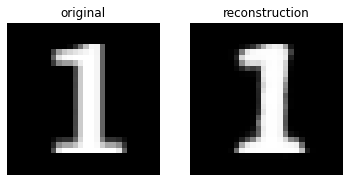

Generate a random image from the model:


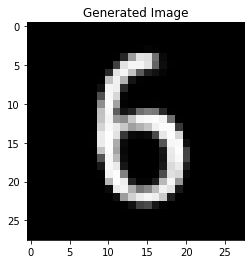

Intended digit:  6
Intended as handwritten:  False
Epoch: 621 average training loss: 94.37100890045166
Epoch: 622 average training loss: 94.33968314361572
Epoch: 623 average training loss: 94.3341162612915
Epoch: 624 average training loss: 94.36365009918212
Epoch: 625 average training loss: 94.3252771194458
Epoch: 626 average training loss: 94.3162581741333
Epoch: 627 average training loss: 94.30165924224853
Epoch: 628 average training loss: 94.34041232452392
Epoch: 629 average training loss: 94.32279690704345
Epoch: 630 average training loss: 94.31341683502197
Epoch: 630 average test loss: 97.74928236694336
Comparing a random test image to its reconstruction:


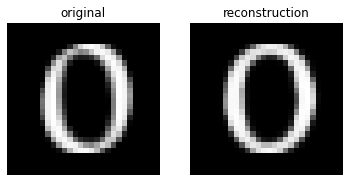

Generate a random image from the model:


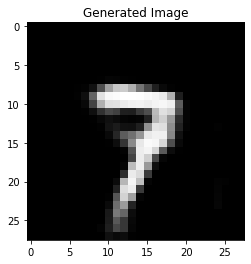

Intended digit:  7
Intended as handwritten:  False
Epoch: 631 average training loss: 94.3217040725708
Epoch: 632 average training loss: 94.30330661773682
Epoch: 633 average training loss: 94.34848976593018
Epoch: 634 average training loss: 94.31741398468017
Epoch: 635 average training loss: 94.31216397857666
Epoch: 636 average training loss: 94.28550392608642
Epoch: 637 average training loss: 94.29592577667236
Epoch: 638 average training loss: 94.28692318878174
Epoch: 639 average training loss: 94.29506882476807
Epoch: 640 average training loss: 94.31727315826416
Epoch: 640 average test loss: 97.86638061523438
Comparing a random test image to its reconstruction:


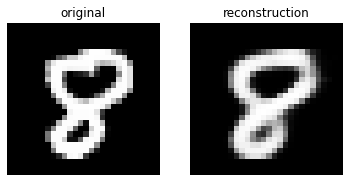

Generate a random image from the model:


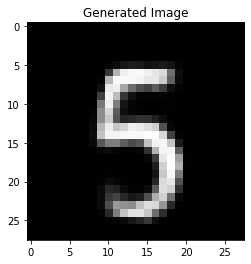

Intended digit:  5
Intended as handwritten:  False
Epoch: 641 average training loss: 94.31414474639892
Epoch: 642 average training loss: 94.29239568634033
Epoch: 643 average training loss: 94.2816931350708
Epoch: 644 average training loss: 94.26952927398682
Epoch: 645 average training loss: 94.25639004669189
Epoch: 646 average training loss: 94.25529505767823
Epoch: 647 average training loss: 94.29128679962159
Epoch: 648 average training loss: 94.28542020416259
Epoch: 649 average training loss: 94.28759546661377
Epoch: 650 average training loss: 94.26473546905518
Epoch: 650 average test loss: 97.86282252197266
Comparing a random test image to its reconstruction:


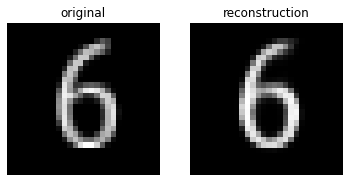

Generate a random image from the model:


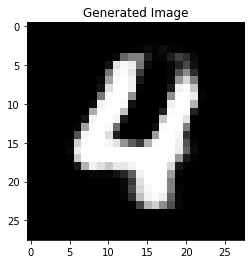

Intended digit:  4
Intended as handwritten:  False
Epoch: 651 average training loss: 94.23858186798095
Epoch: 652 average training loss: 94.23787138214111
Epoch: 653 average training loss: 94.24785451202392
Epoch: 654 average training loss: 94.24718490753173
Epoch: 655 average training loss: 94.2461529006958
Epoch: 656 average training loss: 94.24341060943604
Epoch: 657 average training loss: 94.23473830108642
Epoch: 658 average training loss: 94.2489552444458
Epoch: 659 average training loss: 94.23299463653565
Epoch: 660 average training loss: 94.22042790679932
Epoch: 660 average test loss: 97.70269465942383
Comparing a random test image to its reconstruction:


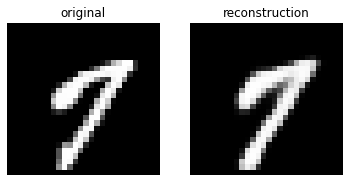

Generate a random image from the model:


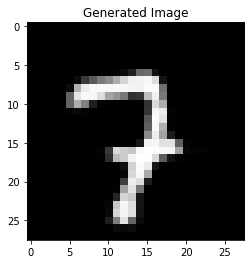

Intended digit:  7
Intended as handwritten:  False
Epoch: 661 average training loss: 94.22283202667236
Epoch: 662 average training loss: 94.23660037994385
Epoch: 663 average training loss: 94.22530565338134
Epoch: 664 average training loss: 94.2287725906372
Epoch: 665 average training loss: 94.2331271621704
Epoch: 666 average training loss: 94.23658328399658
Epoch: 667 average training loss: 94.21851848297119
Epoch: 668 average training loss: 94.19030929718018
Epoch: 669 average training loss: 94.22924990386963
Epoch: 670 average training loss: 94.2181021987915
Epoch: 670 average test loss: 97.69732080078126
Comparing a random test image to its reconstruction:


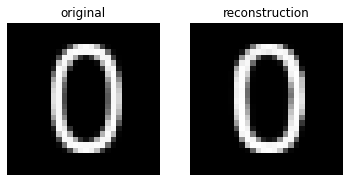

Generate a random image from the model:


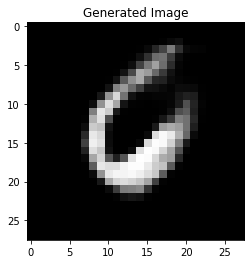

Intended digit:  6
Intended as handwritten:  False
Epoch: 671 average training loss: 94.19087749176025
Epoch: 672 average training loss: 94.19701317901611
Epoch: 673 average training loss: 94.21950545806885
Epoch: 674 average training loss: 94.19328199005128
Epoch: 675 average training loss: 94.18774225616455
Epoch: 676 average training loss: 94.20326249542236
Epoch: 677 average training loss: 94.19902825469971
Epoch: 678 average training loss: 94.18792718048095
Epoch: 679 average training loss: 94.19345919342041
Epoch: 680 average training loss: 94.20330854644776
Epoch: 680 average test loss: 97.7203403564453
Comparing a random test image to its reconstruction:


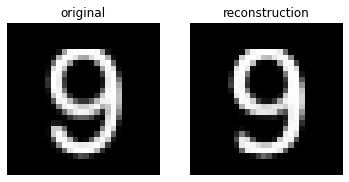

Generate a random image from the model:


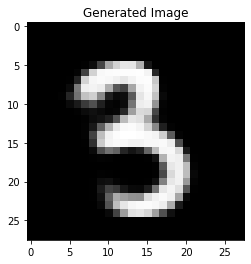

Intended digit:  3
Intended as handwritten:  False
Epoch: 681 average training loss: 94.19224070587158
Epoch: 682 average training loss: 94.18444749298095
Epoch: 683 average training loss: 94.18307083892822
Epoch: 684 average training loss: 94.16900712432862
Epoch: 685 average training loss: 94.141980317688
Epoch: 686 average training loss: 94.18519678497314
Epoch: 687 average training loss: 94.19473491973876
Epoch: 688 average training loss: 94.13158953399659
Epoch: 689 average training loss: 94.17188480377197
Epoch: 690 average training loss: 94.13442914581299
Epoch: 690 average test loss: 97.75834858398437
Comparing a random test image to its reconstruction:


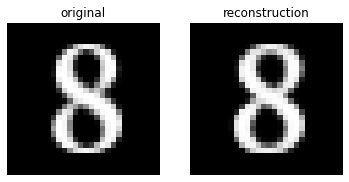

Generate a random image from the model:


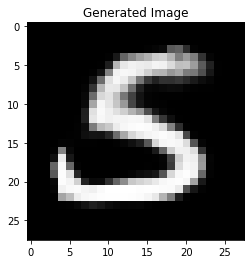

Intended digit:  5
Intended as handwritten:  False
Epoch: 691 average training loss: 94.14676051177979
Epoch: 692 average training loss: 94.15485377960205
Epoch: 693 average training loss: 94.11282566070557
Epoch: 694 average training loss: 94.16858734893799
Epoch: 695 average training loss: 94.13184347686767
Epoch: 696 average training loss: 94.14790529937744
Epoch: 697 average training loss: 94.1457307144165
Epoch: 698 average training loss: 94.13126360626221
Epoch: 699 average training loss: 94.13534140167236
Epoch: 700 average training loss: 94.14149334259034
Epoch: 700 average test loss: 97.87279483642578
Comparing a random test image to its reconstruction:


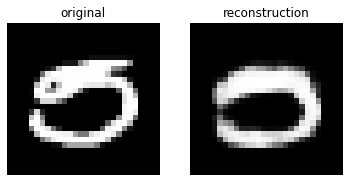

Generate a random image from the model:


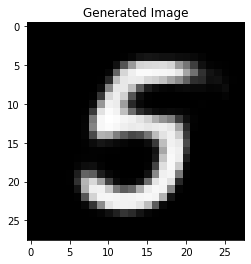

Intended digit:  5
Intended as handwritten:  False
Epoch: 701 average training loss: 94.12725552520752
Epoch: 702 average training loss: 94.11774019317627
Epoch: 703 average training loss: 94.09393650665284
Epoch: 704 average training loss: 94.12132593536377
Epoch: 705 average training loss: 94.15127066802978
Epoch: 706 average training loss: 94.11212421417237
Epoch: 707 average training loss: 94.11426955718994
Epoch: 708 average training loss: 94.11734870758056
Epoch: 709 average training loss: 94.10947097930908
Epoch: 710 average training loss: 94.09790637969971
Epoch: 710 average test loss: 97.61294852294922
Comparing a random test image to its reconstruction:


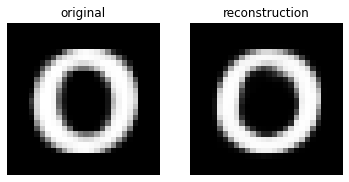

Generate a random image from the model:


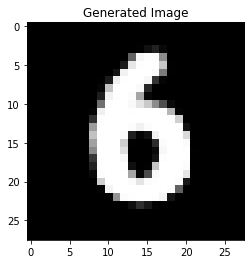

Intended digit:  6
Intended as handwritten:  False
Epoch: 711 average training loss: 94.11114604644776
Epoch: 712 average training loss: 94.10521333770753
Epoch: 713 average training loss: 94.09581284332275
Epoch: 714 average training loss: 94.09691742706299
Epoch: 715 average training loss: 94.11849068756104
Epoch: 716 average training loss: 94.0842911026001
Epoch: 717 average training loss: 94.0700216140747
Epoch: 718 average training loss: 94.08592434844971
Epoch: 719 average training loss: 94.0616462600708
Epoch: 720 average training loss: 94.07989813995361
Epoch: 720 average test loss: 97.72670908813477
Comparing a random test image to its reconstruction:


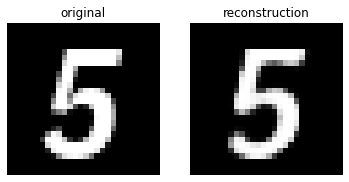

Generate a random image from the model:


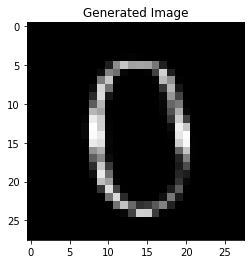

Intended digit:  0
Intended as handwritten:  False
Epoch: 721 average training loss: 94.06766236724853
Epoch: 722 average training loss: 94.05962748565673
Epoch: 723 average training loss: 94.05468465118408
Epoch: 724 average training loss: 94.05649126739502
Epoch: 725 average training loss: 94.04154882354736
Epoch: 726 average training loss: 94.06002469024658
Epoch: 727 average training loss: 94.07964767608642
Epoch: 728 average training loss: 94.03937268829345
Epoch: 729 average training loss: 94.04745109405518
Epoch: 730 average training loss: 94.05518251495361
Epoch: 730 average test loss: 97.77075832519532
Comparing a random test image to its reconstruction:


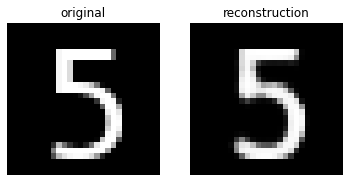

Generate a random image from the model:


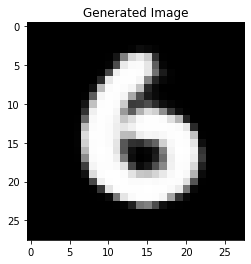

Intended digit:  6
Intended as handwritten:  False
Epoch: 731 average training loss: 94.06749890899658
Epoch: 732 average training loss: 94.04026981353759
Epoch: 733 average training loss: 94.04449088897705
Epoch: 734 average training loss: 94.03950291290283
Epoch: 735 average training loss: 94.0425935256958
Epoch: 736 average training loss: 94.0597264175415
Epoch: 737 average training loss: 94.03693718414307
Epoch: 738 average training loss: 94.03216432647704
Epoch: 739 average training loss: 94.00845297393799
Epoch: 740 average training loss: 94.01249875030517
Epoch: 740 average test loss: 97.65706314086914
Comparing a random test image to its reconstruction:


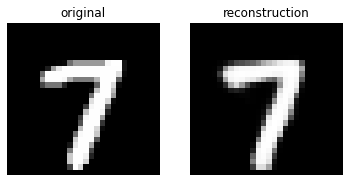

Generate a random image from the model:


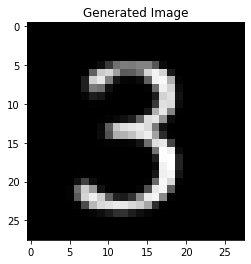

Intended digit:  3
Intended as handwritten:  False
Epoch: 741 average training loss: 94.0181628616333
Epoch: 742 average training loss: 94.01613843536377
Epoch: 743 average training loss: 94.01578144073487
Epoch: 744 average training loss: 94.01134015655518
Epoch: 745 average training loss: 94.00720999298096
Epoch: 746 average training loss: 94.02812242584228
Epoch: 747 average training loss: 94.01654479522705
Epoch: 748 average training loss: 94.00272256622314
Epoch: 749 average training loss: 93.98404570465088
Epoch: 750 average training loss: 93.98667499542236
Epoch: 750 average test loss: 97.70450961914062
Comparing a random test image to its reconstruction:


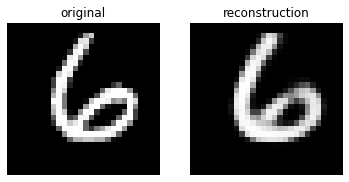

Generate a random image from the model:


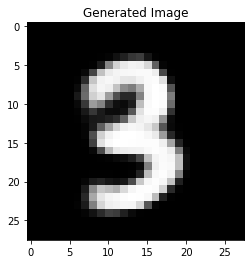

Intended digit:  3
Intended as handwritten:  False
Epoch: 751 average training loss: 93.99775410919189
Epoch: 752 average training loss: 94.00923994903565
Epoch: 753 average training loss: 93.98072588043213
Epoch: 754 average training loss: 94.00800245513916
Epoch: 755 average training loss: 93.99915598907471
Epoch: 756 average training loss: 94.00662209625244
Epoch: 757 average training loss: 94.00365741729736
Epoch: 758 average training loss: 93.98606377716064
Epoch: 759 average training loss: 93.96762471466064
Epoch: 760 average training loss: 93.95575670928955
Epoch: 760 average test loss: 97.72496516113281
Comparing a random test image to its reconstruction:


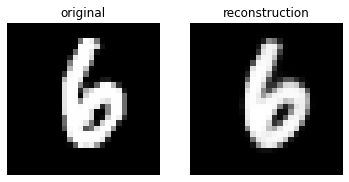

Generate a random image from the model:


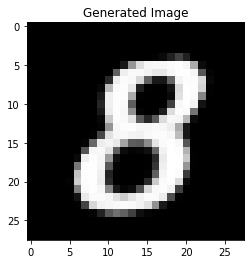

Intended digit:  8
Intended as handwritten:  False
Epoch: 761 average training loss: 93.96779605255126
Epoch: 762 average training loss: 93.95503678131104
Epoch: 763 average training loss: 93.96588125762939
Epoch: 764 average training loss: 93.97256695709228
Epoch: 765 average training loss: 93.95873522491455
Epoch: 766 average training loss: 93.95251095733643
Epoch: 767 average training loss: 93.98369115142822
Epoch: 768 average training loss: 93.97485989532471
Epoch: 769 average training loss: 93.96496333160401
Epoch: 770 average training loss: 93.97308995513916
Epoch: 770 average test loss: 97.71571107177735
Comparing a random test image to its reconstruction:


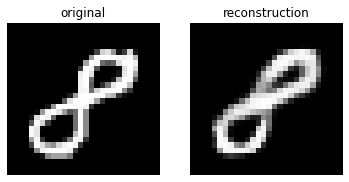

Generate a random image from the model:


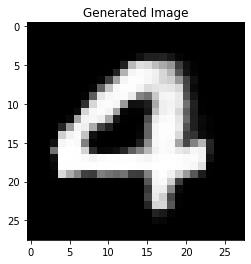

Intended digit:  4
Intended as handwritten:  False
Epoch: 771 average training loss: 93.92452091827393
Epoch: 772 average training loss: 93.95756427154541
Epoch: 773 average training loss: 93.93006658477783
Epoch: 774 average training loss: 93.95746710357666
Epoch: 775 average training loss: 93.95704610137939
Epoch: 776 average training loss: 93.9196810623169
Epoch: 777 average training loss: 93.9480946609497
Epoch: 778 average training loss: 93.94310390777588
Epoch: 779 average training loss: 93.96412593536377
Epoch: 780 average training loss: 93.94320146636963
Epoch: 780 average test loss: 97.81600465698243
Comparing a random test image to its reconstruction:


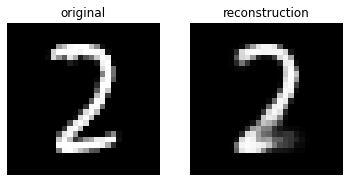

Generate a random image from the model:


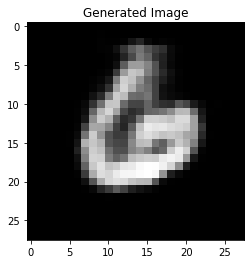

Intended digit:  6
Intended as handwritten:  False
Epoch: 781 average training loss: 93.92223114166259
Epoch: 782 average training loss: 93.9344611404419
Epoch: 783 average training loss: 93.91050928497314
Epoch: 784 average training loss: 93.92278931427002
Epoch: 785 average training loss: 93.92949478302002
Epoch: 786 average training loss: 93.91183428497314
Epoch: 787 average training loss: 93.92837625274659
Epoch: 788 average training loss: 93.92145042266846
Epoch: 789 average training loss: 93.87864807891846
Epoch: 790 average training loss: 93.90974369049073
Epoch: 790 average test loss: 97.7009197265625
Comparing a random test image to its reconstruction:


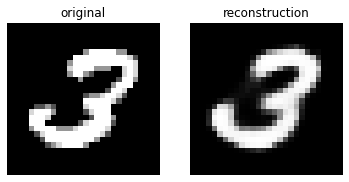

Generate a random image from the model:


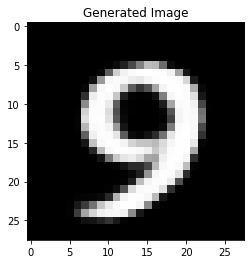

Intended digit:  9
Intended as handwritten:  False
Epoch: 791 average training loss: 93.90766672515869
Epoch: 792 average training loss: 93.9209253616333
Epoch: 793 average training loss: 93.9078481704712
Epoch: 794 average training loss: 93.91468799591064
Epoch: 795 average training loss: 93.91482237701416
Epoch: 796 average training loss: 93.89799267120361
Epoch: 797 average training loss: 93.89085080108643
Epoch: 798 average training loss: 93.90067678985595
Epoch: 799 average training loss: 93.86034209136963
Epoch: 800 average training loss: 93.88413560333252
Epoch: 800 average test loss: 97.62662745361328
Comparing a random test image to its reconstruction:


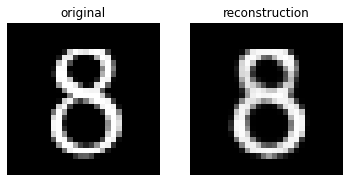

Generate a random image from the model:


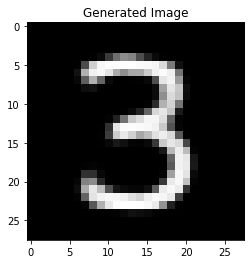

Intended digit:  3
Intended as handwritten:  False
Epoch: 801 average training loss: 93.87706522979737
Epoch: 802 average training loss: 93.8853793045044
Epoch: 803 average training loss: 93.8941891921997
Epoch: 804 average training loss: 93.87567420196534
Epoch: 805 average training loss: 93.91342498321534
Epoch: 806 average training loss: 93.86556886749267
Epoch: 807 average training loss: 93.87159687042237
Epoch: 808 average training loss: 93.89195722198487
Epoch: 809 average training loss: 93.90474479522705
Epoch: 810 average training loss: 93.87122116851806
Epoch: 810 average test loss: 97.58991900024414
Comparing a random test image to its reconstruction:


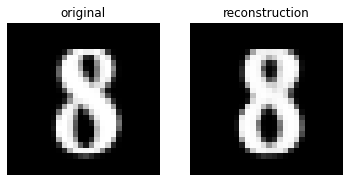

Generate a random image from the model:


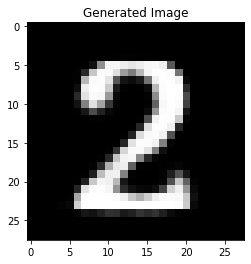

Intended digit:  2
Intended as handwritten:  False
Epoch: 811 average training loss: 93.84903195343017
Epoch: 812 average training loss: 93.87547914581299
Epoch: 813 average training loss: 93.84069135894775
Epoch: 814 average training loss: 93.83417349395752
Epoch: 815 average training loss: 93.8569856399536
Epoch: 816 average training loss: 93.85718416290283
Epoch: 817 average training loss: 93.85052229766846
Epoch: 818 average training loss: 93.84978543243408
Epoch: 819 average training loss: 93.8774884902954
Epoch: 820 average training loss: 93.84355262603759
Epoch: 820 average test loss: 97.73040567016602
Comparing a random test image to its reconstruction:


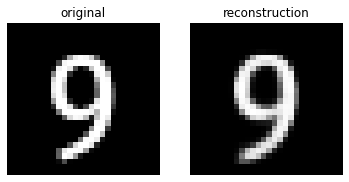

Generate a random image from the model:


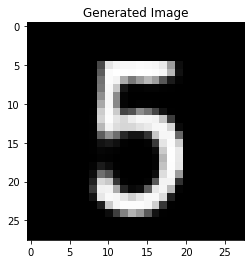

Intended digit:  5
Intended as handwritten:  False
Epoch: 821 average training loss: 93.85677252960205
Epoch: 822 average training loss: 93.83528118438721
Epoch: 823 average training loss: 93.83066138458251
Epoch: 824 average training loss: 93.821614503479
Epoch: 825 average training loss: 93.79929759674073
Epoch: 826 average training loss: 93.84190298614502
Epoch: 827 average training loss: 93.82332644195557
Epoch: 828 average training loss: 93.82820614166259
Epoch: 829 average training loss: 93.82364810943604
Epoch: 830 average training loss: 93.82118093414307
Epoch: 830 average test loss: 97.60646258544922
Comparing a random test image to its reconstruction:


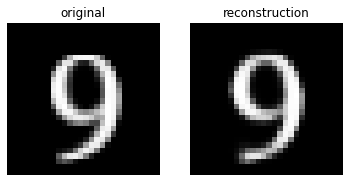

Generate a random image from the model:


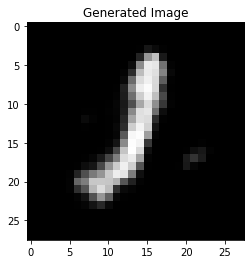

Intended digit:  1
Intended as handwritten:  False
Epoch: 831 average training loss: 93.8244589920044
Epoch: 832 average training loss: 93.81139248199463
Epoch: 833 average training loss: 93.80271371002198
Epoch: 834 average training loss: 93.82996004791259
Epoch: 835 average training loss: 93.79116366119385
Epoch: 836 average training loss: 93.82135864410401
Epoch: 837 average training loss: 93.81092448272705
Epoch: 838 average training loss: 93.82682381134033
Epoch: 839 average training loss: 93.8236298538208
Epoch: 840 average training loss: 93.77418382110595
Epoch: 840 average test loss: 97.77041314697266
Comparing a random test image to its reconstruction:


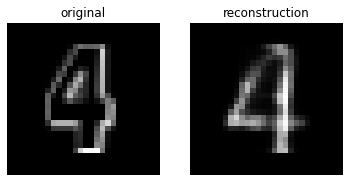

Generate a random image from the model:


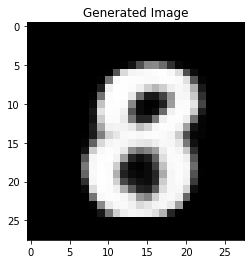

Intended digit:  8
Intended as handwritten:  False
Epoch: 841 average training loss: 93.82232353057861
Epoch: 842 average training loss: 93.81250230255127
Epoch: 843 average training loss: 93.8028049331665
Epoch: 844 average training loss: 93.78290261383057
Epoch: 845 average training loss: 93.78760695953369
Epoch: 846 average training loss: 93.78766360626221
Epoch: 847 average training loss: 93.76205429840088
Epoch: 848 average training loss: 93.77184279327392
Epoch: 849 average training loss: 93.79119005279541
Epoch: 850 average training loss: 93.79554904937744
Epoch: 850 average test loss: 97.6355376953125
Comparing a random test image to its reconstruction:


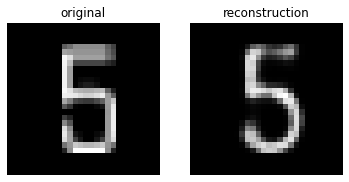

Generate a random image from the model:


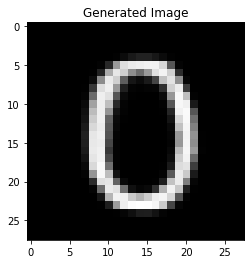

Intended digit:  0
Intended as handwritten:  False
Epoch: 851 average training loss: 93.78674281158447
Epoch: 852 average training loss: 93.78818600616455
Epoch: 853 average training loss: 93.79280191192628
Epoch: 854 average training loss: 93.79027717437744
Epoch: 855 average training loss: 93.76899462432861
Epoch: 856 average training loss: 93.77863963775634
Epoch: 857 average training loss: 93.77283285675048
Epoch: 858 average training loss: 93.76167566680908
Epoch: 859 average training loss: 93.78038631134034
Epoch: 860 average training loss: 93.73983334503174
Epoch: 860 average test loss: 97.65795377197266
Comparing a random test image to its reconstruction:


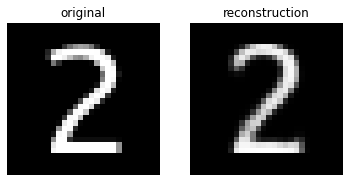

Generate a random image from the model:


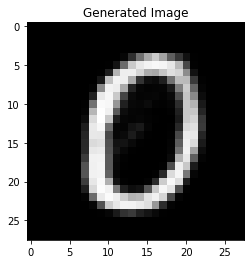

Intended digit:  0
Intended as handwritten:  False
Epoch: 861 average training loss: 93.78706756134034
Epoch: 862 average training loss: 93.72954840850831
Epoch: 863 average training loss: 93.75390347442627
Epoch: 864 average training loss: 93.76055338897704
Epoch: 865 average training loss: 93.7205802444458
Epoch: 866 average training loss: 93.73784998321533
Epoch: 867 average training loss: 93.74738534698486
Epoch: 868 average training loss: 93.73879201202392
Epoch: 869 average training loss: 93.7510446548462
Epoch: 870 average training loss: 93.74596205596924
Epoch: 870 average test loss: 97.65783300170898
Comparing a random test image to its reconstruction:


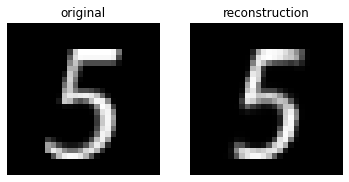

Generate a random image from the model:


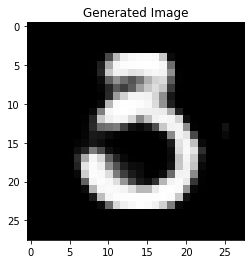

Intended digit:  3
Intended as handwritten:  False
Epoch: 871 average training loss: 93.7246437576294
Epoch: 872 average training loss: 93.75497897491455
Epoch: 873 average training loss: 93.74623259429931
Epoch: 874 average training loss: 93.73410264434814
Epoch: 875 average training loss: 93.72801023712158
Epoch: 876 average training loss: 93.7209039138794
Epoch: 877 average training loss: 93.71741532745361
Epoch: 878 average training loss: 93.72274541778565
Epoch: 879 average training loss: 93.7072916091919
Epoch: 880 average training loss: 93.71947835235596
Epoch: 880 average test loss: 97.62810162353516
Comparing a random test image to its reconstruction:


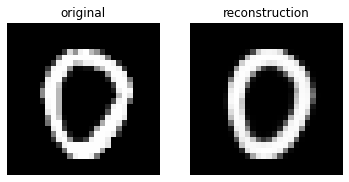

Generate a random image from the model:


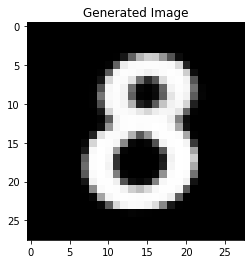

Intended digit:  8
Intended as handwritten:  False
Epoch: 881 average training loss: 93.70634043121338
Epoch: 882 average training loss: 93.74944839630128
Epoch: 883 average training loss: 93.7371919998169
Epoch: 884 average training loss: 93.7403119216919
Epoch: 885 average training loss: 93.72707515411376
Epoch: 886 average training loss: 93.69227735137939
Epoch: 887 average training loss: 93.69299159698487
Epoch: 888 average training loss: 93.70974495391846
Epoch: 889 average training loss: 93.69139872589112
Epoch: 890 average training loss: 93.7044761428833
Epoch: 890 average test loss: 97.72358708496094
Comparing a random test image to its reconstruction:


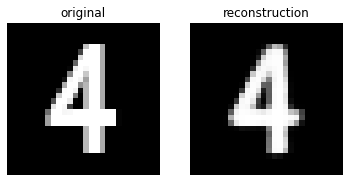

Generate a random image from the model:


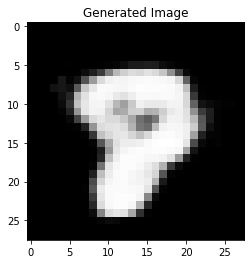

Intended digit:  8
Intended as handwritten:  False
Epoch: 891 average training loss: 93.7094321609497
Epoch: 892 average training loss: 93.68314553985596
Epoch: 893 average training loss: 93.70734702301026
Epoch: 894 average training loss: 93.71076976470947
Epoch: 895 average training loss: 93.68511870880127
Epoch: 896 average training loss: 93.69530722198486
Epoch: 897 average training loss: 93.67959389190673
Epoch: 898 average training loss: 93.6705923538208
Epoch: 899 average training loss: 93.66806052398681
Epoch: 900 average training loss: 93.66194295196533
Epoch: 900 average test loss: 97.68292034301759
Comparing a random test image to its reconstruction:


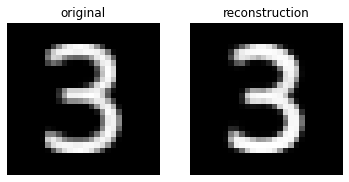

Generate a random image from the model:


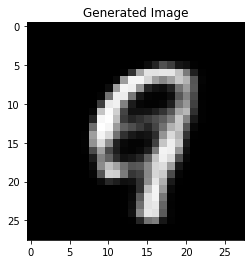

Intended digit:  9
Intended as handwritten:  False
Epoch: 901 average training loss: 93.6540519241333
Epoch: 902 average training loss: 93.70213452911376
Epoch: 903 average training loss: 93.65953706817626
Epoch: 904 average training loss: 93.67996507110595
Epoch: 905 average training loss: 93.67918003692627
Epoch: 906 average training loss: 93.6780785232544
Epoch: 907 average training loss: 93.66345179595947
Epoch: 908 average training loss: 93.69241183624267
Epoch: 909 average training loss: 93.67285361480712
Epoch: 910 average training loss: 93.69517233428955
Epoch: 910 average test loss: 97.6897736328125
Comparing a random test image to its reconstruction:


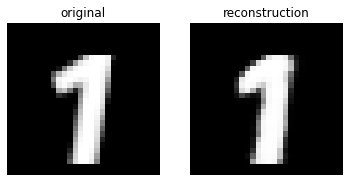

Generate a random image from the model:


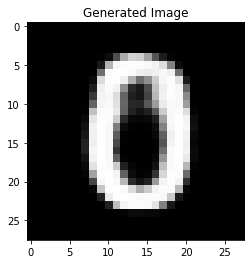

Intended digit:  0
Intended as handwritten:  False
Epoch: 911 average training loss: 93.67566095733642
Epoch: 912 average training loss: 93.62010664825439
Epoch: 913 average training loss: 93.68441565704346
Epoch: 914 average training loss: 93.66300699005127
Epoch: 915 average training loss: 93.65237880401611
Epoch: 916 average training loss: 93.64951979522705
Epoch: 917 average training loss: 93.68761338653565
Epoch: 918 average training loss: 93.63854030303955
Epoch: 919 average training loss: 93.66681074981689
Epoch: 920 average training loss: 93.65808097076416
Epoch: 920 average test loss: 97.64851392822266
Comparing a random test image to its reconstruction:


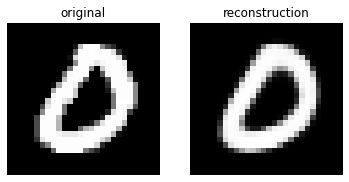

Generate a random image from the model:


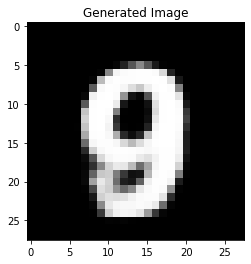

Intended digit:  9
Intended as handwritten:  False
Epoch: 921 average training loss: 93.64760818634034
Epoch: 922 average training loss: 93.61762522735596
Epoch: 923 average training loss: 93.6202302810669
Epoch: 924 average training loss: 93.66534346466065
Epoch: 925 average training loss: 93.64352381134033
Epoch: 926 average training loss: 93.6476323562622
Epoch: 927 average training loss: 93.64795784454346
Epoch: 928 average training loss: 93.65108354034423
Epoch: 929 average training loss: 93.65697362823487
Epoch: 930 average training loss: 93.6319723098755
Epoch: 930 average test loss: 97.62112074584961
Comparing a random test image to its reconstruction:


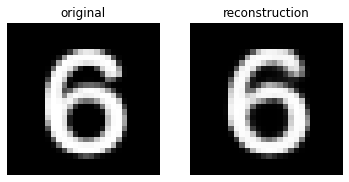

Generate a random image from the model:


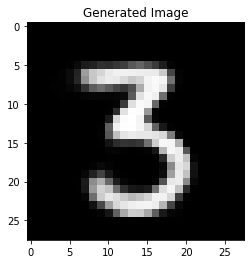

Intended digit:  3
Intended as handwritten:  False
Epoch: 931 average training loss: 93.6152065383911
Epoch: 932 average training loss: 93.61184060211181
Epoch: 933 average training loss: 93.63980855255127
Epoch: 934 average training loss: 93.61825828399658
Epoch: 935 average training loss: 93.6127873123169
Epoch: 936 average training loss: 93.59687353057862
Epoch: 937 average training loss: 93.62774128570557
Epoch: 938 average training loss: 93.60248557891846
Epoch: 939 average training loss: 93.61088972930908
Epoch: 940 average training loss: 93.57736873321534
Epoch: 940 average test loss: 97.72318963623047
Comparing a random test image to its reconstruction:


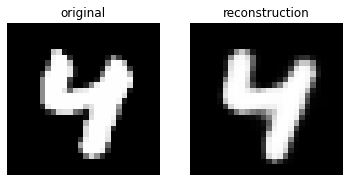

Generate a random image from the model:


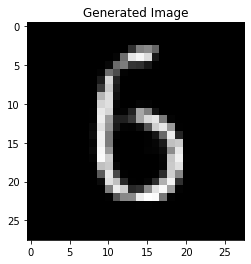

Intended digit:  6
Intended as handwritten:  False
Epoch: 941 average training loss: 93.63235277862549
Epoch: 942 average training loss: 93.59016947784424
Epoch: 943 average training loss: 93.59939027862549
Epoch: 944 average training loss: 93.58566162261963
Epoch: 945 average training loss: 93.58040458526611
Epoch: 946 average training loss: 93.60155355987548
Epoch: 947 average training loss: 93.58491410675049
Epoch: 948 average training loss: 93.61229806671143
Epoch: 949 average training loss: 93.60367124786377
Epoch: 950 average training loss: 93.59716754302978
Epoch: 950 average test loss: 97.66774078979492
Comparing a random test image to its reconstruction:


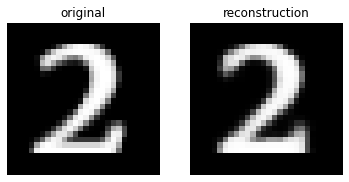

Generate a random image from the model:


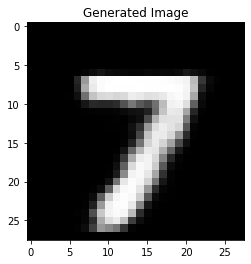

Intended digit:  7
Intended as handwritten:  False
Epoch: 951 average training loss: 93.57376078643799
Epoch: 952 average training loss: 93.55119856109619
Epoch: 953 average training loss: 93.5770634841919
Epoch: 954 average training loss: 93.57227000274658
Epoch: 955 average training loss: 93.59801101226806
Epoch: 956 average training loss: 93.57603162384034
Epoch: 957 average training loss: 93.57479228057862
Epoch: 958 average training loss: 93.55893607940673
Epoch: 959 average training loss: 93.59225227813721
Epoch: 960 average training loss: 93.5540595779419
Epoch: 960 average test loss: 97.71789426879883
Comparing a random test image to its reconstruction:


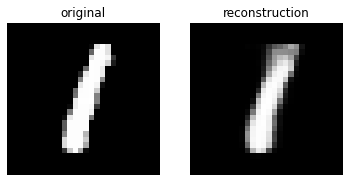

Generate a random image from the model:


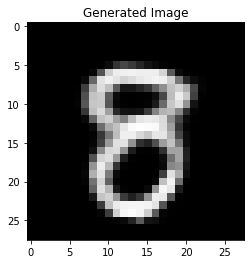

Intended digit:  8
Intended as handwritten:  False
Epoch: 961 average training loss: 93.5732240310669
Epoch: 962 average training loss: 93.54887608184815
Epoch: 963 average training loss: 93.56857904815674
Epoch: 964 average training loss: 93.5717061050415
Epoch: 965 average training loss: 93.56563700714112
Epoch: 966 average training loss: 93.54675865631104
Epoch: 967 average training loss: 93.5504847000122
Epoch: 968 average training loss: 93.54617191314698
Epoch: 969 average training loss: 93.54859203033448
Epoch: 970 average training loss: 93.55703905792237
Epoch: 970 average test loss: 97.69932621459961
Comparing a random test image to its reconstruction:


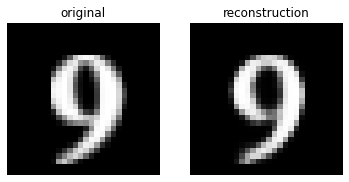

Generate a random image from the model:


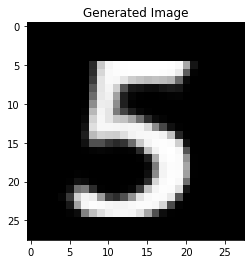

Intended digit:  5
Intended as handwritten:  False
Epoch: 971 average training loss: 93.5330748123169
Epoch: 972 average training loss: 93.56432773590087
Epoch: 973 average training loss: 93.56222890777588
Epoch: 974 average training loss: 93.5724211868286
Epoch: 975 average training loss: 93.57137020416259
Epoch: 976 average training loss: 93.55238559112549
Epoch: 977 average training loss: 93.53426772003174
Epoch: 978 average training loss: 93.55545470733642
Epoch: 979 average training loss: 93.54228540802002
Epoch: 980 average training loss: 93.53658017730713
Epoch: 980 average test loss: 97.65114225463867
Comparing a random test image to its reconstruction:


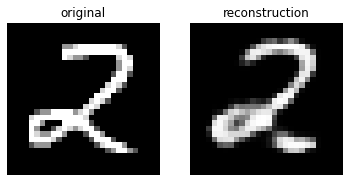

Generate a random image from the model:


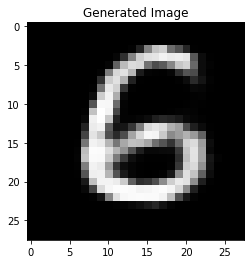

Intended digit:  6
Intended as handwritten:  False
Epoch: 981 average training loss: 93.513647315979
Epoch: 982 average training loss: 93.52887613677979
Epoch: 983 average training loss: 93.52535545806884
Epoch: 984 average training loss: 93.49403089752197
Epoch: 985 average training loss: 93.52485666046142
Epoch: 986 average training loss: 93.56202387237549
Epoch: 987 average training loss: 93.51686922149658
Epoch: 988 average training loss: 93.52602839508057
Epoch: 989 average training loss: 93.52038559722901
Epoch: 990 average training loss: 93.51542765045166
Epoch: 990 average test loss: 97.67469813842773
Comparing a random test image to its reconstruction:


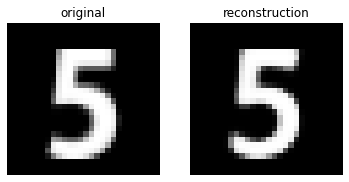

Generate a random image from the model:


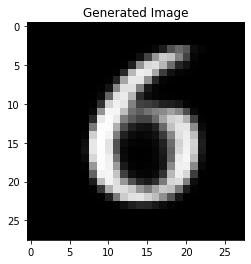

Intended digit:  6
Intended as handwritten:  False
Epoch: 991 average training loss: 93.5001780960083
Epoch: 992 average training loss: 93.51768760528564
Epoch: 993 average training loss: 93.49859877471924
Epoch: 994 average training loss: 93.48553939361572
Epoch: 995 average training loss: 93.51477495880127
Epoch: 996 average training loss: 93.49568927764892
Epoch: 997 average training loss: 93.51052376251221
Epoch: 998 average training loss: 93.49038379058838
Epoch: 999 average training loss: 93.52895035552979
Epoch: 1000 average training loss: 93.48804386749268
Epoch: 1000 average test loss: 97.69074170532227
Comparing a random test image to its reconstruction:


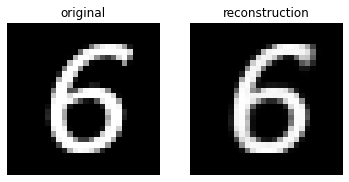

Generate a random image from the model:


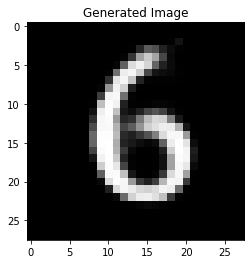

Intended digit:  6
Intended as handwritten:  False
Epoch: 1001 average training loss: 93.50428730010987
Epoch: 1002 average training loss: 93.5245273880005
Epoch: 1003 average training loss: 93.50072834014892
Epoch: 1004 average training loss: 93.4874978225708
Epoch: 1005 average training loss: 93.5049226272583
Epoch: 1006 average training loss: 93.49728176422119
Epoch: 1007 average training loss: 93.48400221710205
Epoch: 1008 average training loss: 93.4698579055786
Epoch: 1009 average training loss: 93.50000951690674
Epoch: 1010 average training loss: 93.48778950958251
Epoch: 1010 average test loss: 97.71385721435547
Comparing a random test image to its reconstruction:


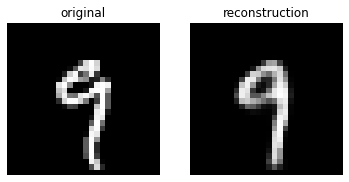

Generate a random image from the model:


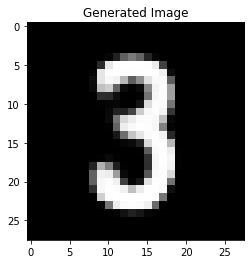

Intended digit:  3
Intended as handwritten:  False
Epoch: 1011 average training loss: 93.51412382354737
Epoch: 1012 average training loss: 93.45957398223877
Epoch: 1013 average training loss: 93.48218498077392
Epoch: 1014 average training loss: 93.48514416046143
Epoch: 1015 average training loss: 93.47368630523681
Epoch: 1016 average training loss: 93.45430511016846
Epoch: 1017 average training loss: 93.45969580841064
Epoch: 1018 average training loss: 93.47586140289306
Epoch: 1019 average training loss: 93.45689059600831
Epoch: 1020 average training loss: 93.4545695388794
Epoch: 1020 average test loss: 97.7264705078125
Comparing a random test image to its reconstruction:


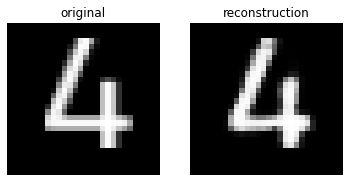

Generate a random image from the model:


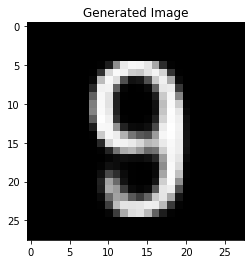

Intended digit:  9
Intended as handwritten:  False
Epoch: 1021 average training loss: 93.47129131622314
Epoch: 1022 average training loss: 93.45826612091065
Epoch: 1023 average training loss: 93.47259370880127
Epoch: 1024 average training loss: 93.48690178985596
Epoch: 1025 average training loss: 93.47113877105713
Epoch: 1026 average training loss: 93.42467772979737
Epoch: 1027 average training loss: 93.47755974884033
Epoch: 1028 average training loss: 93.47175476226806
Epoch: 1029 average training loss: 93.47038665313721
Epoch: 1030 average training loss: 93.46735876617431
Epoch: 1030 average test loss: 97.81240837402343
Comparing a random test image to its reconstruction:


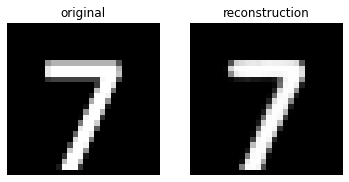

Generate a random image from the model:


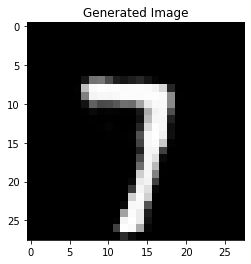

Intended digit:  7
Intended as handwritten:  False
Epoch: 1031 average training loss: 93.43580838165283
Epoch: 1032 average training loss: 93.48638667755127
Epoch: 1033 average training loss: 93.47799080963135
Epoch: 1034 average training loss: 93.46804401397705
Epoch: 1035 average training loss: 93.43763334503174
Epoch: 1036 average training loss: 93.43093159942627
Epoch: 1037 average training loss: 93.41984115753174
Epoch: 1038 average training loss: 93.44799484405517
Epoch: 1039 average training loss: 93.43264574127197
Epoch: 1040 average training loss: 93.42334833526611
Epoch: 1040 average test loss: 97.76871946411133
Comparing a random test image to its reconstruction:


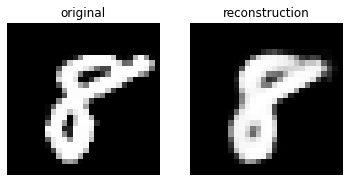

Generate a random image from the model:


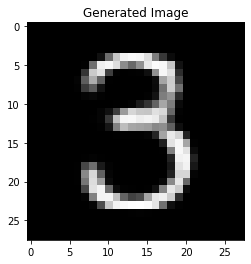

Intended digit:  3
Intended as handwritten:  False
Epoch: 1041 average training loss: 93.43541276397706
Epoch: 1042 average training loss: 93.42800189971923
Epoch: 1043 average training loss: 93.45652595977784
Epoch: 1044 average training loss: 93.41916007843018
Epoch: 1045 average training loss: 93.41684271392822
Epoch: 1046 average training loss: 93.46701179351807
Epoch: 1047 average training loss: 93.42963213653564
Epoch: 1048 average training loss: 93.41291840362548
Epoch: 1049 average training loss: 93.40921521759033
Epoch: 1050 average training loss: 93.40702238311768
Epoch: 1050 average test loss: 97.73690859375
Comparing a random test image to its reconstruction:


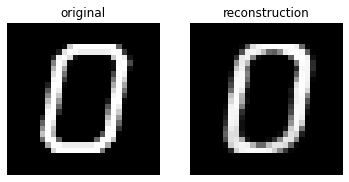

Generate a random image from the model:


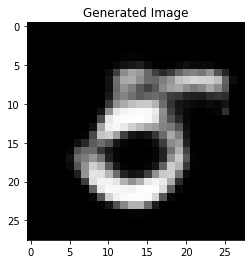

Intended digit:  5
Intended as handwritten:  False
Epoch: 1051 average training loss: 93.43210818023681
Epoch: 1052 average training loss: 93.42885097198486
Epoch: 1053 average training loss: 93.39121477203369
Epoch: 1054 average training loss: 93.42001417388916
Epoch: 1055 average training loss: 93.424309815979
Epoch: 1056 average training loss: 93.40685705108642
Epoch: 1057 average training loss: 93.42155473175049
Epoch: 1058 average training loss: 93.42382873077392
Epoch: 1059 average training loss: 93.42727073516846
Epoch: 1060 average training loss: 93.40967992706298
Epoch: 1060 average test loss: 97.69824309082031
Comparing a random test image to its reconstruction:


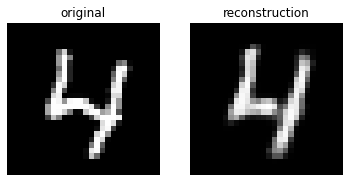

Generate a random image from the model:


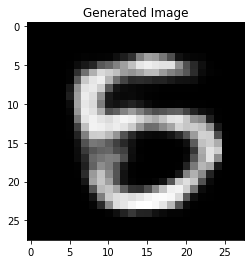

Intended digit:  5
Intended as handwritten:  False
Epoch: 1061 average training loss: 93.40534165802002
Epoch: 1062 average training loss: 93.41566519317627
Epoch: 1063 average training loss: 93.40636836700439
Epoch: 1064 average training loss: 93.40214544219971
Epoch: 1065 average training loss: 93.4028247756958
Epoch: 1066 average training loss: 93.41684521026612
Epoch: 1067 average training loss: 93.42539043121337
Epoch: 1068 average training loss: 93.3524212966919
Epoch: 1069 average training loss: 93.40003498077392
Epoch: 1070 average training loss: 93.4080895828247
Epoch: 1070 average test loss: 97.88907247314454
Comparing a random test image to its reconstruction:


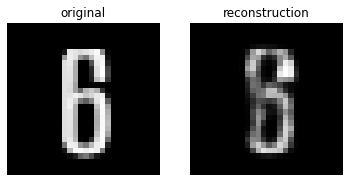

Generate a random image from the model:


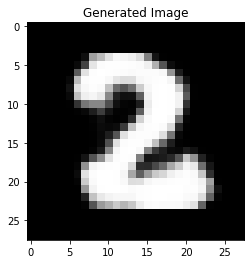

Intended digit:  2
Intended as handwritten:  False
Epoch: 1071 average training loss: 93.39832401885987
Epoch: 1072 average training loss: 93.37133126983643
Epoch: 1073 average training loss: 93.38865574493408
Epoch: 1074 average training loss: 93.37271765289307
Epoch: 1075 average training loss: 93.36555056915283
Epoch: 1076 average training loss: 93.38644348907471
Epoch: 1077 average training loss: 93.40343703155517
Epoch: 1078 average training loss: 93.38062634429932
Epoch: 1079 average training loss: 93.39459516143799
Epoch: 1080 average training loss: 93.39210116119385
Epoch: 1080 average test loss: 97.70715228271484
Comparing a random test image to its reconstruction:


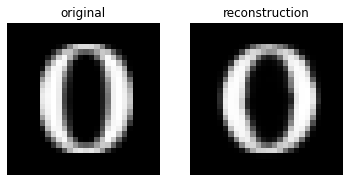

Generate a random image from the model:


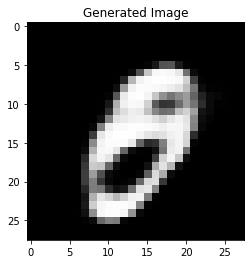

Intended digit:  8
Intended as handwritten:  False
Epoch: 1081 average training loss: 93.41095183868408
Epoch: 1082 average training loss: 93.34952620391846
Epoch: 1083 average training loss: 93.37714105987548
Epoch: 1084 average training loss: 93.3728386428833
Epoch: 1085 average training loss: 93.33206552276611
Epoch: 1086 average training loss: 93.38510187530518
Epoch: 1087 average training loss: 93.37613160552978
Epoch: 1088 average training loss: 93.36259240264893
Epoch: 1089 average training loss: 93.35155045928956
Epoch: 1090 average training loss: 93.3542751296997
Epoch: 1090 average test loss: 97.73803515625
Comparing a random test image to its reconstruction:


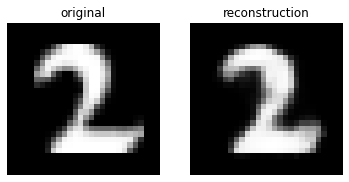

Generate a random image from the model:


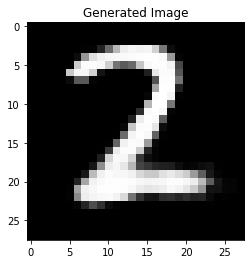

Intended digit:  2
Intended as handwritten:  False
Epoch: 1091 average training loss: 93.35109542999268
Epoch: 1092 average training loss: 93.35822123565674
Epoch: 1093 average training loss: 93.34067092437743
Epoch: 1094 average training loss: 93.37360688018799
Epoch: 1095 average training loss: 93.34717207183837
Epoch: 1096 average training loss: 93.36086457061768
Epoch: 1097 average training loss: 93.34857567901611
Epoch: 1098 average training loss: 93.36009386749268
Epoch: 1099 average training loss: 93.33203451690675
Epoch: 1100 average training loss: 93.34891659698486
Epoch: 1100 average test loss: 97.84500935668946
Comparing a random test image to its reconstruction:


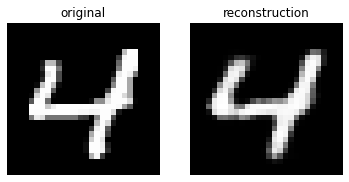

Generate a random image from the model:


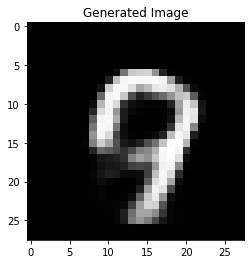

Intended digit:  9
Intended as handwritten:  False
Epoch: 1101 average training loss: 93.3473172317505
Epoch: 1102 average training loss: 93.33292279815674
Epoch: 1103 average training loss: 93.33205268096924
Epoch: 1104 average training loss: 93.34528305206298
Epoch: 1105 average training loss: 93.33506582183838
Epoch: 1106 average training loss: 93.34526563873291
Epoch: 1107 average training loss: 93.30783223419189
Epoch: 1108 average training loss: 93.35327592315674
Epoch: 1109 average training loss: 93.32543611602783
Epoch: 1110 average training loss: 93.34391613311767
Epoch: 1110 average test loss: 97.7860832763672
Comparing a random test image to its reconstruction:


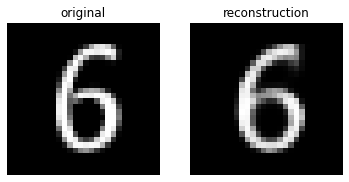

Generate a random image from the model:


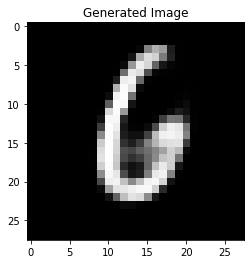

Intended digit:  6
Intended as handwritten:  False
Epoch: 1111 average training loss: 93.33113034820556
Epoch: 1112 average training loss: 93.33725072784424
Epoch: 1113 average training loss: 93.34598941192627
Epoch: 1114 average training loss: 93.3207198501587
Epoch: 1115 average training loss: 93.32039201202393
Epoch: 1116 average training loss: 93.33938869171142
Epoch: 1117 average training loss: 93.3520001235962
Epoch: 1118 average training loss: 93.33002704010009
Epoch: 1119 average training loss: 93.3206622756958
Epoch: 1120 average training loss: 93.31205177154541
Epoch: 1120 average test loss: 97.76115046386718
Comparing a random test image to its reconstruction:


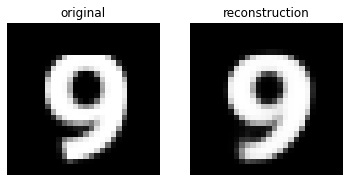

Generate a random image from the model:


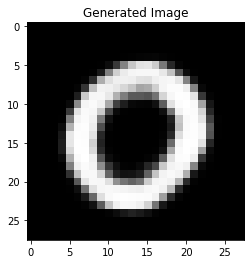

Intended digit:  0
Intended as handwritten:  False
Epoch: 1121 average training loss: 93.3192409439087
Epoch: 1122 average training loss: 93.31411530303956
Epoch: 1123 average training loss: 93.31883065948486
Epoch: 1124 average training loss: 93.30536498565674
Epoch: 1125 average training loss: 93.33477467193603
Epoch: 1126 average training loss: 93.30647193756103
Epoch: 1127 average training loss: 93.31091560211182
Epoch: 1128 average training loss: 93.29590170440675
Epoch: 1129 average training loss: 93.30643484039307
Epoch: 1130 average training loss: 93.35202365264892
Epoch: 1130 average test loss: 97.81151096191407
Comparing a random test image to its reconstruction:


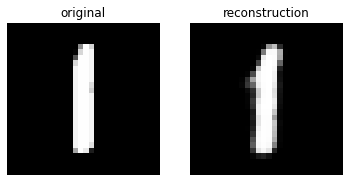

Generate a random image from the model:


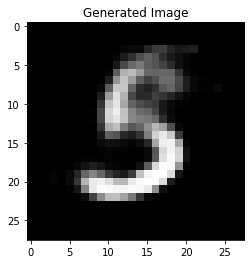

Intended digit:  5
Intended as handwritten:  False
Epoch: 1131 average training loss: 93.29027583770753
Epoch: 1132 average training loss: 93.31531275177002
Epoch: 1133 average training loss: 93.33991262969971
Epoch: 1134 average training loss: 93.31067860870361
Epoch: 1135 average training loss: 93.28178120269776
Epoch: 1136 average training loss: 93.31661820220947
Epoch: 1137 average training loss: 93.29860605010987
Epoch: 1138 average training loss: 93.3140980545044
Epoch: 1139 average training loss: 93.27110854034424
Epoch: 1140 average training loss: 93.29640041656494
Epoch: 1140 average test loss: 97.79957998657227
Comparing a random test image to its reconstruction:


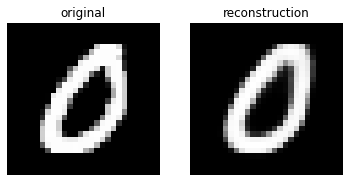

Generate a random image from the model:


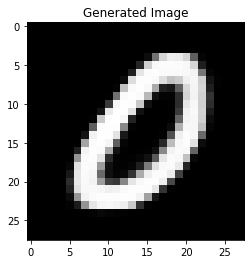

Intended digit:  0
Intended as handwritten:  False
Epoch: 1141 average training loss: 93.28222096710205
Epoch: 1142 average training loss: 93.2525969680786
Epoch: 1143 average training loss: 93.27803084869385
Epoch: 1144 average training loss: 93.28009035186767
Epoch: 1145 average training loss: 93.30125392608643
Epoch: 1146 average training loss: 93.30092373809815
Epoch: 1147 average training loss: 93.31022311553956
Epoch: 1148 average training loss: 93.28911089630127
Epoch: 1149 average training loss: 93.29612199249267
Epoch: 1150 average training loss: 93.27243015289307
Epoch: 1150 average test loss: 97.82291296386718
Comparing a random test image to its reconstruction:


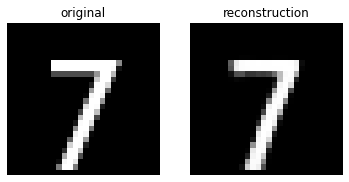

Generate a random image from the model:


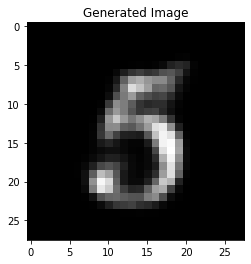

Intended digit:  5
Intended as handwritten:  False
Epoch: 1151 average training loss: 93.25876365509033
Epoch: 1152 average training loss: 93.27901004180909
Epoch: 1153 average training loss: 93.2661429397583
Epoch: 1154 average training loss: 93.27120251007081
Epoch: 1155 average training loss: 93.27557737579346
Epoch: 1156 average training loss: 93.27575556182862
Epoch: 1157 average training loss: 93.2446665359497
Epoch: 1158 average training loss: 93.28343647003175
Epoch: 1159 average training loss: 93.25565160675049
Epoch: 1160 average training loss: 93.28334840240478
Epoch: 1160 average test loss: 97.82488793334961
Comparing a random test image to its reconstruction:


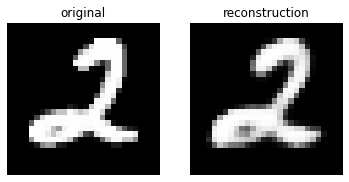

Generate a random image from the model:


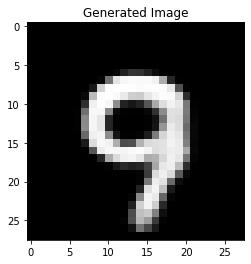

Intended digit:  9
Intended as handwritten:  False
Epoch: 1161 average training loss: 93.26577174224853
Epoch: 1162 average training loss: 93.26915553741455
Epoch: 1163 average training loss: 93.26799380645753
Epoch: 1164 average training loss: 93.30428271026611
Epoch: 1165 average training loss: 93.27367781524659
Epoch: 1166 average training loss: 93.23711125030518
Epoch: 1167 average training loss: 93.25988169708252
Epoch: 1168 average training loss: 93.26559379425049
Epoch: 1169 average training loss: 93.26834220733643
Epoch: 1170 average training loss: 93.26809953155518
Epoch: 1170 average test loss: 97.77388067016602
Comparing a random test image to its reconstruction:


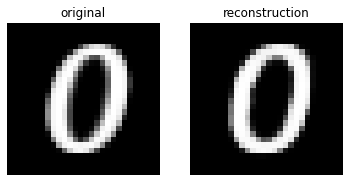

Generate a random image from the model:


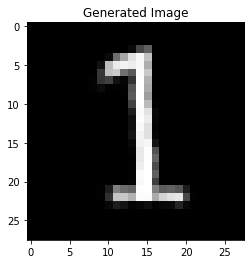

Intended digit:  1
Intended as handwritten:  False
Epoch: 1171 average training loss: 93.24047851104736
Epoch: 1172 average training loss: 93.22444449005127
Epoch: 1173 average training loss: 93.25132543487548
Epoch: 1174 average training loss: 93.25564202423095
Epoch: 1175 average training loss: 93.23096300811767
Epoch: 1176 average training loss: 93.28230252838135
Epoch: 1177 average training loss: 93.22959041290284
Epoch: 1178 average training loss: 93.25605437774658
Epoch: 1179 average training loss: 93.2483130142212
Epoch: 1180 average training loss: 93.21974018096924
Epoch: 1180 average test loss: 97.70963211669923
Comparing a random test image to its reconstruction:


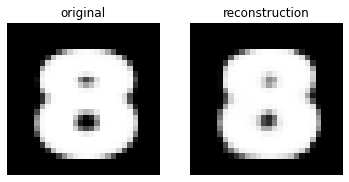

Generate a random image from the model:


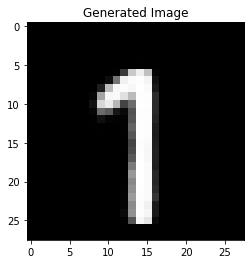

Intended digit:  1
Intended as handwritten:  False
Epoch: 1181 average training loss: 93.23172180938721
Epoch: 1182 average training loss: 93.23619795684814
Epoch: 1183 average training loss: 93.25809516143799
Epoch: 1184 average training loss: 93.24967808380127
Epoch: 1185 average training loss: 93.2310130569458
Epoch: 1186 average training loss: 93.24771354522706
Epoch: 1187 average training loss: 93.2663094619751
Epoch: 1188 average training loss: 93.23789804229736
Epoch: 1189 average training loss: 93.22562397003173
Epoch: 1190 average training loss: 93.24102469024658
Epoch: 1190 average test loss: 97.80285582275391
Comparing a random test image to its reconstruction:


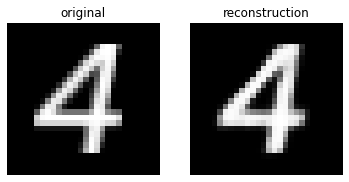

Generate a random image from the model:


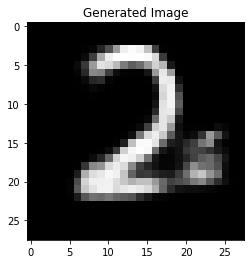

Intended digit:  2
Intended as handwritten:  False
Epoch: 1191 average training loss: 93.22867425689697
Epoch: 1192 average training loss: 93.24276743927003
Epoch: 1193 average training loss: 93.226780519104
Epoch: 1194 average training loss: 93.21637616729737
Epoch: 1195 average training loss: 93.22818045196533
Epoch: 1196 average training loss: 93.22595167388916
Epoch: 1197 average training loss: 93.23691354522705
Epoch: 1198 average training loss: 93.18450587921143
Epoch: 1199 average training loss: 93.22938170318604
Epoch: 1200 average training loss: 93.20200740509033
Epoch: 1200 average test loss: 97.81358024902343
Comparing a random test image to its reconstruction:


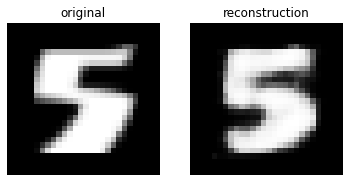

Generate a random image from the model:


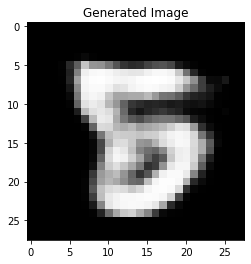

Intended digit:  5
Intended as handwritten:  False
Epoch: 1201 average training loss: 93.22862217559815
Epoch: 1202 average training loss: 93.23339903717041
Epoch: 1203 average training loss: 93.20857121124267
Epoch: 1204 average training loss: 93.21618900909424
Epoch: 1205 average training loss: 93.2269371170044
Epoch: 1206 average training loss: 93.23894591217041
Epoch: 1207 average training loss: 93.21385321807861
Epoch: 1208 average training loss: 93.21406006622314
Epoch: 1209 average training loss: 93.19389584503173
Epoch: 1210 average training loss: 93.18650476226807
Epoch: 1210 average test loss: 97.9458397644043
Comparing a random test image to its reconstruction:


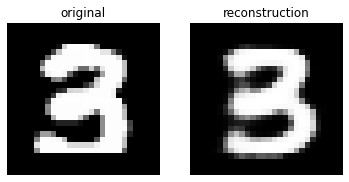

Generate a random image from the model:


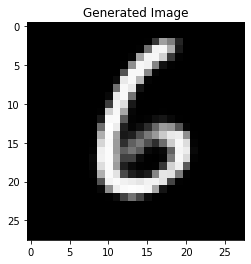

Intended digit:  6
Intended as handwritten:  False
Epoch: 1211 average training loss: 93.20471400299073
Epoch: 1212 average training loss: 93.21004524078369
Epoch: 1213 average training loss: 93.19325134429931
Epoch: 1214 average training loss: 93.20735603179932
Epoch: 1215 average training loss: 93.18827958526612
Epoch: 1216 average training loss: 93.22334031524659
Epoch: 1217 average training loss: 93.20097757720947
Epoch: 1218 average training loss: 93.2184220779419
Epoch: 1219 average training loss: 93.18631289215088
Epoch: 1220 average training loss: 93.18151238555909
Epoch: 1220 average test loss: 97.88956999511718
Comparing a random test image to its reconstruction:


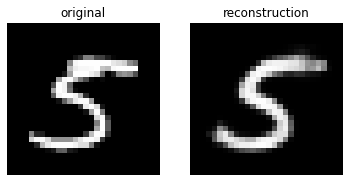

Generate a random image from the model:


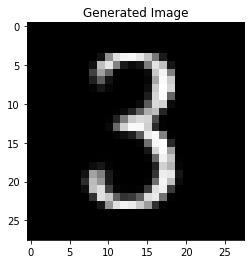

Intended digit:  3
Intended as handwritten:  False
Epoch: 1221 average training loss: 93.21840423736572
Epoch: 1222 average training loss: 93.20373661041259
Epoch: 1223 average training loss: 93.1957491531372
Epoch: 1224 average training loss: 93.19399967193604
Epoch: 1225 average training loss: 93.2107314529419
Epoch: 1226 average training loss: 93.18988822174072
Epoch: 1227 average training loss: 93.18989877471924
Epoch: 1228 average training loss: 93.22072648468017
Epoch: 1229 average training loss: 93.17393105010986
Epoch: 1230 average training loss: 93.1996349319458
Epoch: 1230 average test loss: 97.73789547119141
Comparing a random test image to its reconstruction:


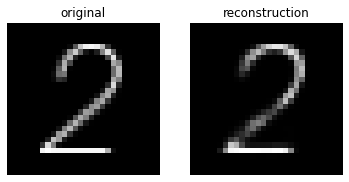

Generate a random image from the model:


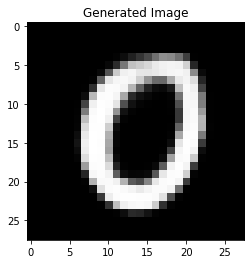

Intended digit:  0
Intended as handwritten:  False
Epoch: 1231 average training loss: 93.18925929718017
Epoch: 1232 average training loss: 93.18180131378173
Epoch: 1233 average training loss: 93.1851016067505
Epoch: 1234 average training loss: 93.16971154327392
Epoch: 1235 average training loss: 93.20879901885986
Epoch: 1236 average training loss: 93.21083271636962
Epoch: 1237 average training loss: 93.1889517288208
Epoch: 1238 average training loss: 93.16928037261962
Epoch: 1239 average training loss: 93.15948009796142
Epoch: 1240 average training loss: 93.18318892364502
Epoch: 1240 average test loss: 97.88130812988281
Comparing a random test image to its reconstruction:


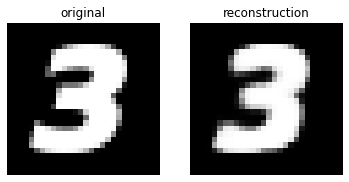

Generate a random image from the model:


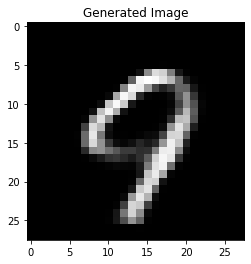

Intended digit:  9
Intended as handwritten:  False
Epoch: 1241 average training loss: 93.14091179962158
Epoch: 1242 average training loss: 93.17538129425049
Epoch: 1243 average training loss: 93.1617611038208
Epoch: 1244 average training loss: 93.14952182159423
Epoch: 1245 average training loss: 93.16436447906494
Epoch: 1246 average training loss: 93.17188321075439
Epoch: 1247 average training loss: 93.16769939727783
Epoch: 1248 average training loss: 93.1671239944458
Epoch: 1249 average training loss: 93.1570123123169
Epoch: 1250 average training loss: 93.19170435943603
Epoch: 1250 average test loss: 97.82054113769532
Comparing a random test image to its reconstruction:


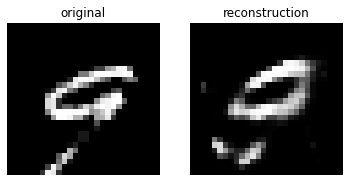

Generate a random image from the model:


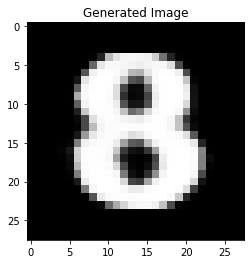

Intended digit:  8
Intended as handwritten:  False
Epoch: 1251 average training loss: 93.16937934112549
Epoch: 1252 average training loss: 93.16314182281494
Epoch: 1253 average training loss: 93.16568002471924
Epoch: 1254 average training loss: 93.14780843048095
Epoch: 1255 average training loss: 93.16027478790284
Epoch: 1256 average training loss: 93.1530636856079
Epoch: 1257 average training loss: 93.14819517974854
Epoch: 1258 average training loss: 93.16021178131103
Epoch: 1259 average training loss: 93.17299358673095
Epoch: 1260 average training loss: 93.1505894241333
Epoch: 1260 average test loss: 97.9282073059082
Comparing a random test image to its reconstruction:


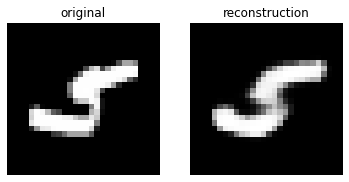

Generate a random image from the model:


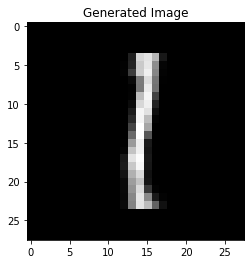

Intended digit:  1
Intended as handwritten:  False
Epoch: 1261 average training loss: 93.15518261260986
Epoch: 1262 average training loss: 93.1508863357544
Epoch: 1263 average training loss: 93.13043963775635
Epoch: 1264 average training loss: 93.1351796218872
Epoch: 1265 average training loss: 93.17091635284424
Epoch: 1266 average training loss: 93.14492030792236
Epoch: 1267 average training loss: 93.1448794998169
Epoch: 1268 average training loss: 93.15855110626221
Epoch: 1269 average training loss: 93.16860846710205
Epoch: 1270 average training loss: 93.15459810333252
Epoch: 1270 average test loss: 97.84068487548828
Comparing a random test image to its reconstruction:


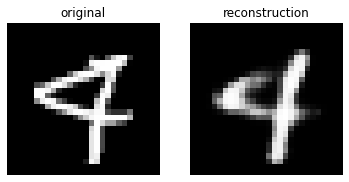

Generate a random image from the model:


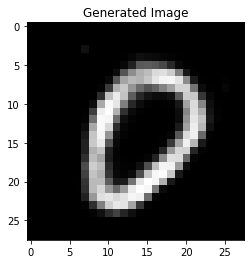

Intended digit:  0
Intended as handwritten:  False
Epoch: 1271 average training loss: 93.11558874053955
Epoch: 1272 average training loss: 93.1485198928833
Epoch: 1273 average training loss: 93.12478623809814
Epoch: 1274 average training loss: 93.12088526153565
Epoch: 1275 average training loss: 93.17204167633056
Epoch: 1276 average training loss: 93.13662221221924
Epoch: 1277 average training loss: 93.12331974639892
Epoch: 1278 average training loss: 93.16004221954346
Epoch: 1279 average training loss: 93.15046021881103
Epoch: 1280 average training loss: 93.14283430938721
Epoch: 1280 average test loss: 97.97576759643555
Comparing a random test image to its reconstruction:


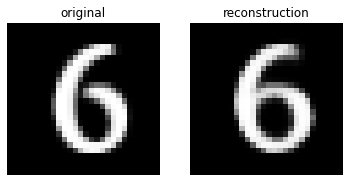

Generate a random image from the model:


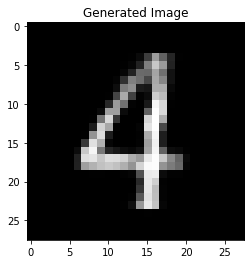

Intended digit:  4
Intended as handwritten:  False
Epoch: 1281 average training loss: 93.14439151153564
Epoch: 1282 average training loss: 93.1056241470337
Epoch: 1283 average training loss: 93.14504236602784
Epoch: 1284 average training loss: 93.13531187286377
Epoch: 1285 average training loss: 93.14060293121338
Epoch: 1286 average training loss: 93.11265034332276
Epoch: 1287 average training loss: 93.11274853057861
Epoch: 1288 average training loss: 93.11830881500244
Epoch: 1289 average training loss: 93.11140564727783
Epoch: 1290 average training loss: 93.13047213287354
Epoch: 1290 average test loss: 97.90783682861328
Comparing a random test image to its reconstruction:


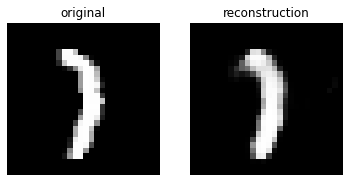

Generate a random image from the model:


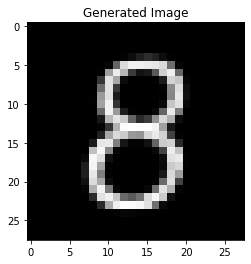

Intended digit:  8
Intended as handwritten:  False
Epoch: 1291 average training loss: 93.0925015701294
Epoch: 1292 average training loss: 93.12338471221923
Epoch: 1293 average training loss: 93.11498510894775
Epoch: 1294 average training loss: 93.11005384674073
Epoch: 1295 average training loss: 93.1617056350708
Epoch: 1296 average training loss: 93.09251841583252
Epoch: 1297 average training loss: 93.12342874298096
Epoch: 1298 average training loss: 93.10026844024658
Epoch: 1299 average training loss: 93.09276392974853
Epoch: 1300 average training loss: 93.10887273712159
Epoch: 1300 average test loss: 97.94896467285156
Comparing a random test image to its reconstruction:


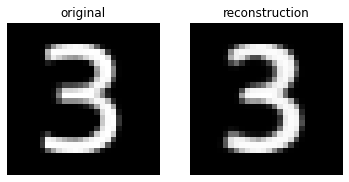

Generate a random image from the model:


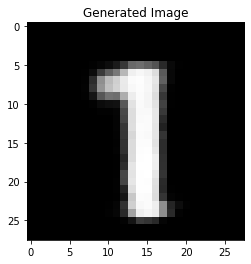

Intended digit:  1
Intended as handwritten:  False
Epoch: 1301 average training loss: 93.13153206329346
Epoch: 1302 average training loss: 93.09655306549072
Epoch: 1303 average training loss: 93.12401513214111
Epoch: 1304 average training loss: 93.13067851104736
Epoch: 1305 average training loss: 93.10642167510986
Epoch: 1306 average training loss: 93.10313525543214
Epoch: 1307 average training loss: 93.12626676177979
Epoch: 1308 average training loss: 93.11900591583252
Epoch: 1309 average training loss: 93.12661820220947
Epoch: 1310 average training loss: 93.11885763702392
Epoch: 1310 average test loss: 98.03479229736328
Comparing a random test image to its reconstruction:


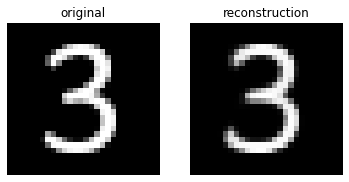

Generate a random image from the model:


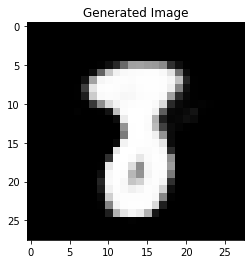

Intended digit:  8
Intended as handwritten:  False
Epoch: 1311 average training loss: 93.12861820220947
Epoch: 1312 average training loss: 93.10622550201415
Epoch: 1313 average training loss: 93.104046144104
Epoch: 1314 average training loss: 93.0906380935669
Epoch: 1315 average training loss: 93.08121457061768
Epoch: 1316 average training loss: 93.09157490386963
Epoch: 1317 average training loss: 93.0843590713501
Epoch: 1318 average training loss: 93.08270503692627
Epoch: 1319 average training loss: 93.10788498077393
Epoch: 1320 average training loss: 93.09246436309814
Epoch: 1320 average test loss: 98.04488389892578
Comparing a random test image to its reconstruction:


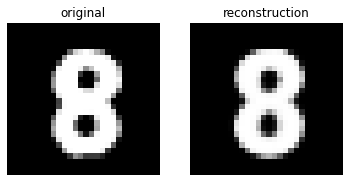

Generate a random image from the model:


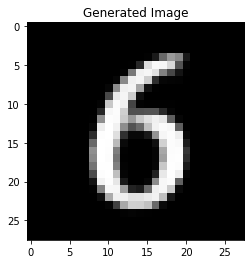

Intended digit:  6
Intended as handwritten:  False
Epoch: 1321 average training loss: 93.09660115509033
Epoch: 1322 average training loss: 93.1016289138794
Epoch: 1323 average training loss: 93.09523739776611
Epoch: 1324 average training loss: 93.09271505889893
Epoch: 1325 average training loss: 93.09479803009033
Epoch: 1326 average training loss: 93.07941529083251
Epoch: 1327 average training loss: 93.08289548492432
Epoch: 1328 average training loss: 93.06738589630127
Epoch: 1329 average training loss: 93.08993100128174
Epoch: 1330 average training loss: 93.06648474884034
Epoch: 1330 average test loss: 97.9355453491211
Comparing a random test image to its reconstruction:


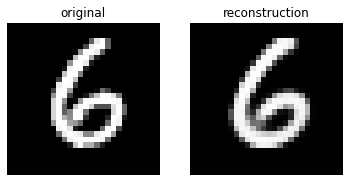

Generate a random image from the model:


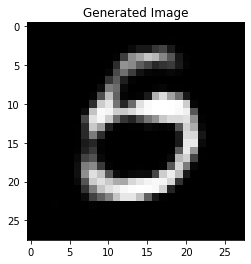

Intended digit:  6
Intended as handwritten:  False
Epoch: 1331 average training loss: 93.09548131256103
Epoch: 1332 average training loss: 93.0874402053833
Epoch: 1333 average training loss: 93.08150651397705
Epoch: 1334 average training loss: 93.05700381622314
Epoch: 1335 average training loss: 93.07531870880128
Epoch: 1336 average training loss: 93.07016143951417
Epoch: 1337 average training loss: 93.05450960235596
Epoch: 1338 average training loss: 93.039368800354
Epoch: 1339 average training loss: 93.07603365020752
Epoch: 1340 average training loss: 93.09799898223876
Epoch: 1340 average test loss: 98.0954080078125
Comparing a random test image to its reconstruction:


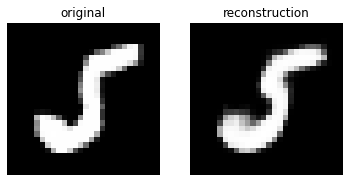

Generate a random image from the model:


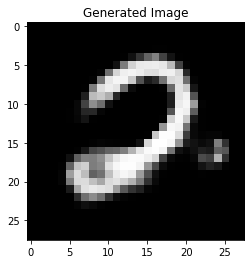

Intended digit:  2
Intended as handwritten:  False
Epoch: 1341 average training loss: 93.09913908233642
Epoch: 1342 average training loss: 93.05379765777587
Epoch: 1343 average training loss: 93.05885453643799
Epoch: 1344 average training loss: 93.05360913848877
Epoch: 1345 average training loss: 93.08297796173096
Epoch: 1346 average training loss: 93.08078723907471
Epoch: 1347 average training loss: 93.04021295928955
Epoch: 1348 average training loss: 93.10058261260987
Epoch: 1349 average training loss: 93.0861297012329
Epoch: 1350 average training loss: 93.04934752349854
Epoch: 1350 average test loss: 98.043619140625
Comparing a random test image to its reconstruction:


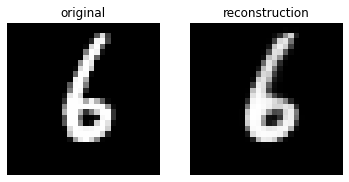

Generate a random image from the model:


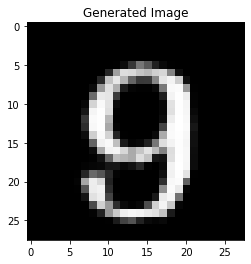

Intended digit:  9
Intended as handwritten:  False
Epoch: 1351 average training loss: 93.06324454498291
Epoch: 1352 average training loss: 93.05449103546142
Epoch: 1353 average training loss: 93.09331452789307
Epoch: 1354 average training loss: 93.07132288360596
Epoch: 1355 average training loss: 93.0242126663208
Epoch: 1356 average training loss: 93.038416847229
Epoch: 1357 average training loss: 93.06890193634034
Epoch: 1358 average training loss: 93.0569349319458
Epoch: 1359 average training loss: 93.07273463897705
Epoch: 1360 average training loss: 93.06309587554932
Epoch: 1360 average test loss: 97.87228839721679
Comparing a random test image to its reconstruction:


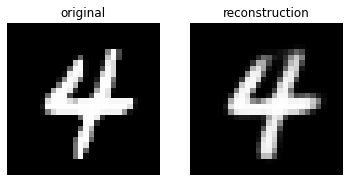

Generate a random image from the model:


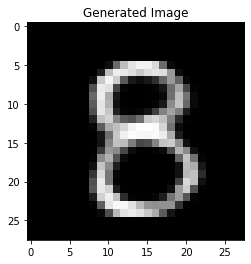

Intended digit:  8
Intended as handwritten:  False
Epoch: 1361 average training loss: 93.0772529434204
Epoch: 1362 average training loss: 93.07396050567627
Epoch: 1363 average training loss: 93.05602404937744
Epoch: 1364 average training loss: 93.04028698883057
Epoch: 1365 average training loss: 93.01258991241455
Epoch: 1366 average training loss: 93.02973483428956
Epoch: 1367 average training loss: 93.05147104644776
Epoch: 1368 average training loss: 93.04231542510986
Epoch: 1369 average training loss: 93.01310945587159
Epoch: 1370 average training loss: 93.02983929595948
Epoch: 1370 average test loss: 98.03744924926758
Comparing a random test image to its reconstruction:


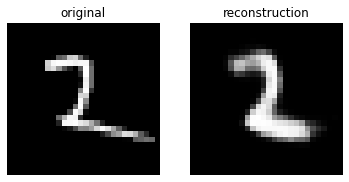

Generate a random image from the model:


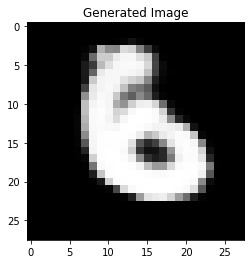

Intended digit:  6
Intended as handwritten:  False
Epoch: 1371 average training loss: 93.05377215118408
Epoch: 1372 average training loss: 93.04480010528565
Epoch: 1373 average training loss: 93.00761407623291
Epoch: 1374 average training loss: 93.02326665802002
Epoch: 1375 average training loss: 93.03165207061768
Epoch: 1376 average training loss: 93.02880659942628
Epoch: 1377 average training loss: 93.01373461456299
Epoch: 1378 average training loss: 93.03413863677979
Epoch: 1379 average training loss: 93.05299038238526
Epoch: 1380 average training loss: 93.02105681915283
Epoch: 1380 average test loss: 98.13302976074219
Comparing a random test image to its reconstruction:


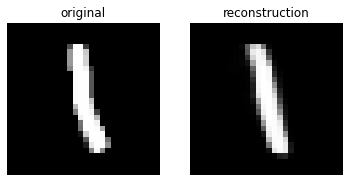

Generate a random image from the model:


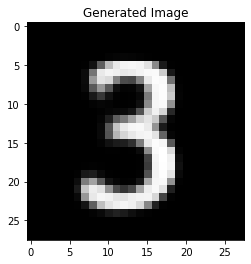

Intended digit:  3
Intended as handwritten:  False
Epoch: 1381 average training loss: 93.05322155303955
Epoch: 1382 average training loss: 93.05463687286377
Epoch: 1383 average training loss: 93.0255348526001
Epoch: 1384 average training loss: 93.02673405303955
Epoch: 1385 average training loss: 93.04929154815675
Epoch: 1386 average training loss: 93.01891464996338
Epoch: 1387 average training loss: 93.04732033233643
Epoch: 1388 average training loss: 93.02478496856689
Epoch: 1389 average training loss: 93.01701624908448
Epoch: 1390 average training loss: 93.01866773223877
Epoch: 1390 average test loss: 98.12160179443359
Comparing a random test image to its reconstruction:


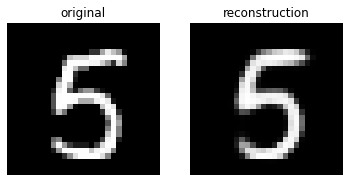

Generate a random image from the model:


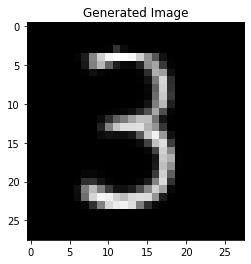

Intended digit:  3
Intended as handwritten:  False
Epoch: 1391 average training loss: 93.00248367462159
Epoch: 1392 average training loss: 93.00602506256104
Epoch: 1393 average training loss: 93.02564402008056
Epoch: 1394 average training loss: 93.01360511016846
Epoch: 1395 average training loss: 93.01790454864502
Epoch: 1396 average training loss: 93.02845030059814
Epoch: 1397 average training loss: 93.01365173492432
Epoch: 1398 average training loss: 93.02480843658448
Epoch: 1399 average training loss: 92.9870428237915
Epoch: 1400 average training loss: 93.01968378448487
Epoch: 1400 average test loss: 97.92208950195312
Comparing a random test image to its reconstruction:


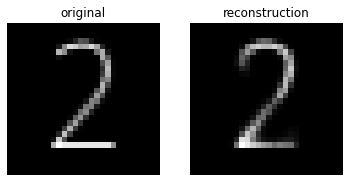

Generate a random image from the model:


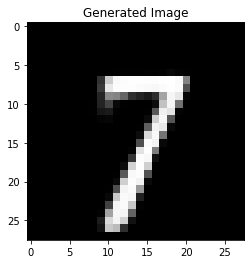

Intended digit:  7
Intended as handwritten:  False
Epoch: 1401 average training loss: 92.995144380188
Epoch: 1402 average training loss: 93.02459372711182
Epoch: 1403 average training loss: 93.0010547744751
Epoch: 1404 average training loss: 92.98968435821533
Epoch: 1405 average training loss: 92.9880255569458
Epoch: 1406 average training loss: 93.0126818069458
Epoch: 1407 average training loss: 93.00016493682861
Epoch: 1408 average training loss: 93.01311605987549
Epoch: 1409 average training loss: 93.00981682281494
Epoch: 1410 average training loss: 93.00973075714111
Epoch: 1410 average test loss: 98.04441055908202
Comparing a random test image to its reconstruction:


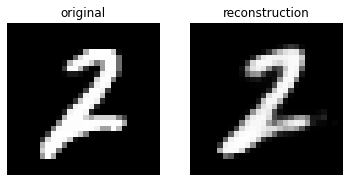

Generate a random image from the model:


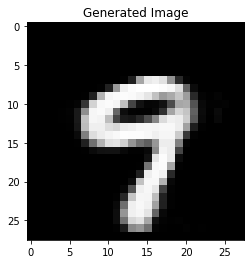

Intended digit:  9
Intended as handwritten:  False
Epoch: 1411 average training loss: 92.99247780914307
Epoch: 1412 average training loss: 93.00959776763916
Epoch: 1413 average training loss: 92.9995029800415
Epoch: 1414 average training loss: 92.9984785598755
Epoch: 1415 average training loss: 93.00304907989502
Epoch: 1416 average training loss: 93.0146512588501
Epoch: 1417 average training loss: 93.0058413406372
Epoch: 1418 average training loss: 92.99621095123291
Epoch: 1419 average training loss: 92.99564462432862
Epoch: 1420 average training loss: 92.98711115875244
Epoch: 1420 average test loss: 98.05963842163086
Comparing a random test image to its reconstruction:


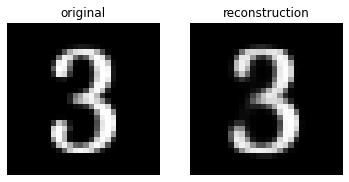

Generate a random image from the model:


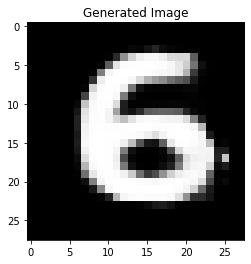

Intended digit:  6
Intended as handwritten:  False
Epoch: 1421 average training loss: 92.99219690093994
Epoch: 1422 average training loss: 92.96772765655517
Epoch: 1423 average training loss: 92.99118596954345
Epoch: 1424 average training loss: 92.98788963165283
Epoch: 1425 average training loss: 92.99247374420166
Epoch: 1426 average training loss: 92.99757800445556
Epoch: 1427 average training loss: 92.97624070587158
Epoch: 1428 average training loss: 93.00623360748291
Epoch: 1429 average training loss: 92.98052643585206
Epoch: 1430 average training loss: 92.98628579254151
Epoch: 1430 average test loss: 98.09206204833984
Comparing a random test image to its reconstruction:


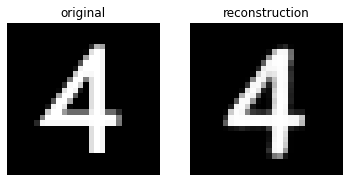

Generate a random image from the model:


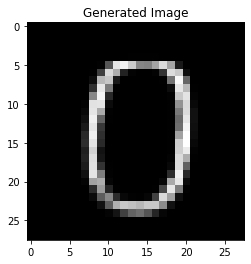

Intended digit:  0
Intended as handwritten:  False
Epoch: 1431 average training loss: 92.97751134796142
Epoch: 1432 average training loss: 92.96435609283448
Epoch: 1433 average training loss: 92.9830029373169
Epoch: 1434 average training loss: 92.99218672027588
Epoch: 1435 average training loss: 92.97730214385986
Epoch: 1436 average training loss: 92.99087124786377
Epoch: 1437 average training loss: 92.98125152130127
Epoch: 1438 average training loss: 92.98933898468017
Epoch: 1439 average training loss: 92.98566604766846
Epoch: 1440 average training loss: 92.94846197662353
Epoch: 1440 average test loss: 98.05803681640624
Comparing a random test image to its reconstruction:


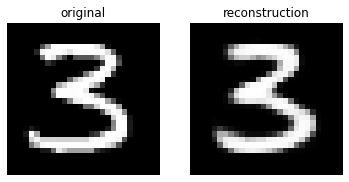

Generate a random image from the model:


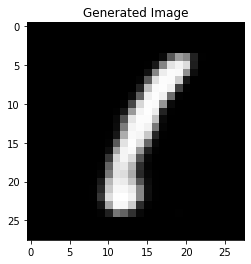

Intended digit:  1
Intended as handwritten:  False
Epoch: 1441 average training loss: 92.98191737213135
Epoch: 1442 average training loss: 92.96771363677979
Epoch: 1443 average training loss: 92.96895169219971
Epoch: 1444 average training loss: 92.96286797027588
Epoch: 1445 average training loss: 92.97416454620361
Epoch: 1446 average training loss: 92.97285373077392
Epoch: 1447 average training loss: 92.95465119781494
Epoch: 1448 average training loss: 92.95765917510987
Epoch: 1449 average training loss: 92.95722326202393
Epoch: 1450 average training loss: 92.9695107131958
Epoch: 1450 average test loss: 98.1947621459961
Comparing a random test image to its reconstruction:


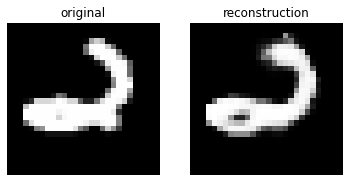

Generate a random image from the model:


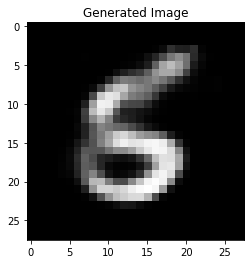

Intended digit:  5
Intended as handwritten:  False
Epoch: 1451 average training loss: 92.97378514556885
Epoch: 1452 average training loss: 92.98362397003174
Epoch: 1453 average training loss: 93.002266065979
Epoch: 1454 average training loss: 92.960375831604
Epoch: 1455 average training loss: 92.9753054397583
Epoch: 1456 average training loss: 92.95696037139892
Epoch: 1457 average training loss: 92.96257273712158
Epoch: 1458 average training loss: 92.95113112945556
Epoch: 1459 average training loss: 92.94557254180909
Epoch: 1460 average training loss: 92.97917965240478
Epoch: 1460 average test loss: 98.15932928466796
Comparing a random test image to its reconstruction:


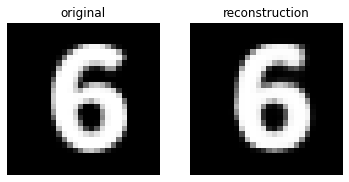

Generate a random image from the model:


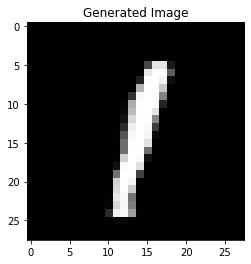

Intended digit:  1
Intended as handwritten:  False
Epoch: 1461 average training loss: 92.94262123565674
Epoch: 1462 average training loss: 92.96107323760987
Epoch: 1463 average training loss: 92.95319312286377
Epoch: 1464 average training loss: 92.94895350494384
Epoch: 1465 average training loss: 92.94449583282471
Epoch: 1466 average training loss: 92.94243607330323
Epoch: 1467 average training loss: 92.94062253570557
Epoch: 1468 average training loss: 92.95318584747315
Epoch: 1469 average training loss: 92.94417267608642
Epoch: 1470 average training loss: 92.9736521194458
Epoch: 1470 average test loss: 98.14541177368164
Comparing a random test image to its reconstruction:


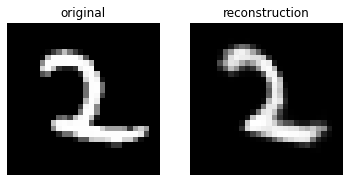

Generate a random image from the model:


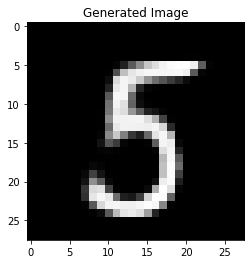

Intended digit:  5
Intended as handwritten:  False
Epoch: 1471 average training loss: 92.96259892120361
Epoch: 1472 average training loss: 92.93388826446534
Epoch: 1473 average training loss: 92.9645213760376
Epoch: 1474 average training loss: 92.95080912628174
Epoch: 1475 average training loss: 92.97134013824463
Epoch: 1476 average training loss: 92.93058694000244
Epoch: 1477 average training loss: 92.94804113311767
Epoch: 1478 average training loss: 92.93016845245361
Epoch: 1479 average training loss: 92.92138739166259
Epoch: 1480 average training loss: 92.92650502471923
Epoch: 1480 average test loss: 98.01843739013673
Comparing a random test image to its reconstruction:


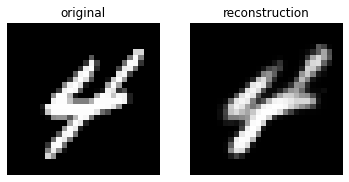

Generate a random image from the model:


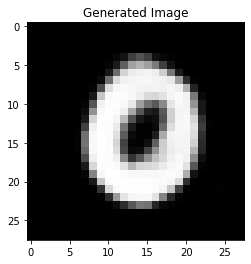

Intended digit:  0
Intended as handwritten:  False
Epoch: 1481 average training loss: 92.92755370635986
Epoch: 1482 average training loss: 92.91945312652588
Epoch: 1483 average training loss: 92.94068643951417
Epoch: 1484 average training loss: 92.95735275421143
Epoch: 1485 average training loss: 92.9453665359497
Epoch: 1486 average training loss: 92.93107749176025
Epoch: 1487 average training loss: 92.93537345733642
Epoch: 1488 average training loss: 92.94685403594971
Epoch: 1489 average training loss: 92.92600949249268
Epoch: 1490 average training loss: 92.93138529815674
Epoch: 1490 average test loss: 98.14524571533204
Comparing a random test image to its reconstruction:


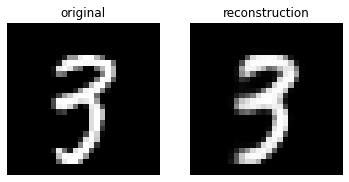

Generate a random image from the model:


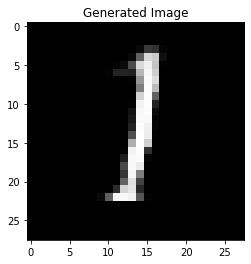

Intended digit:  1
Intended as handwritten:  False
Epoch: 1491 average training loss: 92.9357299758911
Epoch: 1492 average training loss: 92.91990662384033
Epoch: 1493 average training loss: 92.9206807937622
Epoch: 1494 average training loss: 92.893224659729
Epoch: 1495 average training loss: 92.9699239578247
Epoch: 1496 average training loss: 92.94702108917237
Epoch: 1497 average training loss: 92.92141829986572
Epoch: 1498 average training loss: 92.91555998687744
Epoch: 1499 average training loss: 92.93777229156494
Epoch: 1500 average training loss: 92.92075764923095
Epoch: 1500 average test loss: 98.14501146240234
Comparing a random test image to its reconstruction:


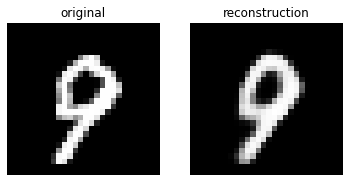

Generate a random image from the model:


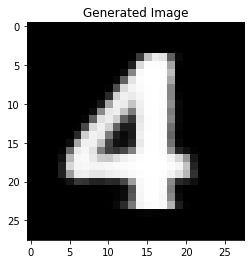

Intended digit:  4
Intended as handwritten:  False
Epoch: 1501 average training loss: 92.91226116485596
Epoch: 1502 average training loss: 92.9514206741333
Epoch: 1503 average training loss: 92.93134609527588
Epoch: 1504 average training loss: 92.92903043365479
Epoch: 1505 average training loss: 92.93012244415283
Epoch: 1506 average training loss: 92.94759380645752
Epoch: 1507 average training loss: 92.88361584014892
Epoch: 1508 average training loss: 92.92147386627197
Epoch: 1509 average training loss: 92.91027801055908
Epoch: 1510 average training loss: 92.92016809844971
Epoch: 1510 average test loss: 98.06998713989258
Comparing a random test image to its reconstruction:


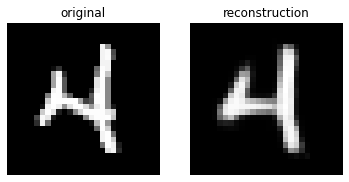

Generate a random image from the model:


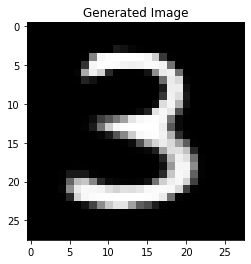

Intended digit:  3
Intended as handwritten:  False
Epoch: 1511 average training loss: 92.95021975860595
Epoch: 1512 average training loss: 92.93495440216064
Epoch: 1513 average training loss: 92.89336658477784
Epoch: 1514 average training loss: 92.90908838653564
Epoch: 1515 average training loss: 92.90394060211182
Epoch: 1516 average training loss: 92.92816242218018
Epoch: 1517 average training loss: 92.94050741729737
Epoch: 1518 average training loss: 92.92238999176026
Epoch: 1519 average training loss: 92.91894794464112
Epoch: 1520 average training loss: 92.90471841583252
Epoch: 1520 average test loss: 98.04329895629883
Comparing a random test image to its reconstruction:


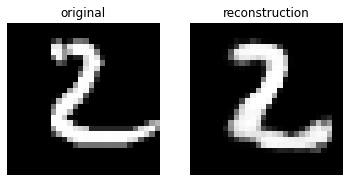

Generate a random image from the model:


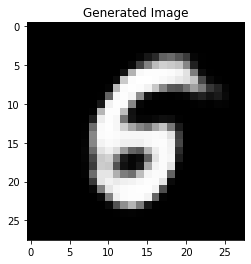

Intended digit:  5
Intended as handwritten:  False
Epoch: 1521 average training loss: 92.8896287612915
Epoch: 1522 average training loss: 92.89185735015869
Epoch: 1523 average training loss: 92.92114641265869
Epoch: 1524 average training loss: 92.89751220245361
Epoch: 1525 average training loss: 92.89392879180909
Epoch: 1526 average training loss: 92.91202556915283
Epoch: 1527 average training loss: 92.90629518585204
Epoch: 1528 average training loss: 92.89991132965088
Epoch: 1529 average training loss: 92.89934539337158
Epoch: 1530 average training loss: 92.93497827911376
Epoch: 1530 average test loss: 98.16159560546875
Comparing a random test image to its reconstruction:


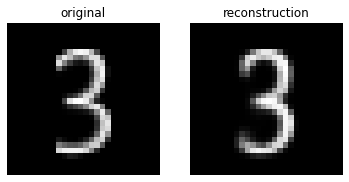

Generate a random image from the model:


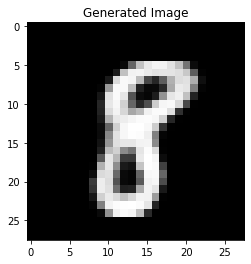

Intended digit:  8
Intended as handwritten:  False
Epoch: 1531 average training loss: 92.89876945343018
Epoch: 1532 average training loss: 92.93068576812745
Epoch: 1533 average training loss: 92.89607584991455
Epoch: 1534 average training loss: 92.89131297149659
Epoch: 1535 average training loss: 92.88566951446533
Epoch: 1536 average training loss: 92.88935078277588
Epoch: 1537 average training loss: 92.90698039703369
Epoch: 1538 average training loss: 92.90366906280518
Epoch: 1539 average training loss: 92.88869627838135
Epoch: 1540 average training loss: 92.90645822906494
Epoch: 1540 average test loss: 98.25311396484375
Comparing a random test image to its reconstruction:


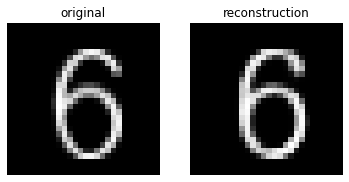

Generate a random image from the model:


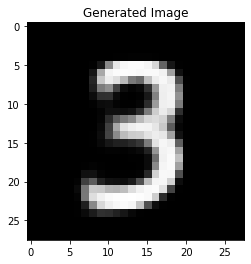

Intended digit:  3
Intended as handwritten:  False
Epoch: 1541 average training loss: 92.88552245025635
Epoch: 1542 average training loss: 92.89002179107666
Epoch: 1543 average training loss: 92.8827639968872
Epoch: 1544 average training loss: 92.90650982818603
Epoch: 1545 average training loss: 92.88980862579346
Epoch: 1546 average training loss: 92.8961889968872
Epoch: 1547 average training loss: 92.90416789703369
Epoch: 1548 average training loss: 92.89027478790283
Epoch: 1549 average training loss: 92.87733006134033
Epoch: 1550 average training loss: 92.90640182037353
Epoch: 1550 average test loss: 98.31715543823242
Comparing a random test image to its reconstruction:


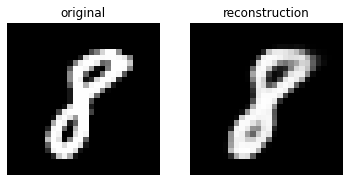

Generate a random image from the model:


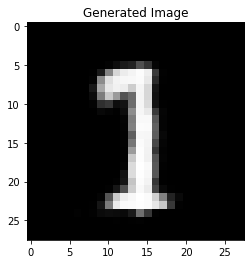

Intended digit:  1
Intended as handwritten:  False
Epoch: 1551 average training loss: 92.8831816116333
Epoch: 1552 average training loss: 92.87536846466064
Epoch: 1553 average training loss: 92.8893401687622
Epoch: 1554 average training loss: 92.88738288726806
Epoch: 1555 average training loss: 92.90415240631104
Epoch: 1556 average training loss: 92.88610995635986
Epoch: 1557 average training loss: 92.8886384475708
Epoch: 1558 average training loss: 92.88348686676025
Epoch: 1559 average training loss: 92.88211157989502
Epoch: 1560 average training loss: 92.8810956314087
Epoch: 1560 average test loss: 98.19985852050782
Comparing a random test image to its reconstruction:


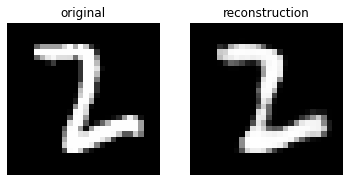

Generate a random image from the model:


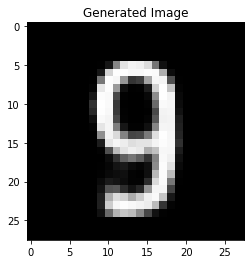

Intended digit:  9
Intended as handwritten:  False
Epoch: 1561 average training loss: 92.86286906280517
Epoch: 1562 average training loss: 92.88523657989502
Epoch: 1563 average training loss: 92.88683010406494
Epoch: 1564 average training loss: 92.87918943634033
Epoch: 1565 average training loss: 92.87833158721924
Epoch: 1566 average training loss: 92.88261960601807
Epoch: 1567 average training loss: 92.88637964630126
Epoch: 1568 average training loss: 92.8654021194458
Epoch: 1569 average training loss: 92.86588113555908
Epoch: 1570 average training loss: 92.84796536407471
Epoch: 1570 average test loss: 98.07439804077148
Comparing a random test image to its reconstruction:


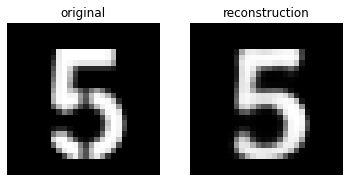

Generate a random image from the model:


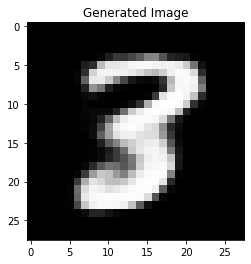

Intended digit:  3
Intended as handwritten:  False
Epoch: 1571 average training loss: 92.89558866729736
Epoch: 1572 average training loss: 92.8668438369751
Epoch: 1573 average training loss: 92.8218880569458
Epoch: 1574 average training loss: 92.85821365509034
Epoch: 1575 average training loss: 92.87313850860596
Epoch: 1576 average training loss: 92.84360222930908
Epoch: 1577 average training loss: 92.86806772613525
Epoch: 1578 average training loss: 92.84497113800049
Epoch: 1579 average training loss: 92.87113705596924
Epoch: 1580 average training loss: 92.85829945831298
Epoch: 1580 average test loss: 98.13182401123046
Comparing a random test image to its reconstruction:


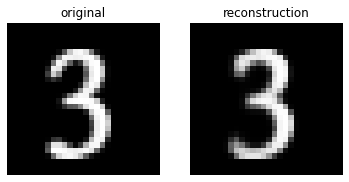

Generate a random image from the model:


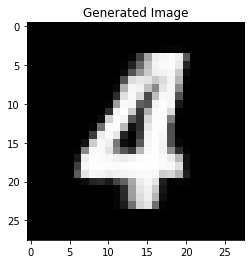

Intended digit:  4
Intended as handwritten:  False
Epoch: 1581 average training loss: 92.85343111724853
Epoch: 1582 average training loss: 92.85363695831299
Epoch: 1583 average training loss: 92.87146513214111
Epoch: 1584 average training loss: 92.85580449371338
Epoch: 1585 average training loss: 92.87172052154541
Epoch: 1586 average training loss: 92.87118928985596
Epoch: 1587 average training loss: 92.85044890899658
Epoch: 1588 average training loss: 92.86187209014892
Epoch: 1589 average training loss: 92.84157621612549
Epoch: 1590 average training loss: 92.84483461456298
Epoch: 1590 average test loss: 98.07564157714843
Comparing a random test image to its reconstruction:


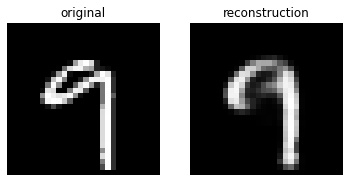

Generate a random image from the model:


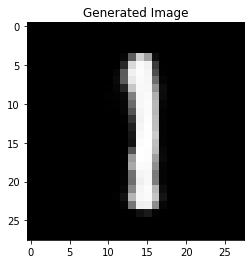

Intended digit:  1
Intended as handwritten:  False
Epoch: 1591 average training loss: 92.83209810333251
Epoch: 1592 average training loss: 92.85704075469971
Epoch: 1593 average training loss: 92.83305432891845
Epoch: 1594 average training loss: 92.85973413848878
Epoch: 1595 average training loss: 92.85613625640869
Epoch: 1596 average training loss: 92.85262811431885
Epoch: 1597 average training loss: 92.84421378936767
Epoch: 1598 average training loss: 92.81294897613526
Epoch: 1599 average training loss: 92.8382991897583
Epoch: 1600 average training loss: 92.87363261260987
Epoch: 1600 average test loss: 98.07812895507813
Comparing a random test image to its reconstruction:


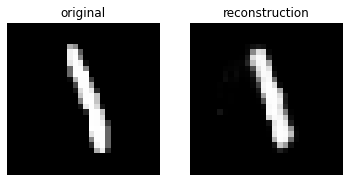

Generate a random image from the model:


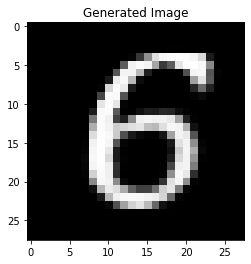

Intended digit:  6
Intended as handwritten:  False
Epoch: 1601 average training loss: 92.87416532745361
Epoch: 1602 average training loss: 92.83968791046142
Epoch: 1603 average training loss: 92.81902711334229
Epoch: 1604 average training loss: 92.82765296783447
Epoch: 1605 average training loss: 92.86036189117432
Epoch: 1606 average training loss: 92.86148618927002
Epoch: 1607 average training loss: 92.86686494903564
Epoch: 1608 average training loss: 92.85119806671142
Epoch: 1609 average training loss: 92.84547447052002
Epoch: 1610 average training loss: 92.81276720733642
Epoch: 1610 average test loss: 98.36242595214844
Comparing a random test image to its reconstruction:


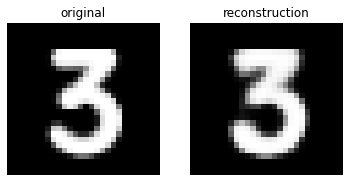

Generate a random image from the model:


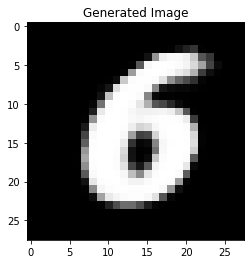

Intended digit:  6
Intended as handwritten:  False
Epoch: 1611 average training loss: 92.82367345733643
Epoch: 1612 average training loss: 92.84133026885986
Epoch: 1613 average training loss: 92.84272320098877
Epoch: 1614 average training loss: 92.82752902374267
Epoch: 1615 average training loss: 92.81827572174072
Epoch: 1616 average training loss: 92.81685240631103
Epoch: 1617 average training loss: 92.84969821319581
Epoch: 1618 average training loss: 92.83553204498291
Epoch: 1619 average training loss: 92.85285573272705
Epoch: 1620 average training loss: 92.8355864151001
Epoch: 1620 average test loss: 98.47167706298828
Comparing a random test image to its reconstruction:


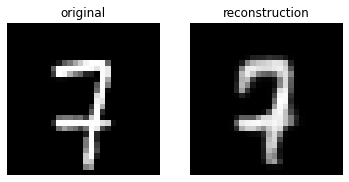

Generate a random image from the model:


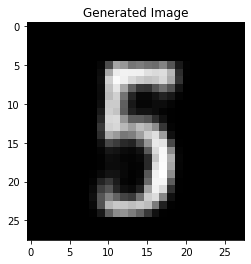

Intended digit:  5
Intended as handwritten:  False
Epoch: 1621 average training loss: 92.82707873687744
Epoch: 1622 average training loss: 92.81013893585205
Epoch: 1623 average training loss: 92.84199514923095
Epoch: 1624 average training loss: 92.77652574005127
Epoch: 1625 average training loss: 92.82600624542236
Epoch: 1626 average training loss: 92.8598605545044
Epoch: 1627 average training loss: 92.82948478546143
Epoch: 1628 average training loss: 92.81561614532471
Epoch: 1629 average training loss: 92.828640284729
Epoch: 1630 average training loss: 92.82373054962159
Epoch: 1630 average test loss: 98.34127336425782
Comparing a random test image to its reconstruction:


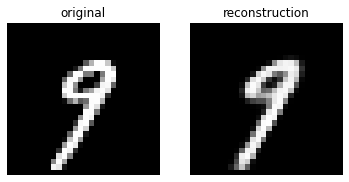

Generate a random image from the model:


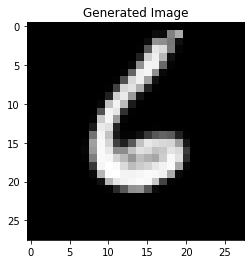

Intended digit:  6
Intended as handwritten:  False
Epoch: 1631 average training loss: 92.81731455841064
Epoch: 1632 average training loss: 92.82004580230713
Epoch: 1633 average training loss: 92.83713107452392
Epoch: 1634 average training loss: 92.82014109649658
Epoch: 1635 average training loss: 92.78673643341064
Epoch: 1636 average training loss: 92.82990476837158
Epoch: 1637 average training loss: 92.8032529006958
Epoch: 1638 average training loss: 92.81416414337158
Epoch: 1639 average training loss: 92.80884630889892
Epoch: 1640 average training loss: 92.79948617706299
Epoch: 1640 average test loss: 98.26694304199219
Comparing a random test image to its reconstruction:


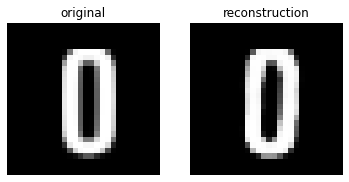

Generate a random image from the model:


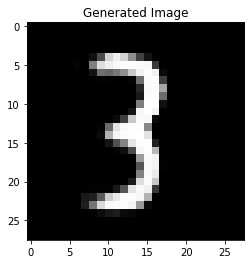

Intended digit:  3
Intended as handwritten:  False
Epoch: 1641 average training loss: 92.82648437042236
Epoch: 1642 average training loss: 92.84347478790284
Epoch: 1643 average training loss: 92.81712241973877
Epoch: 1644 average training loss: 92.79919026031494
Epoch: 1645 average training loss: 92.809644770813
Epoch: 1646 average training loss: 92.80710618438721
Epoch: 1647 average training loss: 92.78459829864502
Epoch: 1648 average training loss: 92.7980511062622
Epoch: 1649 average training loss: 92.79720601348878
Epoch: 1650 average training loss: 92.80308246612549
Epoch: 1650 average test loss: 98.18228745117187
Comparing a random test image to its reconstruction:


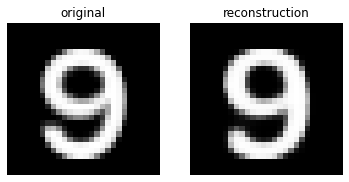

Generate a random image from the model:


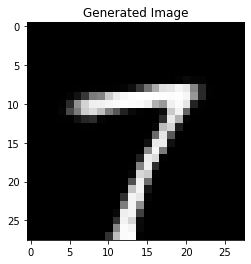

Intended digit:  7
Intended as handwritten:  False
Epoch: 1651 average training loss: 92.80983952178956
Epoch: 1652 average training loss: 92.82297963409424
Epoch: 1653 average training loss: 92.79667456207275
Epoch: 1654 average training loss: 92.82654185333251
Epoch: 1655 average training loss: 92.79493969268799
Epoch: 1656 average training loss: 92.8048338394165
Epoch: 1657 average training loss: 92.8187080154419
Epoch: 1658 average training loss: 92.80954135284424
Epoch: 1659 average training loss: 92.8054980178833
Epoch: 1660 average training loss: 92.78973592681885
Epoch: 1660 average test loss: 98.3297421447754
Comparing a random test image to its reconstruction:


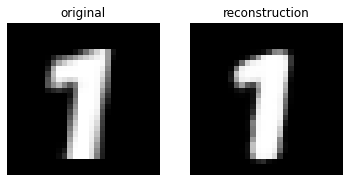

Generate a random image from the model:


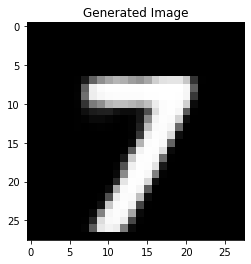

Intended digit:  7
Intended as handwritten:  False
Epoch: 1661 average training loss: 92.78300261993408
Epoch: 1662 average training loss: 92.80363561553955
Epoch: 1663 average training loss: 92.80483559112548
Epoch: 1664 average training loss: 92.80540049591065
Epoch: 1665 average training loss: 92.78694618682862
Epoch: 1666 average training loss: 92.80120240631103
Epoch: 1667 average training loss: 92.8118591934204
Epoch: 1668 average training loss: 92.79457654571533
Epoch: 1669 average training loss: 92.77948933868409
Epoch: 1670 average training loss: 92.80613328399659
Epoch: 1670 average test loss: 98.19750390014649
Comparing a random test image to its reconstruction:


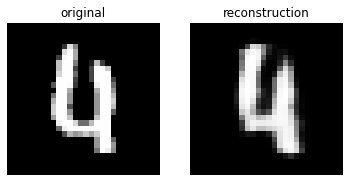

Generate a random image from the model:


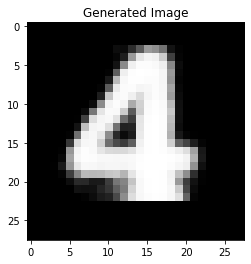

Intended digit:  4
Intended as handwritten:  False
Epoch: 1671 average training loss: 92.79417791290284
Epoch: 1672 average training loss: 92.78641291046142
Epoch: 1673 average training loss: 92.8079333694458
Epoch: 1674 average training loss: 92.80036748199463
Epoch: 1675 average training loss: 92.79311675567627
Epoch: 1676 average training loss: 92.78497663726807
Epoch: 1677 average training loss: 92.81269456939697
Epoch: 1678 average training loss: 92.78763266143798
Epoch: 1679 average training loss: 92.76414599761964
Epoch: 1680 average training loss: 92.79979694366455
Epoch: 1680 average test loss: 98.37143057250977
Comparing a random test image to its reconstruction:


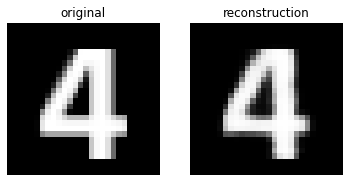

Generate a random image from the model:


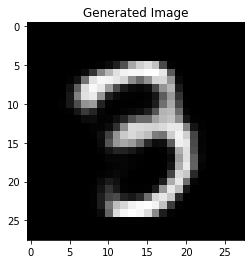

Intended digit:  3
Intended as handwritten:  False
Epoch: 1681 average training loss: 92.79562194366456
Epoch: 1682 average training loss: 92.80965969390869
Epoch: 1683 average training loss: 92.78117726593018
Epoch: 1684 average training loss: 92.76485652618408
Epoch: 1685 average training loss: 92.78772122344971
Epoch: 1686 average training loss: 92.79945147247315
Epoch: 1687 average training loss: 92.80989678497315
Epoch: 1688 average training loss: 92.77651637115478
Epoch: 1689 average training loss: 92.75928502960205
Epoch: 1690 average training loss: 92.78014378814697
Epoch: 1690 average test loss: 98.34954870605469
Comparing a random test image to its reconstruction:


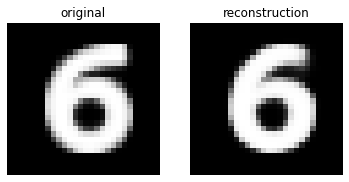

Generate a random image from the model:


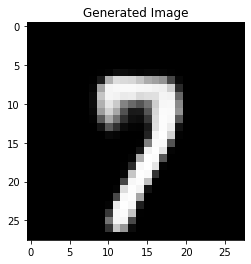

Intended digit:  7
Intended as handwritten:  False
Epoch: 1691 average training loss: 92.78339712677003
Epoch: 1692 average training loss: 92.77144296417237
Epoch: 1693 average training loss: 92.78541800079346
Epoch: 1694 average training loss: 92.76172973175049
Epoch: 1695 average training loss: 92.79626054229736
Epoch: 1696 average training loss: 92.78562629547119
Epoch: 1697 average training loss: 92.77500326080322
Epoch: 1698 average training loss: 92.76182840118408
Epoch: 1699 average training loss: 92.77372681427002
Epoch: 1700 average training loss: 92.77771818389893
Epoch: 1700 average test loss: 98.36712530517578
Comparing a random test image to its reconstruction:


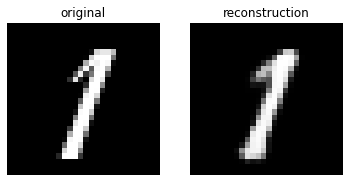

Generate a random image from the model:


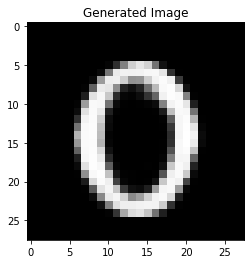

Intended digit:  0
Intended as handwritten:  False
Epoch: 1701 average training loss: 92.77074870147705
Epoch: 1702 average training loss: 92.77189319610596
Epoch: 1703 average training loss: 92.80101826934815
Epoch: 1704 average training loss: 92.79686682891845
Epoch: 1705 average training loss: 92.77825041656494
Epoch: 1706 average training loss: 92.7484945022583
Epoch: 1707 average training loss: 92.75921324005127
Epoch: 1708 average training loss: 92.766811378479
Epoch: 1709 average training loss: 92.75007180938721
Epoch: 1710 average training loss: 92.76138478546143
Epoch: 1710 average test loss: 98.40321856689454
Comparing a random test image to its reconstruction:


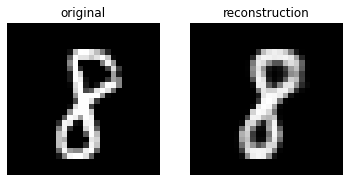

Generate a random image from the model:


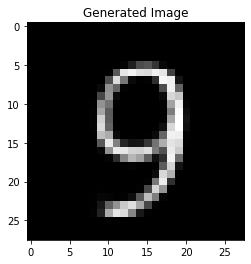

Intended digit:  9
Intended as handwritten:  False
Epoch: 1711 average training loss: 92.75859663848877
Epoch: 1712 average training loss: 92.7781665725708
Epoch: 1713 average training loss: 92.75893084259033
Epoch: 1714 average training loss: 92.76458460235595
Epoch: 1715 average training loss: 92.76014055938721
Epoch: 1716 average training loss: 92.77104015045165
Epoch: 1717 average training loss: 92.75114135284424
Epoch: 1718 average training loss: 92.76741476593017
Epoch: 1719 average training loss: 92.73347846221924
Epoch: 1720 average training loss: 92.77257591094971
Epoch: 1720 average test loss: 98.29921745605469
Comparing a random test image to its reconstruction:


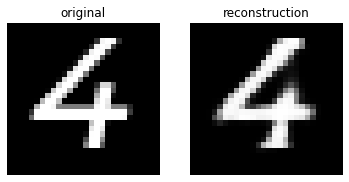

Generate a random image from the model:


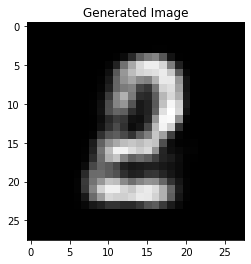

Intended digit:  2
Intended as handwritten:  False
Epoch: 1721 average training loss: 92.75113271026612
Epoch: 1722 average training loss: 92.73800810699463
Epoch: 1723 average training loss: 92.77663621978759
Epoch: 1724 average training loss: 92.77464503326416
Epoch: 1725 average training loss: 92.76040312042237
Epoch: 1726 average training loss: 92.74326189727783
Epoch: 1727 average training loss: 92.75784518585205
Epoch: 1728 average training loss: 92.76373609771728
Epoch: 1729 average training loss: 92.73799739532471
Epoch: 1730 average training loss: 92.76077749786377
Epoch: 1730 average test loss: 98.41607111816407
Comparing a random test image to its reconstruction:


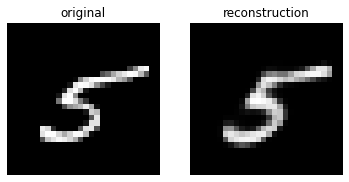

Generate a random image from the model:


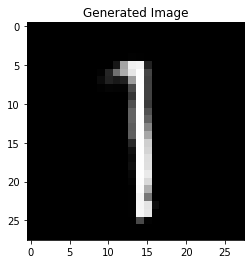

Intended digit:  1
Intended as handwritten:  False
Epoch: 1731 average training loss: 92.76772542877197
Epoch: 1732 average training loss: 92.72204119415284
Epoch: 1733 average training loss: 92.7353913772583
Epoch: 1734 average training loss: 92.74806779937744
Epoch: 1735 average training loss: 92.74067284698486
Epoch: 1736 average training loss: 92.76898330841064
Epoch: 1737 average training loss: 92.71900518341064
Epoch: 1738 average training loss: 92.76303663482666
Epoch: 1739 average training loss: 92.7494296951294
Epoch: 1740 average training loss: 92.76072489776611
Epoch: 1740 average test loss: 98.39524279785157
Comparing a random test image to its reconstruction:


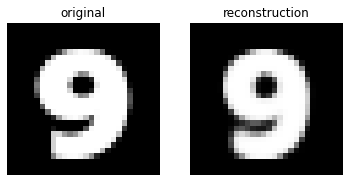

Generate a random image from the model:


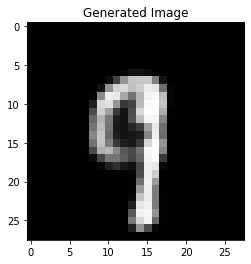

Intended digit:  9
Intended as handwritten:  False
Epoch: 1741 average training loss: 92.73488092193604
Epoch: 1742 average training loss: 92.7349339981079
Epoch: 1743 average training loss: 92.73458502960204
Epoch: 1744 average training loss: 92.73882652130126
Epoch: 1745 average training loss: 92.76220608673096
Epoch: 1746 average training loss: 92.72568114776611
Epoch: 1747 average training loss: 92.75390316925049
Epoch: 1748 average training loss: 92.73923964385986
Epoch: 1749 average training loss: 92.73633226470947
Epoch: 1750 average training loss: 92.7310037185669
Epoch: 1750 average test loss: 98.3713465637207
Comparing a random test image to its reconstruction:


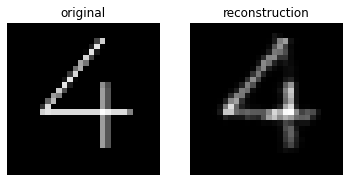

Generate a random image from the model:


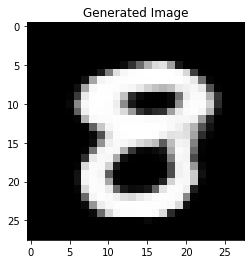

Intended digit:  8
Intended as handwritten:  False
Epoch: 1751 average training loss: 92.76206713409424
Epoch: 1752 average training loss: 92.73942968902588
Epoch: 1753 average training loss: 92.75147304840088
Epoch: 1754 average training loss: 92.76147550201416
Epoch: 1755 average training loss: 92.72859190216064
Epoch: 1756 average training loss: 92.74158359527588
Epoch: 1757 average training loss: 92.72554955596924
Epoch: 1758 average training loss: 92.72859116973876
Epoch: 1759 average training loss: 92.7391364944458
Epoch: 1760 average training loss: 92.73643562774659
Epoch: 1760 average test loss: 98.49058498535156
Comparing a random test image to its reconstruction:


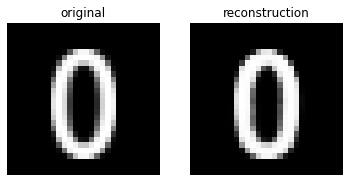

Generate a random image from the model:


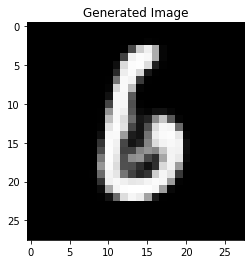

Intended digit:  6
Intended as handwritten:  False
Epoch: 1761 average training loss: 92.74089419708253
Epoch: 1762 average training loss: 92.73184983062744
Epoch: 1763 average training loss: 92.7141540359497
Epoch: 1764 average training loss: 92.71656580352783
Epoch: 1765 average training loss: 92.7356003616333
Epoch: 1766 average training loss: 92.73740074005127
Epoch: 1767 average training loss: 92.72203134307861
Epoch: 1768 average training loss: 92.7093293045044
Epoch: 1769 average training loss: 92.73035336456299
Epoch: 1770 average training loss: 92.70788476104737
Epoch: 1770 average test loss: 98.55428599853515
Comparing a random test image to its reconstruction:


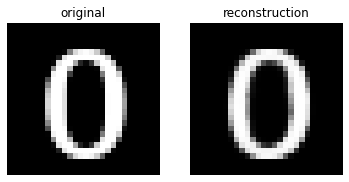

Generate a random image from the model:


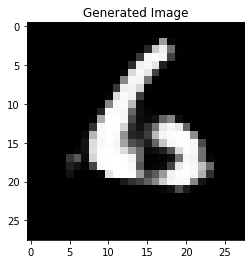

Intended digit:  6
Intended as handwritten:  False
Epoch: 1771 average training loss: 92.72829608306884
Epoch: 1772 average training loss: 92.70851367950439
Epoch: 1773 average training loss: 92.75816864166259
Epoch: 1774 average training loss: 92.70590937042236
Epoch: 1775 average training loss: 92.72743757476806
Epoch: 1776 average training loss: 92.73371955108642
Epoch: 1777 average training loss: 92.747069972229
Epoch: 1778 average training loss: 92.71950543365479
Epoch: 1779 average training loss: 92.71404407501221
Epoch: 1780 average training loss: 92.71234710235596
Epoch: 1780 average test loss: 98.53141685791016
Comparing a random test image to its reconstruction:


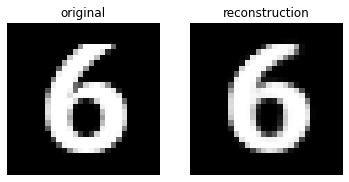

Generate a random image from the model:


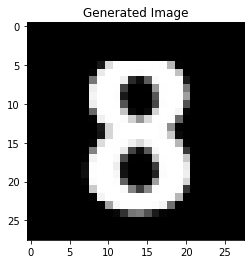

Intended digit:  8
Intended as handwritten:  False
Epoch: 1781 average training loss: 92.73055252227783
Epoch: 1782 average training loss: 92.74485650787354
Epoch: 1783 average training loss: 92.7200634475708
Epoch: 1784 average training loss: 92.72729738311767
Epoch: 1785 average training loss: 92.71479201202392
Epoch: 1786 average training loss: 92.69762662506103
Epoch: 1787 average training loss: 92.70056187286377
Epoch: 1788 average training loss: 92.72072980499267
Epoch: 1789 average training loss: 92.69793385162353
Epoch: 1790 average training loss: 92.70409518585205
Epoch: 1790 average test loss: 98.47718889160156
Comparing a random test image to its reconstruction:


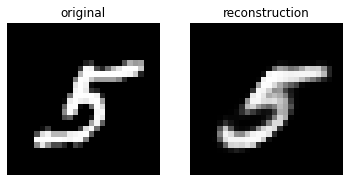

Generate a random image from the model:


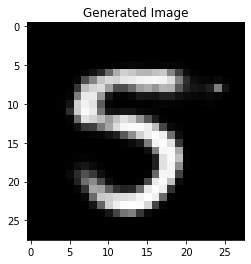

Intended digit:  5
Intended as handwritten:  False
Epoch: 1791 average training loss: 92.72826775665283
Epoch: 1792 average training loss: 92.68545134429931
Epoch: 1793 average training loss: 92.73553736114502
Epoch: 1794 average training loss: 92.7294683731079
Epoch: 1795 average training loss: 92.71847627716065
Epoch: 1796 average training loss: 92.71435088653564
Epoch: 1797 average training loss: 92.70302511138917
Epoch: 1798 average training loss: 92.68227174835205
Epoch: 1799 average training loss: 92.69467966461181
Epoch: 1800 average training loss: 92.71302462921143
Epoch: 1800 average test loss: 98.34430191650391
Comparing a random test image to its reconstruction:


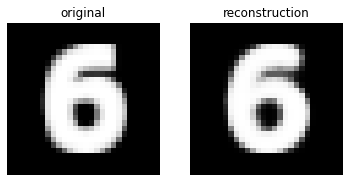

Generate a random image from the model:


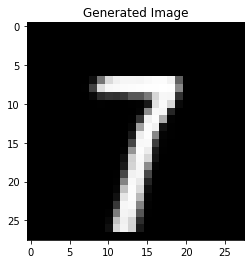

Intended digit:  7
Intended as handwritten:  False
Epoch: 1801 average training loss: 92.71422536773682
Epoch: 1802 average training loss: 92.71818416290283
Epoch: 1803 average training loss: 92.67566288604736
Epoch: 1804 average training loss: 92.71281892852784
Epoch: 1805 average training loss: 92.69688671417236
Epoch: 1806 average training loss: 92.71461441192626
Epoch: 1807 average training loss: 92.71584944000244
Epoch: 1808 average training loss: 92.70815847930908
Epoch: 1809 average training loss: 92.70428487091064
Epoch: 1810 average training loss: 92.71097746124268
Epoch: 1810 average test loss: 98.32193270263672
Comparing a random test image to its reconstruction:


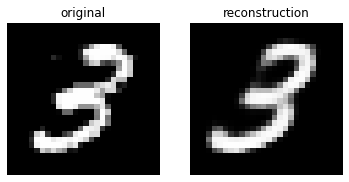

Generate a random image from the model:


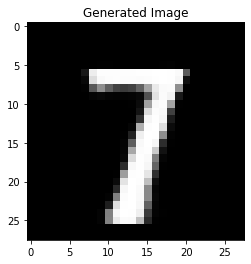

Intended digit:  7
Intended as handwritten:  False
Epoch: 1811 average training loss: 92.69733841094971
Epoch: 1812 average training loss: 92.71031480255127
Epoch: 1813 average training loss: 92.7062150466919
Epoch: 1814 average training loss: 92.71882822418213
Epoch: 1815 average training loss: 92.67680736236572
Epoch: 1816 average training loss: 92.69017929229736
Epoch: 1817 average training loss: 92.6851484451294
Epoch: 1818 average training loss: 92.702910987854
Epoch: 1819 average training loss: 92.69547824249267
Epoch: 1820 average training loss: 92.69432279205323
Epoch: 1820 average test loss: 98.31343596191407
Comparing a random test image to its reconstruction:


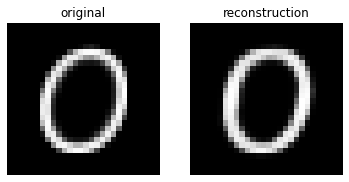

Generate a random image from the model:


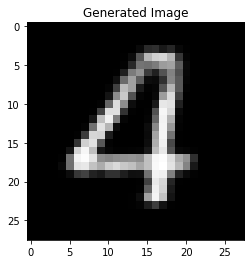

Intended digit:  4
Intended as handwritten:  False
Epoch: 1821 average training loss: 92.6846134841919
Epoch: 1822 average training loss: 92.70209157867431
Epoch: 1823 average training loss: 92.67161026153565
Epoch: 1824 average training loss: 92.69197696075439
Epoch: 1825 average training loss: 92.69347109527588
Epoch: 1826 average training loss: 92.69990293731689
Epoch: 1827 average training loss: 92.67841392364502
Epoch: 1828 average training loss: 92.67308651885986
Epoch: 1829 average training loss: 92.71686750640869
Epoch: 1830 average training loss: 92.70032382354736
Epoch: 1830 average test loss: 98.49886608276367
Comparing a random test image to its reconstruction:


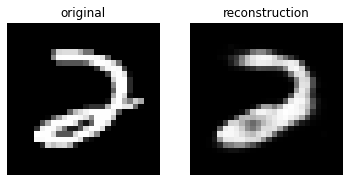

Generate a random image from the model:


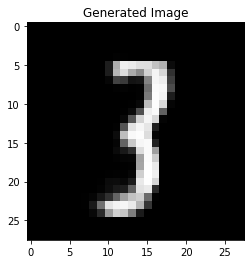

Intended digit:  3
Intended as handwritten:  False
Epoch: 1831 average training loss: 92.70380883331299
Epoch: 1832 average training loss: 92.70995286407471
Epoch: 1833 average training loss: 92.65429800567627
Epoch: 1834 average training loss: 92.6860755935669
Epoch: 1835 average training loss: 92.67907729644776
Epoch: 1836 average training loss: 92.6846878982544
Epoch: 1837 average training loss: 92.70137006378174
Epoch: 1838 average training loss: 92.69127939605713
Epoch: 1839 average training loss: 92.67082799835205
Epoch: 1840 average training loss: 92.68940948638917
Epoch: 1840 average test loss: 98.47491989746094
Comparing a random test image to its reconstruction:


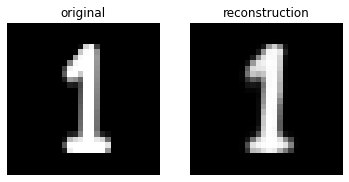

Generate a random image from the model:


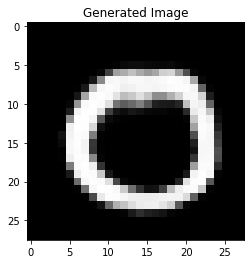

Intended digit:  0
Intended as handwritten:  False
Epoch: 1841 average training loss: 92.69822407989501
Epoch: 1842 average training loss: 92.68573661651611
Epoch: 1843 average training loss: 92.69292375030517
Epoch: 1844 average training loss: 92.68273123931884
Epoch: 1845 average training loss: 92.67720698394776
Epoch: 1846 average training loss: 92.70929164581298
Epoch: 1847 average training loss: 92.68143456573486
Epoch: 1848 average training loss: 92.66569262847901
Epoch: 1849 average training loss: 92.66187455596923
Epoch: 1850 average training loss: 92.6909893814087
Epoch: 1850 average test loss: 98.6187052734375
Comparing a random test image to its reconstruction:


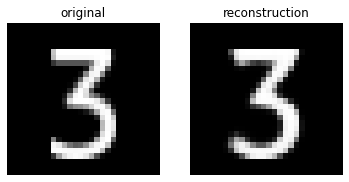

Generate a random image from the model:


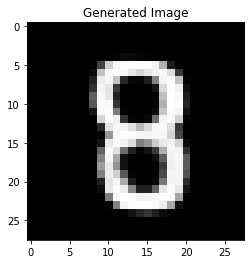

Intended digit:  8
Intended as handwritten:  False
Epoch: 1851 average training loss: 92.68680022735596
Epoch: 1852 average training loss: 92.65750857696533
Epoch: 1853 average training loss: 92.69297657623291
Epoch: 1854 average training loss: 92.69650933380127
Epoch: 1855 average training loss: 92.65920611114502
Epoch: 1856 average training loss: 92.66044712677002
Epoch: 1857 average training loss: 92.67890570220948
Epoch: 1858 average training loss: 92.66619995880127
Epoch: 1859 average training loss: 92.6602586013794
Epoch: 1860 average training loss: 92.68309843292236
Epoch: 1860 average test loss: 98.71839810791016
Comparing a random test image to its reconstruction:


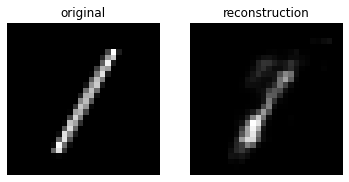

Generate a random image from the model:


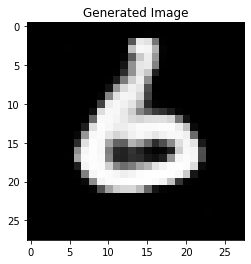

Intended digit:  6
Intended as handwritten:  False
Epoch: 1861 average training loss: 92.6808581741333
Epoch: 1862 average training loss: 92.67450703277588
Epoch: 1863 average training loss: 92.64230780792236
Epoch: 1864 average training loss: 92.66853189849853
Epoch: 1865 average training loss: 92.65804952545166
Epoch: 1866 average training loss: 92.67771631622314
Epoch: 1867 average training loss: 92.66706777496339
Epoch: 1868 average training loss: 92.66106678619384
Epoch: 1869 average training loss: 92.64433030548096
Epoch: 1870 average training loss: 92.69858240509033
Epoch: 1870 average test loss: 98.4789264038086
Comparing a random test image to its reconstruction:


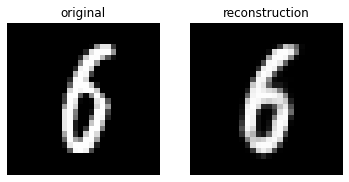

Generate a random image from the model:


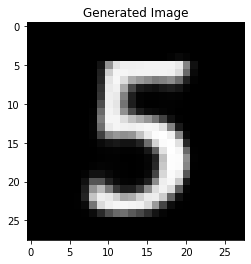

Intended digit:  5
Intended as handwritten:  False
Epoch: 1871 average training loss: 92.65948221588135
Epoch: 1872 average training loss: 92.68891870880127
Epoch: 1873 average training loss: 92.64946643218994
Epoch: 1874 average training loss: 92.65797693634033
Epoch: 1875 average training loss: 92.66185028839111
Epoch: 1876 average training loss: 92.66006869659424
Epoch: 1877 average training loss: 92.64728012237549
Epoch: 1878 average training loss: 92.70000670318603
Epoch: 1879 average training loss: 92.67850291290283
Epoch: 1880 average training loss: 92.6542400100708
Epoch: 1880 average test loss: 98.62428412475586
Comparing a random test image to its reconstruction:


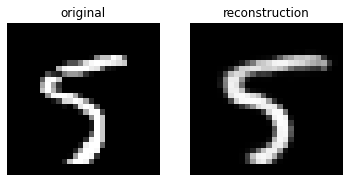

Generate a random image from the model:


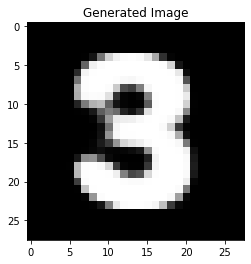

Intended digit:  3
Intended as handwritten:  False
Epoch: 1881 average training loss: 92.66219231719971
Epoch: 1882 average training loss: 92.6435249282837
Epoch: 1883 average training loss: 92.6758229019165
Epoch: 1884 average training loss: 92.66140027008056
Epoch: 1885 average training loss: 92.6726916091919
Epoch: 1886 average training loss: 92.68592389068604
Epoch: 1887 average training loss: 92.65866808624267
Epoch: 1888 average training loss: 92.65262783966064
Epoch: 1889 average training loss: 92.63474086456299
Epoch: 1890 average training loss: 92.66272990875244
Epoch: 1890 average test loss: 98.683197265625
Comparing a random test image to its reconstruction:


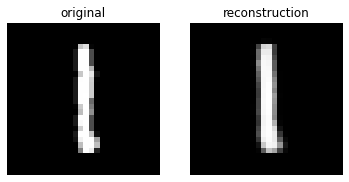

Generate a random image from the model:


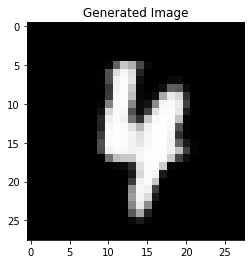

Intended digit:  4
Intended as handwritten:  False
Epoch: 1891 average training loss: 92.65423753204345
Epoch: 1892 average training loss: 92.6544103225708
Epoch: 1893 average training loss: 92.6637797317505
Epoch: 1894 average training loss: 92.64578540802002
Epoch: 1895 average training loss: 92.66845619659424
Epoch: 1896 average training loss: 92.63338941192627
Epoch: 1897 average training loss: 92.65063389434815
Epoch: 1898 average training loss: 92.65161772003174
Epoch: 1899 average training loss: 92.67135921173096
Epoch: 1900 average training loss: 92.64422191925048
Epoch: 1900 average test loss: 98.60607609252929
Comparing a random test image to its reconstruction:


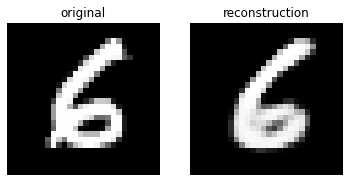

Generate a random image from the model:


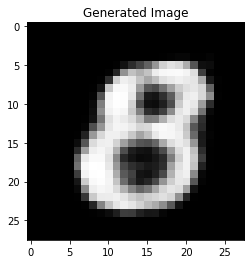

Intended digit:  8
Intended as handwritten:  False
Epoch: 1901 average training loss: 92.63718540802002
Epoch: 1902 average training loss: 92.65347531280517
Epoch: 1903 average training loss: 92.64621483917236
Epoch: 1904 average training loss: 92.60519370880127
Epoch: 1905 average training loss: 92.6632901687622
Epoch: 1906 average training loss: 92.63171089630127
Epoch: 1907 average training loss: 92.63944640655518
Epoch: 1908 average training loss: 92.6684977005005
Epoch: 1909 average training loss: 92.6537296951294
Epoch: 1910 average training loss: 92.63026034698487
Epoch: 1910 average test loss: 98.4433732421875
Comparing a random test image to its reconstruction:


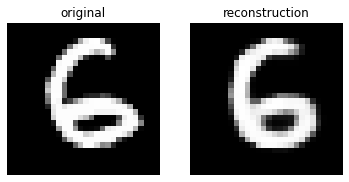

Generate a random image from the model:


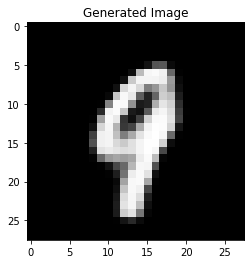

Intended digit:  9
Intended as handwritten:  False
Epoch: 1911 average training loss: 92.62665123443604
Epoch: 1912 average training loss: 92.64415404205322
Epoch: 1913 average training loss: 92.63185310211182
Epoch: 1914 average training loss: 92.62225171661377
Epoch: 1915 average training loss: 92.60758272247314
Epoch: 1916 average training loss: 92.66456685333252
Epoch: 1917 average training loss: 92.62667726593017
Epoch: 1918 average training loss: 92.65480584259033
Epoch: 1919 average training loss: 92.62934027862549
Epoch: 1920 average training loss: 92.6390724685669
Epoch: 1920 average test loss: 98.44476368408203
Comparing a random test image to its reconstruction:


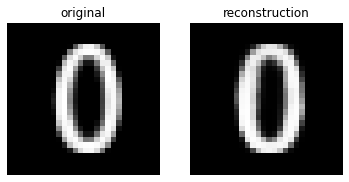

Generate a random image from the model:


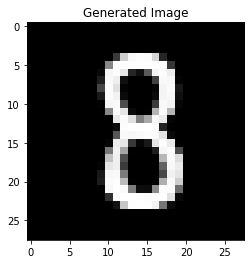

Intended digit:  8
Intended as handwritten:  False
Epoch: 1921 average training loss: 92.66117826690675
Epoch: 1922 average training loss: 92.66277367706299
Epoch: 1923 average training loss: 92.62282898712158
Epoch: 1924 average training loss: 92.61542686309815
Epoch: 1925 average training loss: 92.63201834259033
Epoch: 1926 average training loss: 92.61982264556885
Epoch: 1927 average training loss: 92.64054608917236
Epoch: 1928 average training loss: 92.61432513580323
Epoch: 1929 average training loss: 92.64252003326416
Epoch: 1930 average training loss: 92.62159326934814
Epoch: 1930 average test loss: 98.54670549316407
Comparing a random test image to its reconstruction:


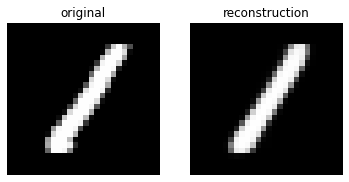

Generate a random image from the model:


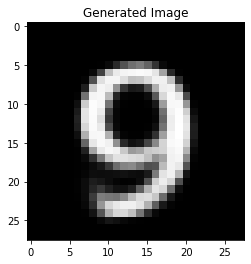

Intended digit:  9
Intended as handwritten:  False
Epoch: 1931 average training loss: 92.65566638946534
Epoch: 1932 average training loss: 92.62668827667237
Epoch: 1933 average training loss: 92.6095640335083
Epoch: 1934 average training loss: 92.62519975128174
Epoch: 1935 average training loss: 92.62826690216065
Epoch: 1936 average training loss: 92.63339646759033
Epoch: 1937 average training loss: 92.63463482208252
Epoch: 1938 average training loss: 92.63216435089112
Epoch: 1939 average training loss: 92.61127506866455
Epoch: 1940 average training loss: 92.61556452178955
Epoch: 1940 average test loss: 98.59416170654296
Comparing a random test image to its reconstruction:


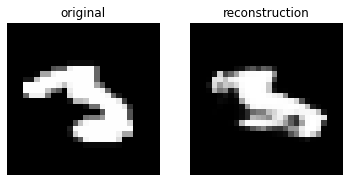

Generate a random image from the model:


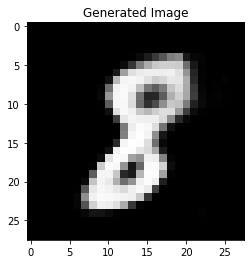

Intended digit:  8
Intended as handwritten:  False
Epoch: 1941 average training loss: 92.62498449249267
Epoch: 1942 average training loss: 92.60417906036378
Epoch: 1943 average training loss: 92.61112824249268
Epoch: 1944 average training loss: 92.64148535919189
Epoch: 1945 average training loss: 92.62058365020752
Epoch: 1946 average training loss: 92.6440372390747
Epoch: 1947 average training loss: 92.6425391921997
Epoch: 1948 average training loss: 92.6086654006958
Epoch: 1949 average training loss: 92.63269607086181
Epoch: 1950 average training loss: 92.62698958892823
Epoch: 1950 average test loss: 98.585445703125
Comparing a random test image to its reconstruction:


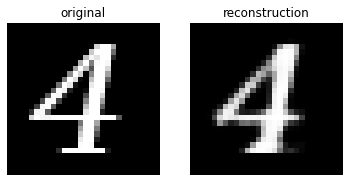

Generate a random image from the model:


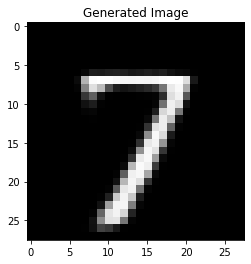

Intended digit:  7
Intended as handwritten:  False
Epoch: 1951 average training loss: 92.63181350250244
Epoch: 1952 average training loss: 92.6090054397583
Epoch: 1953 average training loss: 92.63482873077393
Epoch: 1954 average training loss: 92.62747207183838
Epoch: 1955 average training loss: 92.6287116470337
Epoch: 1956 average training loss: 92.63630169830323
Epoch: 1957 average training loss: 92.61974948272704
Epoch: 1958 average training loss: 92.60204088287354
Epoch: 1959 average training loss: 92.60560816192627
Epoch: 1960 average training loss: 92.61451027374268
Epoch: 1960 average test loss: 98.54409321289063
Comparing a random test image to its reconstruction:


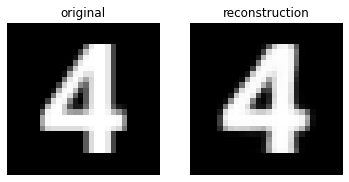

Generate a random image from the model:


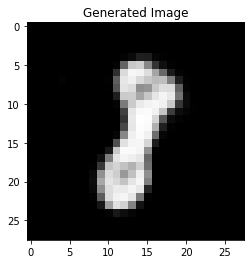

Intended digit:  8
Intended as handwritten:  False
Epoch: 1961 average training loss: 92.61951515655518
Epoch: 1962 average training loss: 92.61441385040283
Epoch: 1963 average training loss: 92.61038876495361
Epoch: 1964 average training loss: 92.59518538970947
Epoch: 1965 average training loss: 92.6124626296997
Epoch: 1966 average training loss: 92.5922414932251
Epoch: 1967 average training loss: 92.60800810089111
Epoch: 1968 average training loss: 92.59127613067626
Epoch: 1969 average training loss: 92.61652763824463
Epoch: 1970 average training loss: 92.57589476470947
Epoch: 1970 average test loss: 98.71876083984375
Comparing a random test image to its reconstruction:


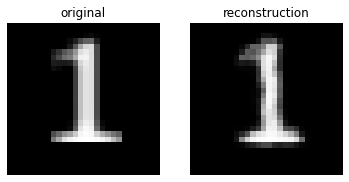

Generate a random image from the model:


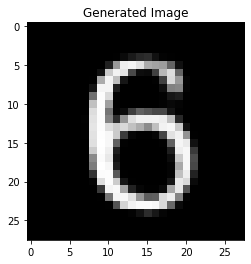

Intended digit:  6
Intended as handwritten:  False
Epoch: 1971 average training loss: 92.58168474884033
Epoch: 1972 average training loss: 92.6171409439087
Epoch: 1973 average training loss: 92.61603048858643
Epoch: 1974 average training loss: 92.59529831085204
Epoch: 1975 average training loss: 92.60125619659424
Epoch: 1976 average training loss: 92.59576663360596
Epoch: 1977 average training loss: 92.60151557769775
Epoch: 1978 average training loss: 92.58102509918213
Epoch: 1979 average training loss: 92.58011778106689
Epoch: 1980 average training loss: 92.59345091094971
Epoch: 1980 average test loss: 98.63749846801758
Comparing a random test image to its reconstruction:


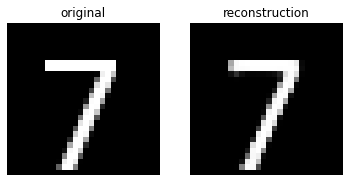

Generate a random image from the model:


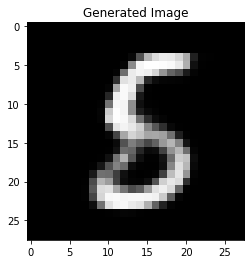

Intended digit:  5
Intended as handwritten:  False
Epoch: 1981 average training loss: 92.59677268829346
Epoch: 1982 average training loss: 92.59551836090088
Epoch: 1983 average training loss: 92.61352039947509
Epoch: 1984 average training loss: 92.59394129180909
Epoch: 1985 average training loss: 92.61099946441651
Epoch: 1986 average training loss: 92.60688473052979
Epoch: 1987 average training loss: 92.6019060256958
Epoch: 1988 average training loss: 92.58329920196533
Epoch: 1989 average training loss: 92.62144219512939
Epoch: 1990 average training loss: 92.58874095001221
Epoch: 1990 average test loss: 98.70934274291992
Comparing a random test image to its reconstruction:


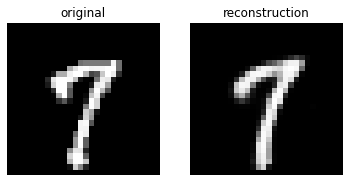

Generate a random image from the model:


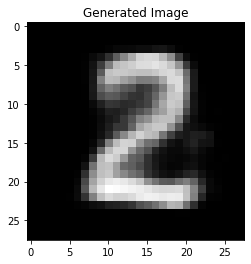

Intended digit:  2
Intended as handwritten:  False
Epoch: 1991 average training loss: 92.59942761993408
Epoch: 1992 average training loss: 92.59301762237548
Epoch: 1993 average training loss: 92.60584876251221
Epoch: 1994 average training loss: 92.59374722442627
Epoch: 1995 average training loss: 92.58900803375244
Epoch: 1996 average training loss: 92.6164436843872
Epoch: 1997 average training loss: 92.60517632598877
Epoch: 1998 average training loss: 92.58108774566651
Epoch: 1999 average training loss: 92.6069423904419
Epoch: 2000 average training loss: 92.5984441543579
Epoch: 2000 average test loss: 98.5423022277832
Comparing a random test image to its reconstruction:


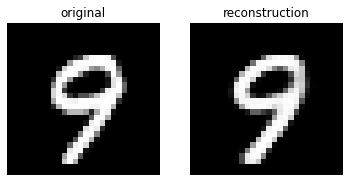

Generate a random image from the model:


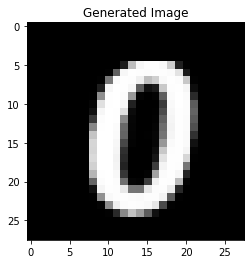

Intended digit:  0
Intended as handwritten:  False
Epoch: 2001 average training loss: 92.60486508331299
Epoch: 2002 average training loss: 92.61104159088134
Epoch: 2003 average training loss: 92.58378819122315
Epoch: 2004 average training loss: 92.5649665725708
Epoch: 2005 average training loss: 92.58870384063721
Epoch: 2006 average training loss: 92.58143405303954
Epoch: 2007 average training loss: 92.59494781646728
Epoch: 2008 average training loss: 92.59783263092041
Epoch: 2009 average training loss: 92.57925876617432
Epoch: 2010 average training loss: 92.57836912384033
Epoch: 2010 average test loss: 98.68045675048828
Comparing a random test image to its reconstruction:


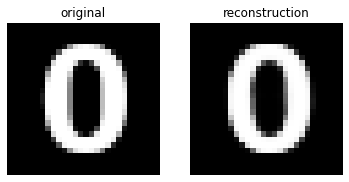

Generate a random image from the model:


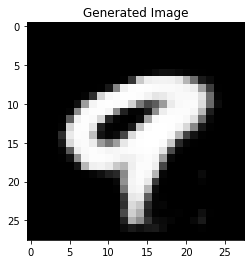

Intended digit:  9
Intended as handwritten:  False
Epoch: 2011 average training loss: 92.59123041534424
Epoch: 2012 average training loss: 92.59076045684814
Epoch: 2013 average training loss: 92.56369923858642
Epoch: 2014 average training loss: 92.58995495147705
Epoch: 2015 average training loss: 92.58331365509034
Epoch: 2016 average training loss: 92.5987785232544
Epoch: 2017 average training loss: 92.5681579421997
Epoch: 2018 average training loss: 92.558853956604
Epoch: 2019 average training loss: 92.59775987701416
Epoch: 2020 average training loss: 92.56824900054932
Epoch: 2020 average test loss: 98.7639294921875
Comparing a random test image to its reconstruction:


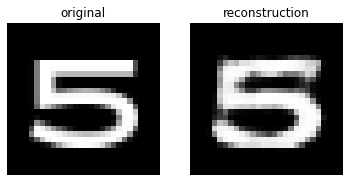

Generate a random image from the model:


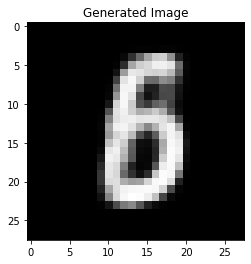

Intended digit:  6
Intended as handwritten:  False
Epoch: 2021 average training loss: 92.59115022735595
Epoch: 2022 average training loss: 92.59802503204345
Epoch: 2023 average training loss: 92.59226297149658
Epoch: 2024 average training loss: 92.57484188995362
Epoch: 2025 average training loss: 92.56596902008057
Epoch: 2026 average training loss: 92.58206186065674
Epoch: 2027 average training loss: 92.58522380523682
Epoch: 2028 average training loss: 92.5793096939087
Epoch: 2029 average training loss: 92.54982836456298
Epoch: 2030 average training loss: 92.57728787384033
Epoch: 2030 average test loss: 98.76269887695312
Comparing a random test image to its reconstruction:


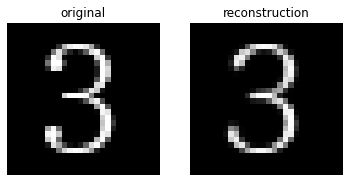

Generate a random image from the model:


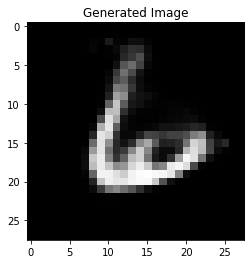

Intended digit:  6
Intended as handwritten:  False
Epoch: 2031 average training loss: 92.58559423370362
Epoch: 2032 average training loss: 92.57346728057861
Epoch: 2033 average training loss: 92.56005636138916
Epoch: 2034 average training loss: 92.574100239563
Epoch: 2035 average training loss: 92.57375296173096
Epoch: 2036 average training loss: 92.58166319122314
Epoch: 2037 average training loss: 92.57129241485596
Epoch: 2038 average training loss: 92.56829767608643
Epoch: 2039 average training loss: 92.57901516876221
Epoch: 2040 average training loss: 92.56521221466065
Epoch: 2040 average test loss: 98.71113491821289
Comparing a random test image to its reconstruction:


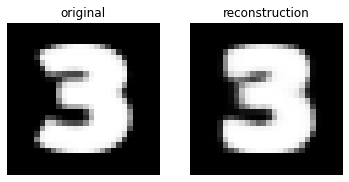

Generate a random image from the model:


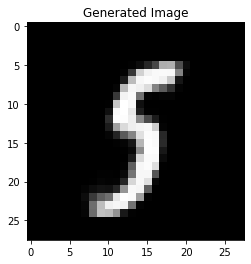

Intended digit:  5
Intended as handwritten:  False
Epoch: 2041 average training loss: 92.5470477859497
Epoch: 2042 average training loss: 92.58169903717041
Epoch: 2043 average training loss: 92.56792537384034
Epoch: 2044 average training loss: 92.57134772491455
Epoch: 2045 average training loss: 92.57381670074463
Epoch: 2046 average training loss: 92.57942532501221
Epoch: 2047 average training loss: 92.57264786529541
Epoch: 2048 average training loss: 92.54736905670165
Epoch: 2049 average training loss: 92.57579014434815
Epoch: 2050 average training loss: 92.55923919830322
Epoch: 2050 average test loss: 98.7766940673828
Comparing a random test image to its reconstruction:


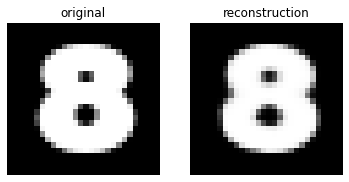

Generate a random image from the model:


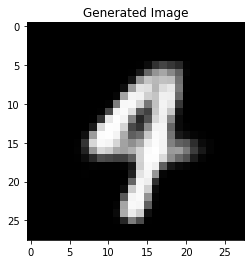

Intended digit:  4
Intended as handwritten:  False
Epoch: 2051 average training loss: 92.57170716094971
Epoch: 2052 average training loss: 92.56025275421142
Epoch: 2053 average training loss: 92.53519925079345
Epoch: 2054 average training loss: 92.55546065216065
Epoch: 2055 average training loss: 92.58629853057862
Epoch: 2056 average training loss: 92.55842663726807
Epoch: 2057 average training loss: 92.55974593048096
Epoch: 2058 average training loss: 92.57489501495361
Epoch: 2059 average training loss: 92.59633994903564
Epoch: 2060 average training loss: 92.53997029571534
Epoch: 2060 average test loss: 98.71578267822265
Comparing a random test image to its reconstruction:


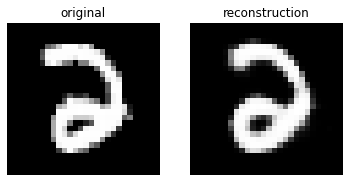

Generate a random image from the model:


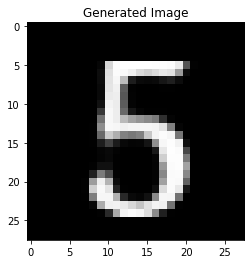

Intended digit:  5
Intended as handwritten:  False
Epoch: 2061 average training loss: 92.57780970001221
Epoch: 2062 average training loss: 92.56854729766846
Epoch: 2063 average training loss: 92.54713679962158
Epoch: 2064 average training loss: 92.54905678253174
Epoch: 2065 average training loss: 92.53354398956299
Epoch: 2066 average training loss: 92.53953464508056
Epoch: 2067 average training loss: 92.5510692642212
Epoch: 2068 average training loss: 92.5565308303833
Epoch: 2069 average training loss: 92.5632598953247
Epoch: 2070 average training loss: 92.54672212677002
Epoch: 2070 average test loss: 98.83126798706054
Comparing a random test image to its reconstruction:


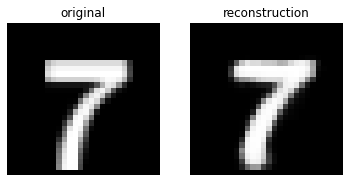

Generate a random image from the model:


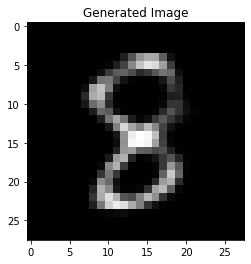

Intended digit:  8
Intended as handwritten:  False
Epoch: 2071 average training loss: 92.57448855743408
Epoch: 2072 average training loss: 92.5818891067505
Epoch: 2073 average training loss: 92.52968772125244
Epoch: 2074 average training loss: 92.54736088409423
Epoch: 2075 average training loss: 92.58110257110596
Epoch: 2076 average training loss: 92.57614382476807
Epoch: 2077 average training loss: 92.54206814117431
Epoch: 2078 average training loss: 92.58649909210204
Epoch: 2079 average training loss: 92.55070952911377
Epoch: 2080 average training loss: 92.56604429473877
Epoch: 2080 average test loss: 98.74595895385742
Comparing a random test image to its reconstruction:


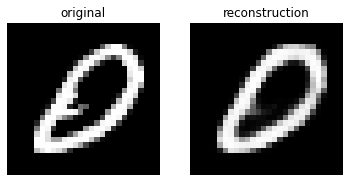

Generate a random image from the model:


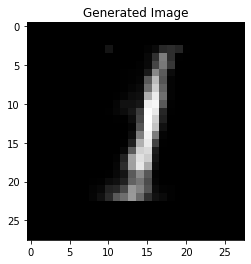

Intended digit:  1
Intended as handwritten:  False
Epoch: 2081 average training loss: 92.5731364578247
Epoch: 2082 average training loss: 92.52160755767822
Epoch: 2083 average training loss: 92.5609077041626
Epoch: 2084 average training loss: 92.56864195098876
Epoch: 2085 average training loss: 92.55099120635987
Epoch: 2086 average training loss: 92.53055242462158
Epoch: 2087 average training loss: 92.53745963897705
Epoch: 2088 average training loss: 92.54448249053955
Epoch: 2089 average training loss: 92.55402506866456
Epoch: 2090 average training loss: 92.529136769104
Epoch: 2090 average test loss: 98.8068714477539
Comparing a random test image to its reconstruction:


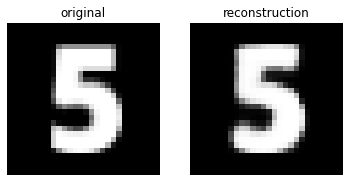

Generate a random image from the model:


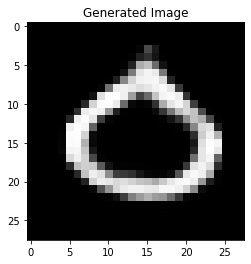

Intended digit:  0
Intended as handwritten:  False
Epoch: 2091 average training loss: 92.53788736114502
Epoch: 2092 average training loss: 92.54677338409424
Epoch: 2093 average training loss: 92.54098139190674
Epoch: 2094 average training loss: 92.53063570098877
Epoch: 2095 average training loss: 92.53245805206299
Epoch: 2096 average training loss: 92.52732091217041
Epoch: 2097 average training loss: 92.54922769927978
Epoch: 2098 average training loss: 92.54844178619385
Epoch: 2099 average training loss: 92.55055454864502
Epoch: 2100 average training loss: 92.55498667755127
Epoch: 2100 average test loss: 98.72194166870118
Comparing a random test image to its reconstruction:


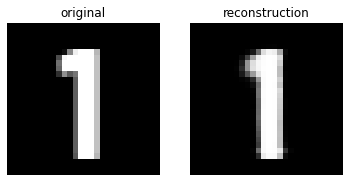

Generate a random image from the model:


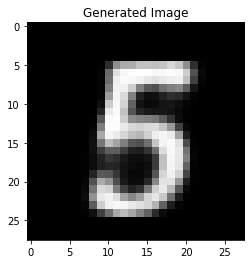

Intended digit:  5
Intended as handwritten:  False
Epoch: 2101 average training loss: 92.56115921783447
Epoch: 2102 average training loss: 92.54865862579345
Epoch: 2103 average training loss: 92.51711112823486
Epoch: 2104 average training loss: 92.54171718292237
Epoch: 2105 average training loss: 92.5304501235962
Epoch: 2106 average training loss: 92.54854624786377
Epoch: 2107 average training loss: 92.54186988677978
Epoch: 2108 average training loss: 92.5476263381958
Epoch: 2109 average training loss: 92.53472459259034
Epoch: 2110 average training loss: 92.52712308502197
Epoch: 2110 average test loss: 98.8041667602539
Comparing a random test image to its reconstruction:


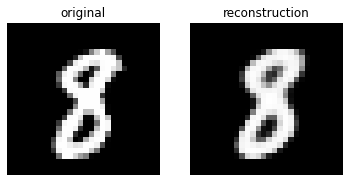

Generate a random image from the model:


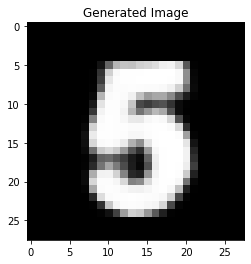

Intended digit:  5
Intended as handwritten:  False
Epoch: 2111 average training loss: 92.50570479278565
Epoch: 2112 average training loss: 92.54365601348877
Epoch: 2113 average training loss: 92.49408202056885
Epoch: 2114 average training loss: 92.53008683624267
Epoch: 2115 average training loss: 92.54949675445556
Epoch: 2116 average training loss: 92.53741569366456
Epoch: 2117 average training loss: 92.53072232208253
Epoch: 2118 average training loss: 92.52138311309814
Epoch: 2119 average training loss: 92.50630285797119
Epoch: 2120 average training loss: 92.53441139678955
Epoch: 2120 average test loss: 98.70905323486328
Comparing a random test image to its reconstruction:


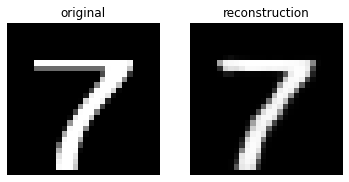

Generate a random image from the model:


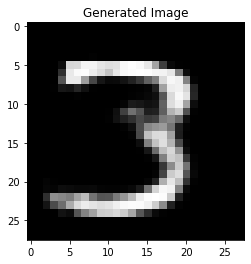

Intended digit:  3
Intended as handwritten:  False
Epoch: 2121 average training loss: 92.51740048370361
Epoch: 2122 average training loss: 92.52246225128174
Epoch: 2123 average training loss: 92.53167774200439
Epoch: 2124 average training loss: 92.53845921173095
Epoch: 2125 average training loss: 92.5156194656372
Epoch: 2126 average training loss: 92.52658260040283
Epoch: 2127 average training loss: 92.49829816436768
Epoch: 2128 average training loss: 92.548147114563
Epoch: 2129 average training loss: 92.52653578033447
Epoch: 2130 average training loss: 92.53070597686768
Epoch: 2130 average test loss: 98.84467911376953
Comparing a random test image to its reconstruction:


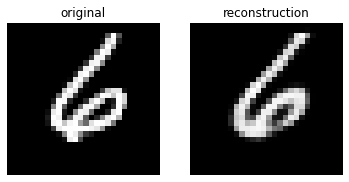

Generate a random image from the model:


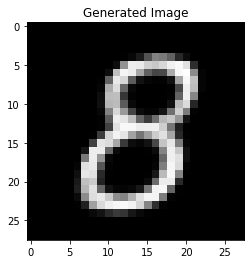

Intended digit:  8
Intended as handwritten:  False
Epoch: 2131 average training loss: 92.53283803253174
Epoch: 2132 average training loss: 92.5274833328247
Epoch: 2133 average training loss: 92.5025625442505
Epoch: 2134 average training loss: 92.53040354156494
Epoch: 2135 average training loss: 92.49657698516846
Epoch: 2136 average training loss: 92.54810624542236
Epoch: 2137 average training loss: 92.51334126739502
Epoch: 2138 average training loss: 92.53025732574463
Epoch: 2139 average training loss: 92.53731647491455
Epoch: 2140 average training loss: 92.51095652618409
Epoch: 2140 average test loss: 98.88865049438476
Comparing a random test image to its reconstruction:


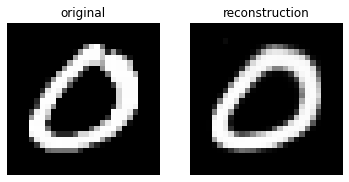

Generate a random image from the model:


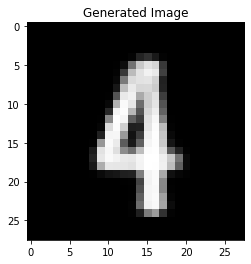

Intended digit:  4
Intended as handwritten:  False
Epoch: 2141 average training loss: 92.51616407012939
Epoch: 2142 average training loss: 92.50684917755127
Epoch: 2143 average training loss: 92.53477844390869
Epoch: 2144 average training loss: 92.5018715713501
Epoch: 2145 average training loss: 92.48884466094971
Epoch: 2146 average training loss: 92.50950070343018
Epoch: 2147 average training loss: 92.5123706741333
Epoch: 2148 average training loss: 92.514462550354
Epoch: 2149 average training loss: 92.53448811798096
Epoch: 2150 average training loss: 92.56356789093017
Epoch: 2150 average test loss: 98.94100994873047
Comparing a random test image to its reconstruction:


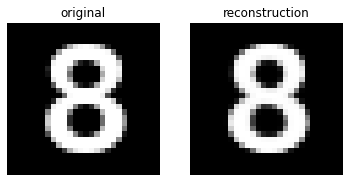

Generate a random image from the model:


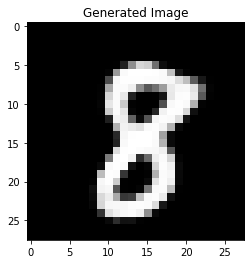

Intended digit:  8
Intended as handwritten:  False
Epoch: 2151 average training loss: 92.51645362091064
Epoch: 2152 average training loss: 92.50756513214111
Epoch: 2153 average training loss: 92.50112118682861
Epoch: 2154 average training loss: 92.51291225128173
Epoch: 2155 average training loss: 92.52370347442627
Epoch: 2156 average training loss: 92.49924762115478
Epoch: 2157 average training loss: 92.50774987335205
Epoch: 2158 average training loss: 92.4989343826294
Epoch: 2159 average training loss: 92.50838435821534
Epoch: 2160 average training loss: 92.50471773834228
Epoch: 2160 average test loss: 98.91023072509766
Comparing a random test image to its reconstruction:


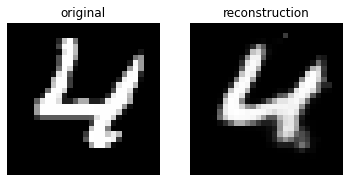

Generate a random image from the model:


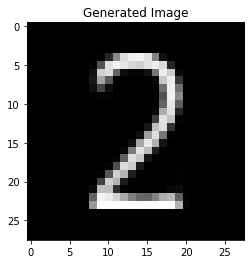

Intended digit:  2
Intended as handwritten:  False
Epoch: 2161 average training loss: 92.50792039337158
Epoch: 2162 average training loss: 92.51747611236573
Epoch: 2163 average training loss: 92.51977178497314
Epoch: 2164 average training loss: 92.49216144561768
Epoch: 2165 average training loss: 92.5247555557251
Epoch: 2166 average training loss: 92.49411272735595
Epoch: 2167 average training loss: 92.49214584503174
Epoch: 2168 average training loss: 92.50709010772705
Epoch: 2169 average training loss: 92.51866897125244
Epoch: 2170 average training loss: 92.49788835601807
Epoch: 2170 average test loss: 98.99119456787109
Comparing a random test image to its reconstruction:


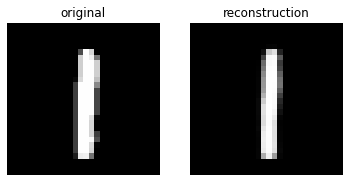

Generate a random image from the model:


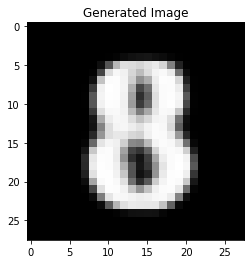

Intended digit:  8
Intended as handwritten:  False
Epoch: 2171 average training loss: 92.47003096466065
Epoch: 2172 average training loss: 92.52365373077393
Epoch: 2173 average training loss: 92.53551901397705
Epoch: 2174 average training loss: 92.49432931671143
Epoch: 2175 average training loss: 92.51434897613525
Epoch: 2176 average training loss: 92.48952974395752
Epoch: 2177 average training loss: 92.51161815948487
Epoch: 2178 average training loss: 92.50377407989502
Epoch: 2179 average training loss: 92.5123952835083
Epoch: 2180 average training loss: 92.4906277786255
Epoch: 2180 average test loss: 99.11526637573242
Comparing a random test image to its reconstruction:


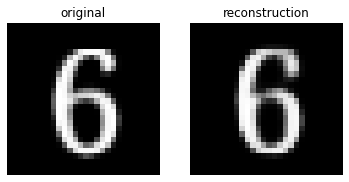

Generate a random image from the model:


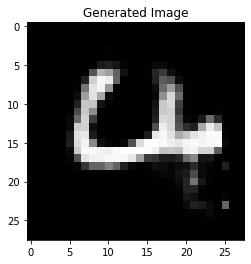

Intended digit:  4
Intended as handwritten:  False
Epoch: 2181 average training loss: 92.46646581573486
Epoch: 2182 average training loss: 92.51010678253174
Epoch: 2183 average training loss: 92.4994664932251
Epoch: 2184 average training loss: 92.50072875518799
Epoch: 2185 average training loss: 92.50057569122315
Epoch: 2186 average training loss: 92.49937311553956
Epoch: 2187 average training loss: 92.47757329864503
Epoch: 2188 average training loss: 92.48318665313721
Epoch: 2189 average training loss: 92.4949843460083
Epoch: 2190 average training loss: 92.48560990753174
Epoch: 2190 average test loss: 98.92522409667968
Comparing a random test image to its reconstruction:


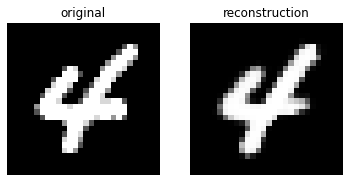

Generate a random image from the model:


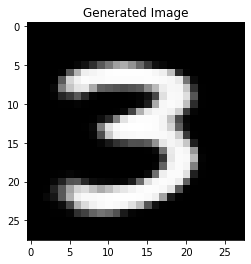

Intended digit:  3
Intended as handwritten:  False
Epoch: 2191 average training loss: 92.4791911453247
Epoch: 2192 average training loss: 92.50550651397705
Epoch: 2193 average training loss: 92.50335038604736
Epoch: 2194 average training loss: 92.46677755889893
Epoch: 2195 average training loss: 92.49504608917236
Epoch: 2196 average training loss: 92.47254246368408
Epoch: 2197 average training loss: 92.50168134307862
Epoch: 2198 average training loss: 92.47790874176026
Epoch: 2199 average training loss: 92.5110409866333
Epoch: 2200 average training loss: 92.50088116607667
Epoch: 2200 average test loss: 99.01316426391601
Comparing a random test image to its reconstruction:


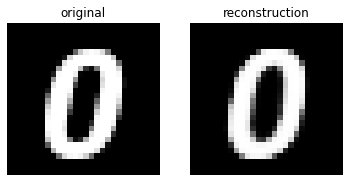

Generate a random image from the model:


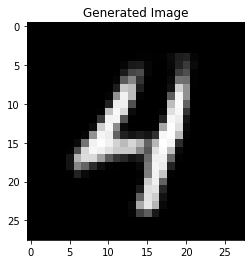

Intended digit:  4
Intended as handwritten:  False
Epoch: 2201 average training loss: 92.50010921173096
Epoch: 2202 average training loss: 92.4804007522583
Epoch: 2203 average training loss: 92.46369146270752
Epoch: 2204 average training loss: 92.50114877471924
Epoch: 2205 average training loss: 92.50279472198487
Epoch: 2206 average training loss: 92.47606767120361
Epoch: 2207 average training loss: 92.48620242462158
Epoch: 2208 average training loss: 92.51869613189697
Epoch: 2209 average training loss: 92.48375880889893
Epoch: 2210 average training loss: 92.4985460647583
Epoch: 2210 average test loss: 98.86062468261719
Comparing a random test image to its reconstruction:


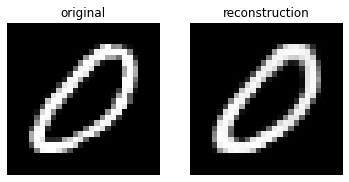

Generate a random image from the model:


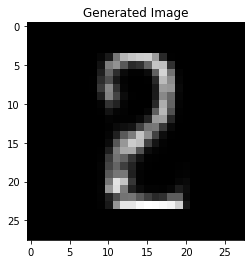

Intended digit:  2
Intended as handwritten:  False
Epoch: 2211 average training loss: 92.45009467315674
Epoch: 2212 average training loss: 92.49842998809814
Epoch: 2213 average training loss: 92.50442587432862
Epoch: 2214 average training loss: 92.46678382110596
Epoch: 2215 average training loss: 92.48858076934815
Epoch: 2216 average training loss: 92.48161840362549
Epoch: 2217 average training loss: 92.50307454376221
Epoch: 2218 average training loss: 92.4847487197876
Epoch: 2219 average training loss: 92.48746511993409
Epoch: 2220 average training loss: 92.4717427810669
Epoch: 2220 average test loss: 98.89537916870117
Comparing a random test image to its reconstruction:


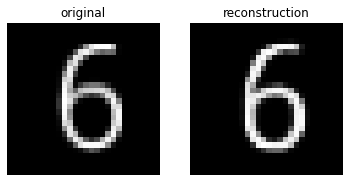

Generate a random image from the model:


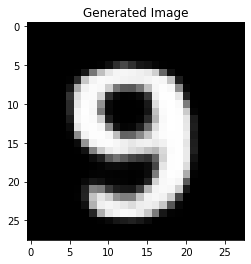

Intended digit:  9
Intended as handwritten:  False
Epoch: 2221 average training loss: 92.51523463287353
Epoch: 2222 average training loss: 92.49501430206298
Epoch: 2223 average training loss: 92.50251699371339
Epoch: 2224 average training loss: 92.45557057037354
Epoch: 2225 average training loss: 92.48164853057861
Epoch: 2226 average training loss: 92.49466345977783
Epoch: 2227 average training loss: 92.46385424957275
Epoch: 2228 average training loss: 92.48948752593994
Epoch: 2229 average training loss: 92.46814013824464
Epoch: 2230 average training loss: 92.45970012969971
Epoch: 2230 average test loss: 98.99100114135742
Comparing a random test image to its reconstruction:


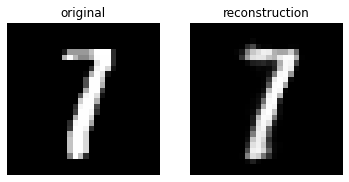

Generate a random image from the model:


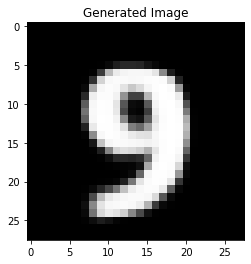

Intended digit:  9
Intended as handwritten:  False
Epoch: 2231 average training loss: 92.47399076690674
Epoch: 2232 average training loss: 92.47137270050048
Epoch: 2233 average training loss: 92.50249844512939
Epoch: 2234 average training loss: 92.4908415298462
Epoch: 2235 average training loss: 92.4526732498169
Epoch: 2236 average training loss: 92.47380811309814
Epoch: 2237 average training loss: 92.45260574493408
Epoch: 2238 average training loss: 92.47066602935791
Epoch: 2239 average training loss: 92.48423433990479
Epoch: 2240 average training loss: 92.46895633087158
Epoch: 2240 average test loss: 99.27233364257812
Comparing a random test image to its reconstruction:


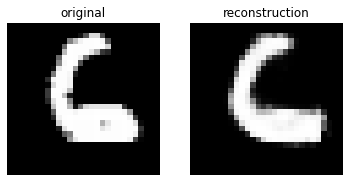

Generate a random image from the model:


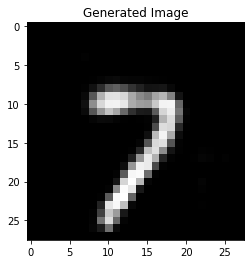

Intended digit:  7
Intended as handwritten:  False
Epoch: 2241 average training loss: 92.4797048110962
Epoch: 2242 average training loss: 92.45889501495361
Epoch: 2243 average training loss: 92.49370652008056
Epoch: 2244 average training loss: 92.4657154006958
Epoch: 2245 average training loss: 92.47543281402588
Epoch: 2246 average training loss: 92.47525806427002
Epoch: 2247 average training loss: 92.4542720046997
Epoch: 2248 average training loss: 92.45434237823487
Epoch: 2249 average training loss: 92.46606897125244
Epoch: 2250 average training loss: 92.45114764556885
Epoch: 2250 average test loss: 98.96446131591797
Comparing a random test image to its reconstruction:


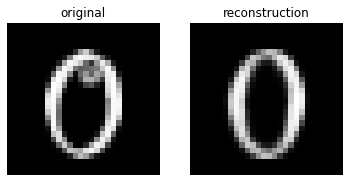

Generate a random image from the model:


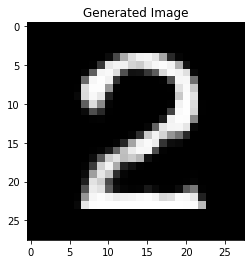

Intended digit:  2
Intended as handwritten:  False
Epoch: 2251 average training loss: 92.45915493927002
Epoch: 2252 average training loss: 92.469104347229
Epoch: 2253 average training loss: 92.48010819854737
Epoch: 2254 average training loss: 92.48113900909424
Epoch: 2255 average training loss: 92.46711566925049
Epoch: 2256 average training loss: 92.47891143341064
Epoch: 2257 average training loss: 92.46278380889892
Epoch: 2258 average training loss: 92.44340379180908
Epoch: 2259 average training loss: 92.45811725616456
Epoch: 2260 average training loss: 92.45455986480712
Epoch: 2260 average test loss: 99.05939465332031
Comparing a random test image to its reconstruction:


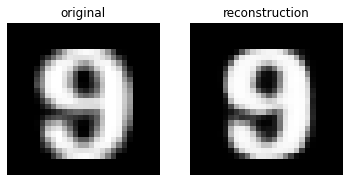

Generate a random image from the model:


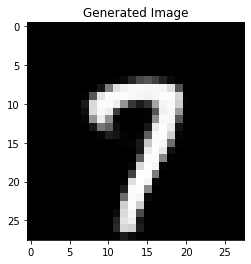

Intended digit:  7
Intended as handwritten:  False
Epoch: 2261 average training loss: 92.48067708892822
Epoch: 2262 average training loss: 92.45465596466065
Epoch: 2263 average training loss: 92.44117862091065
Epoch: 2264 average training loss: 92.42917908477783
Epoch: 2265 average training loss: 92.44960565338135
Epoch: 2266 average training loss: 92.44133117218017
Epoch: 2267 average training loss: 92.43883484649658
Epoch: 2268 average training loss: 92.44624522247314
Epoch: 2269 average training loss: 92.44209315338135
Epoch: 2270 average training loss: 92.45121736602783
Epoch: 2270 average test loss: 99.04289766235351
Comparing a random test image to its reconstruction:


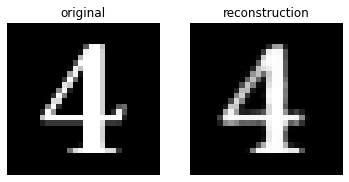

Generate a random image from the model:


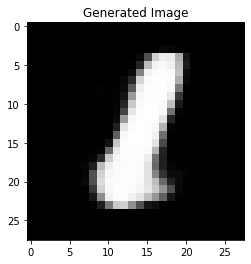

Intended digit:  1
Intended as handwritten:  False
Epoch: 2271 average training loss: 92.46381085968018
Epoch: 2272 average training loss: 92.44885259552002
Epoch: 2273 average training loss: 92.47981350860596
Epoch: 2274 average training loss: 92.45753900299073
Epoch: 2275 average training loss: 92.44486013946533
Epoch: 2276 average training loss: 92.44357211456298
Epoch: 2277 average training loss: 92.45056282501221
Epoch: 2278 average training loss: 92.45219320831299
Epoch: 2279 average training loss: 92.45708542633056
Epoch: 2280 average training loss: 92.45952196807862
Epoch: 2280 average test loss: 99.06884708862304
Comparing a random test image to its reconstruction:


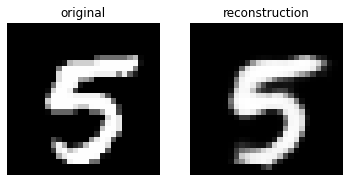

Generate a random image from the model:


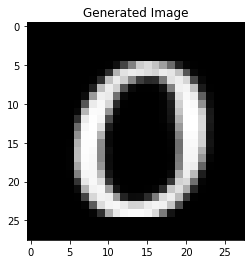

Intended digit:  0
Intended as handwritten:  False
Epoch: 2281 average training loss: 92.44963932647705
Epoch: 2282 average training loss: 92.46059093170166
Epoch: 2283 average training loss: 92.4578287979126
Epoch: 2284 average training loss: 92.44014948883057
Epoch: 2285 average training loss: 92.46894933013915
Epoch: 2286 average training loss: 92.46236588897705
Epoch: 2287 average training loss: 92.44655039215088
Epoch: 2288 average training loss: 92.45439467315674
Epoch: 2289 average training loss: 92.46110186920166
Epoch: 2290 average training loss: 92.45199939727783
Epoch: 2290 average test loss: 98.92505959472656
Comparing a random test image to its reconstruction:


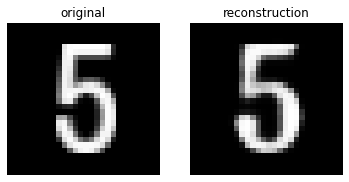

Generate a random image from the model:


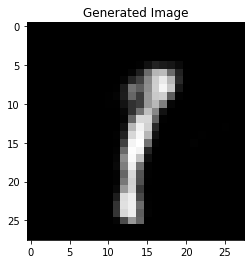

Intended digit:  1
Intended as handwritten:  False
Epoch: 2291 average training loss: 92.41775106964111
Epoch: 2292 average training loss: 92.48062002105713
Epoch: 2293 average training loss: 92.45239413604736
Epoch: 2294 average training loss: 92.44551313018799
Epoch: 2295 average training loss: 92.43601793365478
Epoch: 2296 average training loss: 92.48121586456298
Epoch: 2297 average training loss: 92.45087603302002
Epoch: 2298 average training loss: 92.44682082061767
Epoch: 2299 average training loss: 92.45818737945557
Epoch: 2300 average training loss: 92.44027522125243
Epoch: 2300 average test loss: 99.16202026367188
Comparing a random test image to its reconstruction:


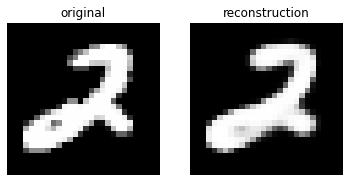

Generate a random image from the model:


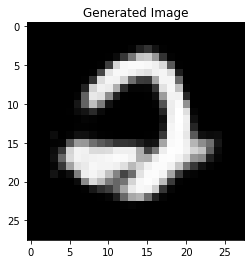

Intended digit:  2
Intended as handwritten:  False
Epoch: 2301 average training loss: 92.42206208648682
Epoch: 2302 average training loss: 92.47384998321533
Epoch: 2303 average training loss: 92.43566371612549
Epoch: 2304 average training loss: 92.42206687774659
Epoch: 2305 average training loss: 92.45430023956298
Epoch: 2306 average training loss: 92.4102339187622
Epoch: 2307 average training loss: 92.44454904327392
Epoch: 2308 average training loss: 92.42893935699463
Epoch: 2309 average training loss: 92.43864671783447
Epoch: 2310 average training loss: 92.43698394927979
Epoch: 2310 average test loss: 98.91323109130859
Comparing a random test image to its reconstruction:


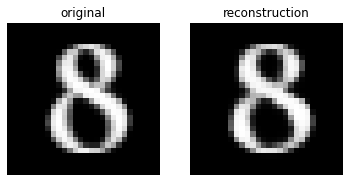

Generate a random image from the model:


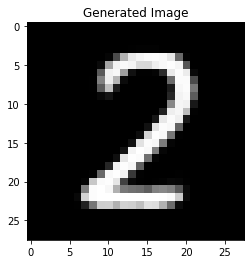

Intended digit:  2
Intended as handwritten:  False
Epoch: 2311 average training loss: 92.46660867462158
Epoch: 2312 average training loss: 92.41815536651612
Epoch: 2313 average training loss: 92.42161830596923
Epoch: 2314 average training loss: 92.41125376739502
Epoch: 2315 average training loss: 92.43592568511963
Epoch: 2316 average training loss: 92.44646417388915
Epoch: 2317 average training loss: 92.4508902053833
Epoch: 2318 average training loss: 92.40912879180908
Epoch: 2319 average training loss: 92.43119869537354
Epoch: 2320 average training loss: 92.4407604812622
Epoch: 2320 average test loss: 99.20087155761719
Comparing a random test image to its reconstruction:


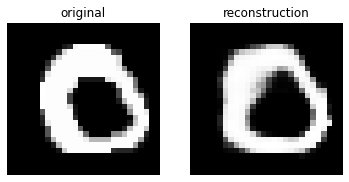

Generate a random image from the model:


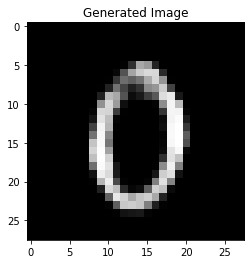

Intended digit:  0
Intended as handwritten:  False
Epoch: 2321 average training loss: 92.43713358917236
Epoch: 2322 average training loss: 92.4004248123169
Epoch: 2323 average training loss: 92.42068991241455
Epoch: 2324 average training loss: 92.40333084259034
Epoch: 2325 average training loss: 92.43743225860595
Epoch: 2326 average training loss: 92.44015409088135
Epoch: 2327 average training loss: 92.42416396026611
Epoch: 2328 average training loss: 92.43016709136963
Epoch: 2329 average training loss: 92.46107501983643
Epoch: 2330 average training loss: 92.42968088531494
Epoch: 2330 average test loss: 99.08897248535156
Comparing a random test image to its reconstruction:


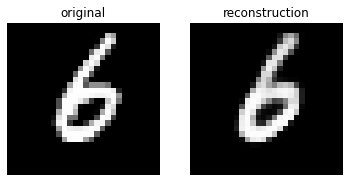

Generate a random image from the model:


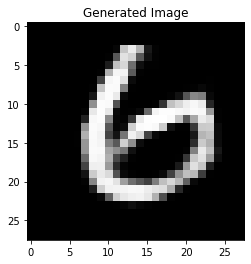

Intended digit:  6
Intended as handwritten:  False
Epoch: 2331 average training loss: 92.4224946182251
Epoch: 2332 average training loss: 92.3994433303833
Epoch: 2333 average training loss: 92.41084303741455
Epoch: 2334 average training loss: 92.4431257949829
Epoch: 2335 average training loss: 92.47208568267823
Epoch: 2336 average training loss: 92.39774154205323
Epoch: 2337 average training loss: 92.44109112091064
Epoch: 2338 average training loss: 92.41168391876221
Epoch: 2339 average training loss: 92.41630391387939
Epoch: 2340 average training loss: 92.41689246368408
Epoch: 2340 average test loss: 99.14176302490235
Comparing a random test image to its reconstruction:


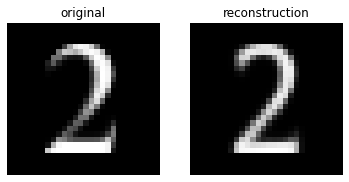

Generate a random image from the model:


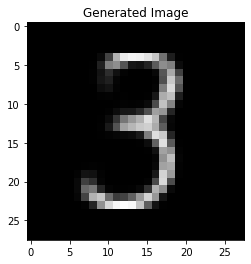

Intended digit:  3
Intended as handwritten:  False
Epoch: 2341 average training loss: 92.42961773834229
Epoch: 2342 average training loss: 92.40537342071534
Epoch: 2343 average training loss: 92.39650355987548
Epoch: 2344 average training loss: 92.43200233917236
Epoch: 2345 average training loss: 92.43366506500244
Epoch: 2346 average training loss: 92.39800402374267
Epoch: 2347 average training loss: 92.40223652496339
Epoch: 2348 average training loss: 92.41620285797119
Epoch: 2349 average training loss: 92.41184906768798
Epoch: 2350 average training loss: 92.44302289581299
Epoch: 2350 average test loss: 99.03065224609375
Comparing a random test image to its reconstruction:


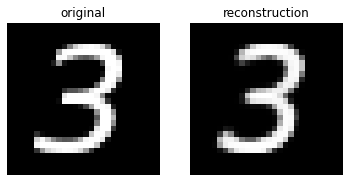

Generate a random image from the model:


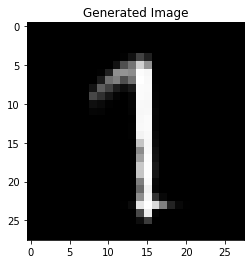

Intended digit:  1
Intended as handwritten:  False
Epoch: 2351 average training loss: 92.41859833526611
Epoch: 2352 average training loss: 92.4078050064087
Epoch: 2353 average training loss: 92.4105528640747
Epoch: 2354 average training loss: 92.44407538604736
Epoch: 2355 average training loss: 92.39853382110596
Epoch: 2356 average training loss: 92.4040414138794
Epoch: 2357 average training loss: 92.42875351104736
Epoch: 2358 average training loss: 92.39363130645752
Epoch: 2359 average training loss: 92.40531542510986
Epoch: 2360 average training loss: 92.40844469146728
Epoch: 2360 average test loss: 99.17918596191406
Comparing a random test image to its reconstruction:


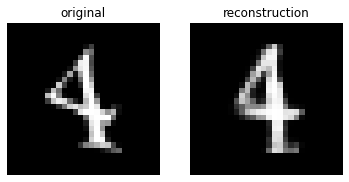

Generate a random image from the model:


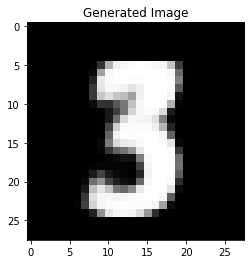

Intended digit:  3
Intended as handwritten:  False
Epoch: 2361 average training loss: 92.43161295928955
Epoch: 2362 average training loss: 92.45561029815674
Epoch: 2363 average training loss: 92.40002064971924
Epoch: 2364 average training loss: 92.41377491607666
Epoch: 2365 average training loss: 92.41158505401611
Epoch: 2366 average training loss: 92.41989156036377
Epoch: 2367 average training loss: 92.4215097366333
Epoch: 2368 average training loss: 92.4018493484497
Epoch: 2369 average training loss: 92.41222759552002
Epoch: 2370 average training loss: 92.39801670684814
Epoch: 2370 average test loss: 99.20243995361328
Comparing a random test image to its reconstruction:


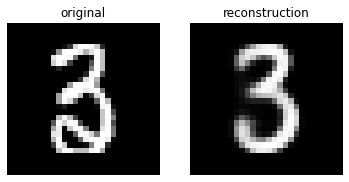

Generate a random image from the model:


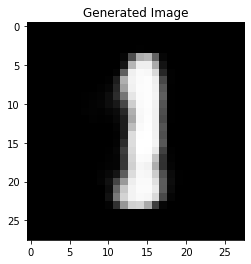

Intended digit:  1
Intended as handwritten:  False
Epoch: 2371 average training loss: 92.41847696075439
Epoch: 2372 average training loss: 92.41807684478759
Epoch: 2373 average training loss: 92.38539126739502
Epoch: 2374 average training loss: 92.41270193634033
Epoch: 2375 average training loss: 92.40505846710205
Epoch: 2376 average training loss: 92.43517747344971
Epoch: 2377 average training loss: 92.42773546905518
Epoch: 2378 average training loss: 92.41897205352784
Epoch: 2379 average training loss: 92.40366081695556
Epoch: 2380 average training loss: 92.43453675079346
Epoch: 2380 average test loss: 99.23422333984375
Comparing a random test image to its reconstruction:


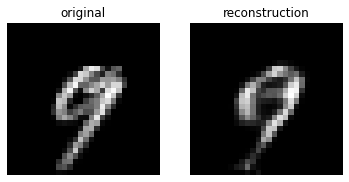

Generate a random image from the model:


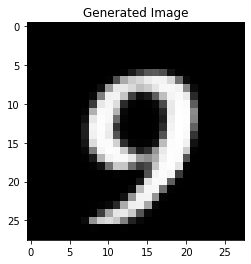

Intended digit:  9
Intended as handwritten:  False
Epoch: 2381 average training loss: 92.39479654083252
Epoch: 2382 average training loss: 92.4248597366333
Epoch: 2383 average training loss: 92.39118708648682
Epoch: 2384 average training loss: 92.38070070343018
Epoch: 2385 average training loss: 92.38644021148681
Epoch: 2386 average training loss: 92.39856290435792
Epoch: 2387 average training loss: 92.40559810333252
Epoch: 2388 average training loss: 92.41458225860596
Epoch: 2389 average training loss: 92.42405462188721
Epoch: 2390 average training loss: 92.40352465362548
Epoch: 2390 average test loss: 99.08527426147461
Comparing a random test image to its reconstruction:


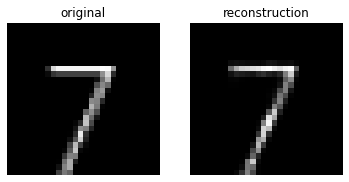

Generate a random image from the model:


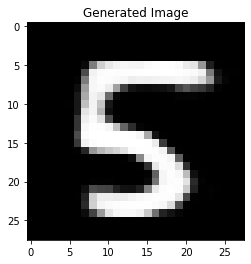

Intended digit:  5
Intended as handwritten:  False
Epoch: 2391 average training loss: 92.38804851226807
Epoch: 2392 average training loss: 92.41469890289306
Epoch: 2393 average training loss: 92.35688999786377
Epoch: 2394 average training loss: 92.4173043045044
Epoch: 2395 average training loss: 92.40830644073486
Epoch: 2396 average training loss: 92.38559314117431
Epoch: 2397 average training loss: 92.41648260040283
Epoch: 2398 average training loss: 92.39933541412354
Epoch: 2399 average training loss: 92.41217183380127
Epoch: 2400 average training loss: 92.40722241973877
Epoch: 2400 average test loss: 99.16099069824219
Comparing a random test image to its reconstruction:


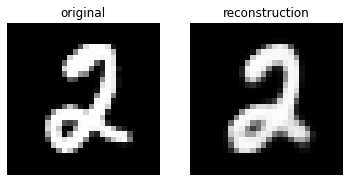

Generate a random image from the model:


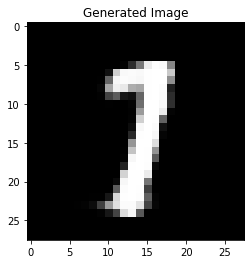

Intended digit:  1
Intended as handwritten:  False
Epoch: 2401 average training loss: 92.40035564727783
Epoch: 2402 average training loss: 92.38590833892822
Epoch: 2403 average training loss: 92.41854250030518
Epoch: 2404 average training loss: 92.41302802276611
Epoch: 2405 average training loss: 92.39022849273681
Epoch: 2406 average training loss: 92.38963073883056
Epoch: 2407 average training loss: 92.40095805206299
Epoch: 2408 average training loss: 92.35622865753174
Epoch: 2409 average training loss: 92.39851309967041
Epoch: 2410 average training loss: 92.38178720855713
Epoch: 2410 average test loss: 99.35988389892579
Comparing a random test image to its reconstruction:


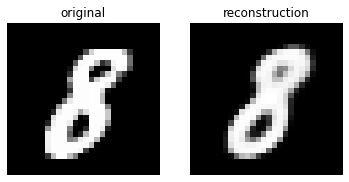

Generate a random image from the model:


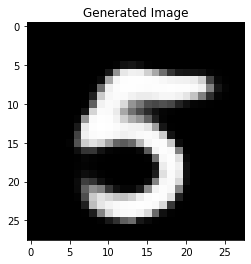

Intended digit:  5
Intended as handwritten:  False
Epoch: 2411 average training loss: 92.39053559112548
Epoch: 2412 average training loss: 92.39026117095948
Epoch: 2413 average training loss: 92.41318485870362
Epoch: 2414 average training loss: 92.40483941192628
Epoch: 2415 average training loss: 92.39079159088135
Epoch: 2416 average training loss: 92.3996710647583
Epoch: 2417 average training loss: 92.3988708694458
Epoch: 2418 average training loss: 92.37332346343995
Epoch: 2419 average training loss: 92.36165369415284
Epoch: 2420 average training loss: 92.37673164825439
Epoch: 2420 average test loss: 99.29059334716797
Comparing a random test image to its reconstruction:


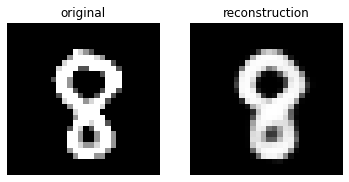

Generate a random image from the model:


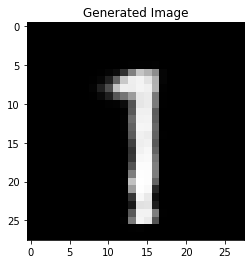

Intended digit:  1
Intended as handwritten:  False
Epoch: 2421 average training loss: 92.39038197784424
Epoch: 2422 average training loss: 92.39685740509033
Epoch: 2423 average training loss: 92.38230281524658
Epoch: 2424 average training loss: 92.38211718292236
Epoch: 2425 average training loss: 92.39224922637939
Epoch: 2426 average training loss: 92.39641768341065
Epoch: 2427 average training loss: 92.40423341827393
Epoch: 2428 average training loss: 92.35816898956298
Epoch: 2429 average training loss: 92.4034335647583
Epoch: 2430 average training loss: 92.38574341583252
Epoch: 2430 average test loss: 99.43008580322265
Comparing a random test image to its reconstruction:


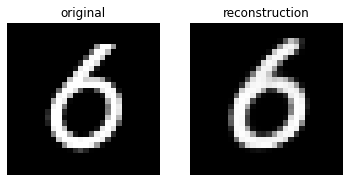

Generate a random image from the model:


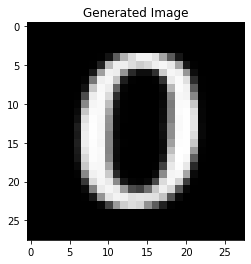

Intended digit:  0
Intended as handwritten:  False
Epoch: 2431 average training loss: 92.39153416290283
Epoch: 2432 average training loss: 92.39906573028564
Epoch: 2433 average training loss: 92.35774538116455
Epoch: 2434 average training loss: 92.37890850982666
Epoch: 2435 average training loss: 92.3963550491333
Epoch: 2436 average training loss: 92.35487455596923
Epoch: 2437 average training loss: 92.37210635528564
Epoch: 2438 average training loss: 92.38064479522706
Epoch: 2439 average training loss: 92.39071643829345
Epoch: 2440 average training loss: 92.37638850250244
Epoch: 2440 average test loss: 99.44708751220703
Comparing a random test image to its reconstruction:


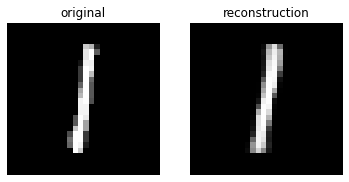

Generate a random image from the model:


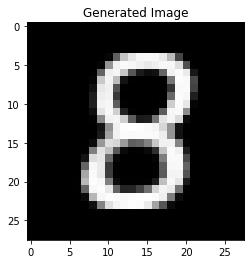

Intended digit:  8
Intended as handwritten:  False
Epoch: 2441 average training loss: 92.38013217315674
Epoch: 2442 average training loss: 92.36937683258057
Epoch: 2443 average training loss: 92.37780462799073
Epoch: 2444 average training loss: 92.38966077423096
Epoch: 2445 average training loss: 92.3906266860962
Epoch: 2446 average training loss: 92.36383000030517
Epoch: 2447 average training loss: 92.35903252716065
Epoch: 2448 average training loss: 92.3816911819458
Epoch: 2449 average training loss: 92.37727505645752
Epoch: 2450 average training loss: 92.38870113067627
Epoch: 2450 average test loss: 99.26015227661132
Comparing a random test image to its reconstruction:


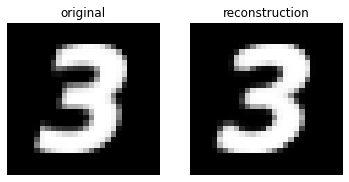

Generate a random image from the model:


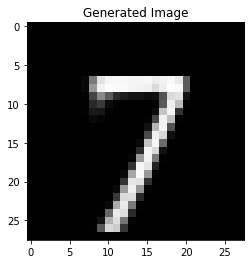

Intended digit:  7
Intended as handwritten:  False
Epoch: 2451 average training loss: 92.37480251007081
Epoch: 2452 average training loss: 92.37910119171143
Epoch: 2453 average training loss: 92.37296925201416
Epoch: 2454 average training loss: 92.38181561431885
Epoch: 2455 average training loss: 92.36586848907471
Epoch: 2456 average training loss: 92.37895914459229
Epoch: 2457 average training loss: 92.39262312774659
Epoch: 2458 average training loss: 92.37530673980713
Epoch: 2459 average training loss: 92.37979940948486
Epoch: 2460 average training loss: 92.37144782867432
Epoch: 2460 average test loss: 99.27112199096679
Comparing a random test image to its reconstruction:


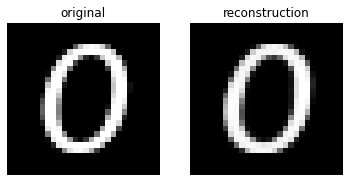

Generate a random image from the model:


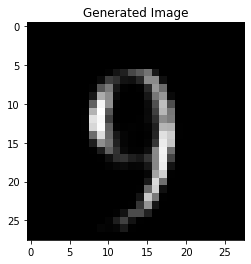

Intended digit:  9
Intended as handwritten:  False
Epoch: 2461 average training loss: 92.3781913772583
Epoch: 2462 average training loss: 92.36064777984619
Epoch: 2463 average training loss: 92.38579097442627
Epoch: 2464 average training loss: 92.38943502960205
Epoch: 2465 average training loss: 92.37686568756104
Epoch: 2466 average training loss: 92.40044312286376
Epoch: 2467 average training loss: 92.37518365020752
Epoch: 2468 average training loss: 92.36678351593018
Epoch: 2469 average training loss: 92.38239355621337
Epoch: 2470 average training loss: 92.36545791778565
Epoch: 2470 average test loss: 99.32705826416016
Comparing a random test image to its reconstruction:


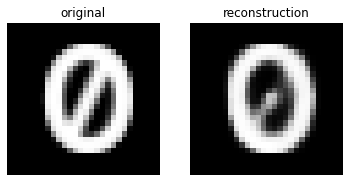

Generate a random image from the model:


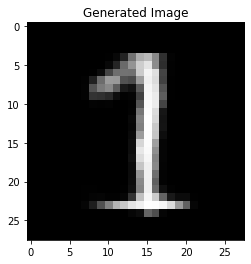

Intended digit:  1
Intended as handwritten:  False
Epoch: 2471 average training loss: 92.38005456695556
Epoch: 2472 average training loss: 92.3692924697876
Epoch: 2473 average training loss: 92.35479639434814
Epoch: 2474 average training loss: 92.37109320831298
Epoch: 2475 average training loss: 92.36378092193604
Epoch: 2476 average training loss: 92.36122913360596
Epoch: 2477 average training loss: 92.36453260040284
Epoch: 2478 average training loss: 92.35422460479737
Epoch: 2479 average training loss: 92.34999861602783
Epoch: 2480 average training loss: 92.38150174102783
Epoch: 2480 average test loss: 99.2517662109375
Comparing a random test image to its reconstruction:


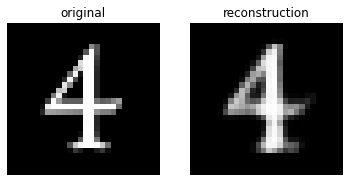

Generate a random image from the model:


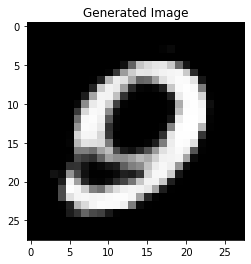

Intended digit:  9
Intended as handwritten:  False
Epoch: 2481 average training loss: 92.36556262969971
Epoch: 2482 average training loss: 92.36631501617431
Epoch: 2483 average training loss: 92.36581178741456
Epoch: 2484 average training loss: 92.37783945465088
Epoch: 2485 average training loss: 92.3667661453247
Epoch: 2486 average training loss: 92.36295919342041
Epoch: 2487 average training loss: 92.3682812942505
Epoch: 2488 average training loss: 92.34493695220947
Epoch: 2489 average training loss: 92.36546604766846
Epoch: 2490 average training loss: 92.33985984649658
Epoch: 2490 average test loss: 99.3642989440918
Comparing a random test image to its reconstruction:


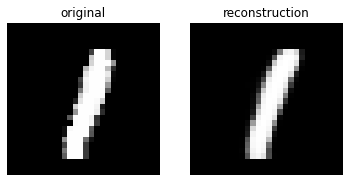

Generate a random image from the model:


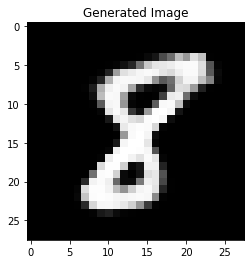

Intended digit:  8
Intended as handwritten:  False
Epoch: 2491 average training loss: 92.37339803009033
Epoch: 2492 average training loss: 92.33472912139892
Epoch: 2493 average training loss: 92.35418928985595
Epoch: 2494 average training loss: 92.37071919708252
Epoch: 2495 average training loss: 92.35446698760987
Epoch: 2496 average training loss: 92.35602973175048
Epoch: 2497 average training loss: 92.3841561050415
Epoch: 2498 average training loss: 92.35640887603759
Epoch: 2499 average training loss: 92.37059581451416
Epoch: 2500 average training loss: 92.34980546417236
Epoch: 2500 average test loss: 99.4166515258789
Comparing a random test image to its reconstruction:


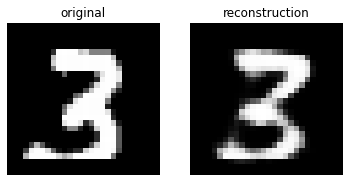

Generate a random image from the model:


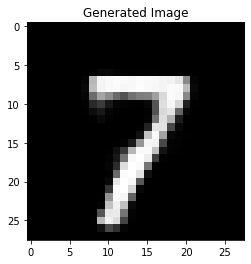

Intended digit:  7
Intended as handwritten:  False


In [ ]:
pyro.clear_param_store()
vae = VAE()

train_loader, test_loader = setup_dataloaders(batch_size=BATCH_SIZE, use_cuda=USE_CUDA)
train_size = len(train_loader.dataset)
test_size = len(test_loader.dataset)

svi_adam = pyro.optim.Adam({"lr": LEARNING_RATE})
svi = SVI(vae.training_model, vae.training_guide, svi_adam, loss=Trace_ELBO())
train_loss, test_loss = [], []

for epoch in range(0, NUM_EPOCHS+1):
    epoch_loss_train = 0
    for batch_idx, (img, digit, is_handwritten) in enumerate(train_loader):
        batch_size = img.shape[0]
        if USE_CUDA:
            img, digit, is_handwritten = img.cuda(), digit.cuda(), is_handwritten.cuda()
        img, digit, is_handwritten = reshape_data(img, digit, is_handwritten)
        epoch_loss_train += svi.step(img, digit, is_handwritten, batch_size)
    epoch_loss_train = epoch_loss_train / train_size
    print("Epoch: {} average training loss: {}".format(epoch, epoch_loss_train))
    train_loss.append(epoch_loss_train)
    if epoch % TEST_FREQUENCY == 0:
        epoch_loss_test = 0
        for batch_idx, (img, digit, is_handwritten) in enumerate(test_loader):
            batch_size = img.shape[0]
            if USE_CUDA:
                img, digit, is_handwritten = img.cuda(), digit.cuda(), is_handwritten.cuda()
            img, digit, is_handwritten = reshape_data(img, digit, is_handwritten)
            epoch_loss_test += svi.evaluate_loss(img, digit, is_handwritten, batch_size)
        epoch_loss_test = epoch_loss_test/test_size
        print("Epoch: {} average test loss: {}".format(epoch, epoch_loss_test))
        print("Comparing a random test image to its reconstruction:")
        img_rng, digit_rng, is_handwritten_rng = get_random_example(test_loader)
        img_recon = reconstruct_img(vae, img_rng, digit_rng, is_handwritten_rng)
        compare_images(img_rng, img_recon)
        print("Generate a random image from the model:")
        img_gen, digit_gen, is_handwritten_gen = generate_data(vae)
        plot_image(img_gen, "Generated Image")
        print("Intended digit: ", int(digit_gen))
        print("Intended as handwritten: ", bool(is_handwritten_gen == 1))

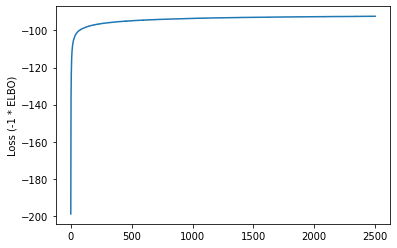

In [ ]:
plt.plot(range(len(train_loss)), [-x for x in train_loss])
plt.ylabel('Loss (-1 * ELBO)')
plt.show()

In [ ]:
torch.save(vae.state_dict(), 'mnist_tmnist_weights_March11.pt')

from google.colab import files
files.download("mnist_tmnist_weights_March11.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>